In [125]:
import ast
import matplotlib.pyplot as plt
import multiprocess as mp
import networkx as nx
import numpy as np
import os
import pandas as pd
import random
import sys
import torch
import time

from collections import deque
from concorde.tsp import TSPSolver
from concorde.tests.data_utils import get_dataset_path
from graph_utils import plot_network
from python_tsp.exact import solve_tsp_dynamic_programming
from sklearn.model_selection import ParameterGrid
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau
# from torchsummary import summary

from agent import Agent
from env import MVCEnv, TSPEnv
from model import QNetwork
from solver import solve, solve2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


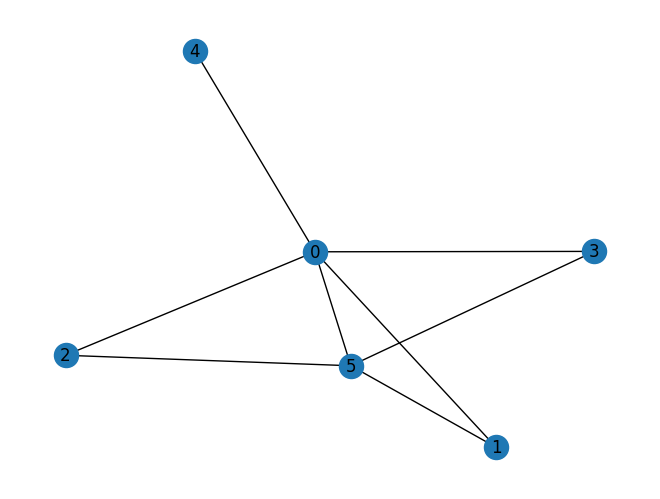

In [193]:
env = MVCEnv(6, 6, graph_type=MVCEnv.BARABASI_ALBERT)
env.n_edges
nx.draw(env.G, with_labels=True)

In [222]:
agent = Agent(
    nstep=1,
    normalize=True,
    batch_size=1,
    lr=1e-4, # LR is set via LR scheduler 
    n_node_features=1,
    n_edge_features=0
)
run_episode(agent, env, eps_start=0, eps_decay=0, eps_end=0, train_mode=True, print_actions=True)


0
4
5


(-0.5, 0)

## Helper functions

In [2]:
def get_concorde_solution(env, time_bound=5):
    pos = nx.get_node_attributes(env.G, 'pos')
    pos_numpy = np.array(list(pos.values()))
    solver = TSPSolver.from_data(pos_numpy[:, 0], pos_numpy[:, 1], "EUC_2D")
    
    # # Redirect stdout
    # save_stdout = sys.stdout
    # save_stderr = sys.stderr
    # sys.stdout = open(os.devnull, 'w')
    
    solution = solver.solve(time_bound=time_bound, verbose=False)
    
    # Recover original stdout
    # sys.stdout = save_stdout
    
    # print(solution.optimal_value)
    dist = lambda u, v: env.G[u].get(v, {}).get('weight', float('inf'))
    actual_solution = sum([dist(u, v) for (u,v) in zip(solution.tour[:-1], solution.tour[1:])]) + dist(solution.tour[-1], solution.tour[0])
    return actual_solution

In [3]:
def get_solution(env, exact_solution_max_size=0, return_path=False):
    if env.G.number_of_nodes() <= exact_solution_max_size:
        dist_matrix = np.array([[env.G[u].get(v, {}).get('weight', float('inf')) for v in range(env.n)] for u in range(env.n)])
        solution = solve_tsp_dynamic_programming(dist_matrix)
        if not return_path:
            solution = solution[1]
        return solution
    else:
        return get_concorde_solution(env)

In [4]:
def run_validation(agent, env, n_episodes_validation, exact_solution_max_size=0, print_to_file=sys.stdout):
    agent.qnetwork_target.eval()
    agent.qnetwork_local.eval()
    val_scores = []
    for i in range(1, n_episodes_validation+1):
        score = run_episode(agent, env, train_mode=False)[0] * (env.normalize_reward * env.pos_lim)
        solution = get_solution(env, exact_solution_max_size)
        print(-score, solution, -score/solution)
        approximation_ration = -score/solution
        val_scores.append(approximation_ration)
    
    val_scores = np.array(val_scores)
    val_stats = pd.Series(val_scores).describe()
    print(
        f"[Validation] "
        f"Mean: {val_stats['mean']}, "
        f"Std dev: {val_stats['std']}, "
        f"Optimal: {100 * (abs(val_scores - 1.0) < 1e-6).sum() / n_episodes_validation :.2f}%",
        file=print_to_file
    )
    
    agent.qnetwork_target.train()
    agent.qnetwork_local.train()

    return val_stats

In [5]:
def run_episode(agent, env, eps_start=0, eps_decay=0, eps_end=0, train_mode=True, print_actions=False):
    state = env.reset()
    agent.reset_episode(env.G)
    score = 0
    eps = eps_start
    while True:
        action = agent.act(state, eps=eps if train_mode else 0)
        if print_actions:
            print(action)
        next_state, reward, done = env.step(action)
        score += reward
        if train_mode:
            eps = max(eps * eps_decay, eps_end)
            agent.step(state, action, reward, next_state, done)
        state = next_state
        if done:
            break
    return score, eps

In [6]:
def train(agent, env, eps_start, eps_decay, eps_end, scheduler=None, n_episodes=10000,
          start_episode=1, validate_each=25, n_episodes_validation=10, print_train_metrics_each=100,
          print_thetas=True, validate_at_start=True, print_to_file=sys.stdout):
    scores = []
    val_scores = []
    eps = eps_start
    start_time = time.time()
    if validate_at_start:
        val_score = run_validation(agent, env, n_episodes_validation, print_to_file=print_to_file)['mean']
        val_scores.append(val_score)
    for episode_idx in range(start_episode, n_episodes + 1):
        try:
            # run episode for given episode_idx
            score, eps = run_episode(agent, env, eps, eps_decay, eps_end, train_mode=True)
            scores.append(score)
            
            # update the LR scheduler
            if isinstance(scheduler, LambdaLR):
                scheduler.step()

            if episode_idx % print_train_metrics_each == 0:
                print(
                    f"[{episode_idx}/{n_episodes}] "
                    f"loss: {agent.losses[-1]:.3e}, "
                    f"q_target: {agent.q_targets[-1]:.3e}, "
                    f"q_expected: {agent.q_expecteds[-1]:.3e}, "
                    f"eps: {eps:.4f}, "
                    f"time: {time.time() - start_time:.2f}s",
                    file=print_to_file,
                    flush=True
                )
                if print_thetas:
                    print(f"    θ1: {agent.theta1s[-1]:.3e}, "
                        f"θ2: {agent.theta2s[-1]:.3e}, "
                        f"θ3: {agent.theta3s[-1]:.3e}, "
                        f"θ4: {agent.theta4s[-1]:.3e}, "
                        f"θ5: {agent.theta5s[-1]:.3e}, "
                        f"θ6: {agent.theta6s[-1]:.3e}, "
                        f"θ7: {agent.theta7s[-1]:.3e}",
                        file=print_to_file
                    )
            
            # check if we should run validation
            if episode_idx % validate_each == 0:
                score = run_validation(agent, env, n_episodes_validation, print_to_file=print_to_file)['mean']
                if isinstance(scheduler, ReduceLROnPlateau):
                    scheduler.step(score)
                val_scores.append(score)
        except KeyboardInterrupt:
            print(f"Training interrupted in episode #{episode_idx}")
            break
    print(f"Total time: {time.time() - start_time:.2f}s", file=print_to_file)
    return scores, val_scores

In [7]:
def eps_analysis(eps_start, eps_decay, eps_end, n, check_episodes=35000):
    return np.argmin([eps_start * (eps_decay ** (n*i)) > eps_end for i in range(check_episodes)])

In [8]:
def lr_lambda(lr_config):
    '''
    lr_config: list of tuples (start_episode, lr_value)
    '''
    def f(episode):
        for i in range(len(lr_config) - 1, -1, -1):
            start_episode, lr_value = lr_config[i]
            if episode >= start_episode:
                return lr_value
        raise ValueError("lr_config should have its first element starting at episode 0")
    return f

In [9]:
def plot_graphs(agent_losses, val_scores, max_loss=1.0, filename=None, **kwargs):
    agent_losses, val_scores = np.atleast_2d(agent_losses, val_scores)    
    
    title_config = ', '.join([f'{k} = {kwargs[k]}' for k in kwargs])
    # title_config = f'n = {n}, lr = {lr_config}'
    fig, ax = plt.subplots(2, 1, figsize=(10,8))
    
    losses_df = pd.DataFrame(agent_losses).T
    losses_df.plot(color='b', alpha=0.05, legend=False, xlabel='Minibatch', ylabel='Loss Value', ax=ax[0]);
    losses_df.mean(axis=1).plot(color='r', title=f'Loss Function\n{title_config}', ax=ax[0]);

    ax[0].set_title(f'Loss function\n{title_config}')
    ax[0].set_ylim((0, max_loss))
    
    val_df = pd.DataFrame(val_scores).T
    val_df.plot(color='b', alpha=0.05, legend=False, xlabel='Validation Episode', ylabel='Approximation Ratio', ax=ax[1]);
    val_df.mean(axis=1).plot(color='r', title=f'Validation scores\n{title_config}', ax=ax[1]);
    ax[1].set_title('Validation scores')

    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

In [10]:
def replay_graphs(outputs_prefix, max_loss=1.0, filename=None):
    with open(f'{outputs_prefix}_loss.log') as f:
        agent_losses_str = f.read()
    agent_losses = ast.literal_eval(agent_losses_str)
    with open(f'{outputs_prefix}_val.log') as f:
        val_scores_str = f.read()
    with open(f'{outputs_prefix}.log') as f:
        config_str = f.readlines()[0].strip()
    config = ast.literal_eval(config_str)
    val_scores = ast.literal_eval(val_scores_str)
    plot_graphs(agent_losses, val_scores, max_loss=max_loss, filename=filename,
                n=config['n'], lr_config=config['lr_config'], batch_size=config['batch_size'])

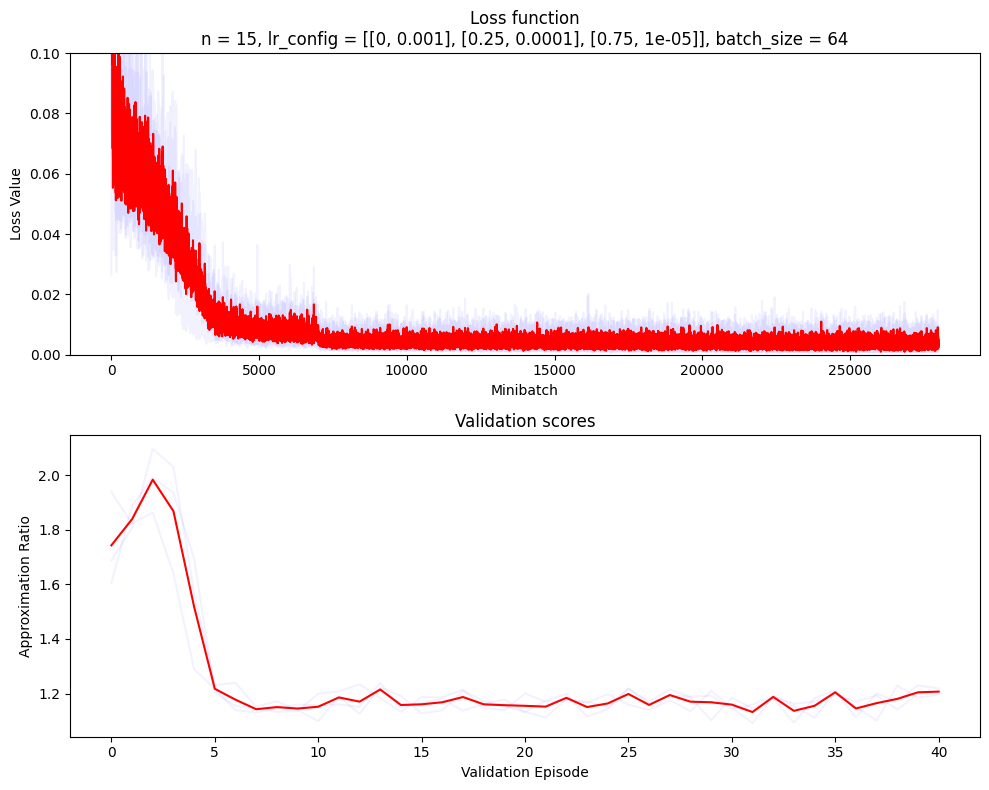

In [11]:
replay_graphs('outputs-old/run_8', max_loss=1e-1, filename=None)

## Run grid of parameters

In [20]:
def run_train(experiment_idx, n_runs, p):
    all_agent_losses = []
    all_val_scores = []
    
    n = p['n']
    pos_lim = p['pos_lim']
    n_episodes = p['n_episodes']
    eps_start = p['eps_start']
    eps_end = p['eps_end']
    eps_end_at_episode = p['eps_end_at_episode']
    batch_size = p['batch_size']
    
    # transform relative to absolute episode number
    lr_config = p['lr_config']
    lr_config = [(int(ep * n_episodes), lr) if 0 < ep <= 1 else (ep, lr) for (ep, lr) in lr_config]
    
    filename = 'outputs/run_{}.{}'
    f_log = open(filename.format(experiment_idx, 'log'), 'w')
    f_loss = open(filename.format(f'{experiment_idx}_loss', 'log'), 'w')
    f_val = open(filename.format(f'{experiment_idx}_val', 'log'), 'w')
    filename_plot = filename.format(experiment_idx, 'png')
    
    print(p)
    print(p, file=f_log)
    
    agents = []
    for run_idx in range(n_runs):
        agent = Agent(
            nstep=p.get('nstep', 1),
            normalize=p.get('normalize', True),
            batch_size=batch_size,
            lr=1, # LR is set via LR scheduler 
        )
        
        env = TSPEnv(n_min=n, n_max=n, pos_lim=pos_lim)

        scheduler = LambdaLR(agent.optimizer, lr_lambda=lr_lambda(lr_config), verbose=False)

        if 0 < eps_end_at_episode <= 1:
            eps_end_at_episode = round(eps_end_at_episode * n_episodes)
        # decay derived from formula eps_end = eps_start * (eps_decay ** (n * episode))
        eps_decay = (eps_end / eps_start) ** (1 / (n * eps_end_at_episode))

        print(f'Starting run #{run_idx+1}/{n_runs}...')
        print(f'Starting run #{run_idx+1}/{n_runs}...', file=f_log)
        scores, val_scores = train(
            agent, env, eps_start, eps_decay, eps_end,
            scheduler=scheduler, n_episodes=n_episodes,
            validate_each=p['validate_each'], print_train_metrics_each=p['print_train_metrics_each'],
            print_thetas=False, print_to_file=f_log)

        agents.append(agent)
        all_agent_losses.append(agent.losses)
        all_val_scores.append(val_scores)

    # print(f"{filename.format(experiment_idx, 'log')=}")
    # print(f"{filename.format(f'{experiment_idx}_loss', 'log')=}")
    # print(f"{filename.format(f'{experiment_idx}_val', 'log')=}")
    # print(f"{all_agent_losses=}")
    # print(f"{all_val_scores=}")

    print(all_agent_losses, file=f_loss)
    print(all_val_scores, file=f_val)
    
    f_log.close()
    f_loss.close()
    f_val.close()
#     with open(filename.format(f'{experiment_idx}_loss', 'log'), 'w') as f:
#         f.write(str(all_agent_losses))

#     with open(filename.format(f'{experiment_idx}_val', 'log'), 'w') as f:
#         f.write(str(all_val_scores))

    # print(filename.format(experiment_idx, 'png'))
    plot_graphs(all_agent_losses, all_val_scores, max_loss=1, filename=filename_plot,
               n=n, lr_config=lr_config, batch_size=batch_size)
    
    return agents

In [13]:
def run_train_from_params(params, n_runs, parallel=0, start_idx=0):
    '''
    parallel: 0 for sequential, -1 to use #processes = #param configs, >0 to use this number of processes
    '''
    parameter_grid = list(enumerate(ParameterGrid(params)))
    if parallel == 0:
        for experiment_idx, p in parameter_grid:
            run_train(start_idx + experiment_idx, n_runs, p)
    else:
        raise NotImplemented("Parallel version still not working atm")
        # ctx = mp.get_context('spawn')
        # max_workers = parallel if parallel > 0 else len(parameter_grid)
        # with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        #     future_to_idx = {executor.submit(run_train, start_idx + idx, p): start + idx for idx, p in parameter_grid}
        #     for future in concurrent.futures.as_completed(future_to_idx):
        #         idx = future_to_idx[future]
        #         try:
        #             data = future.result()
        #         except Exception as exc:
        #             print(f'Idx {idx} generated an exception: {exc}')
        #         else:
        #             print(f'Idx {idx} successful')
        # with ctx.Pool(pool_size) as pool:
        #     pool.starmap(run_train, parameter_grid)

In [37]:
n_runs = 3
params = {
    'n': [8, 12, 15],
    'lr_config': [[[0, 5e-4]], [[0, 1e-3], [0.3, 1e-4]], [[0, 1e-3], [0.25, 1e-4], [0.75, 1e-5]]],
    # 'n': [3, 4, 5],
    'n_episodes': [2000],
    # 'n_episodes': [100],
    'eps_start': [1.00],
    'eps_end': [0.01],
    'eps_end_at_episode': [0.6],
    'validate_each': [50],
    'print_train_metrics_each': [10],
    'batch_size': [64]
}

{'n': 8, 'pos_lim': 1.0, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.005, 'eps_end_at_episode': 0.8, 'validate_each': 50, 'print_train_metrics_each': 10, 'batch_size': 64}
Starting run #1/2...
4.209582155497683 2.684919078636705 1.567861835759736
2.6063219548164493 2.019172462397312 1.2907871929483574
3.942009444180031 2.3194881465398343 1.699516960265842
4.140095578636998 2.7725441377883002 1.493247852111604
3.0078994152956233 2.293947255952526 1.3112330318364882
3.5907787147061945 2.8489384536556037 1.2603918172042998
4.293409978844704 2.593313823150644 1.6555690023001521
2.663524189788302 2.523318072375704 1.0555641870707937
3.696225280953927 2.9354057716973103 1.2591871681224827
3.283086924048417 2.8551233962445854 1.1498931809275712
3.5777764629192568 2.5874136233803076 1.3827617009471787
3.0691783732749958 2.673592124612319 1.1479605827010875
3.1388050413092614 2.375983689583056 1.3210549613916194
2.4813925768435245 

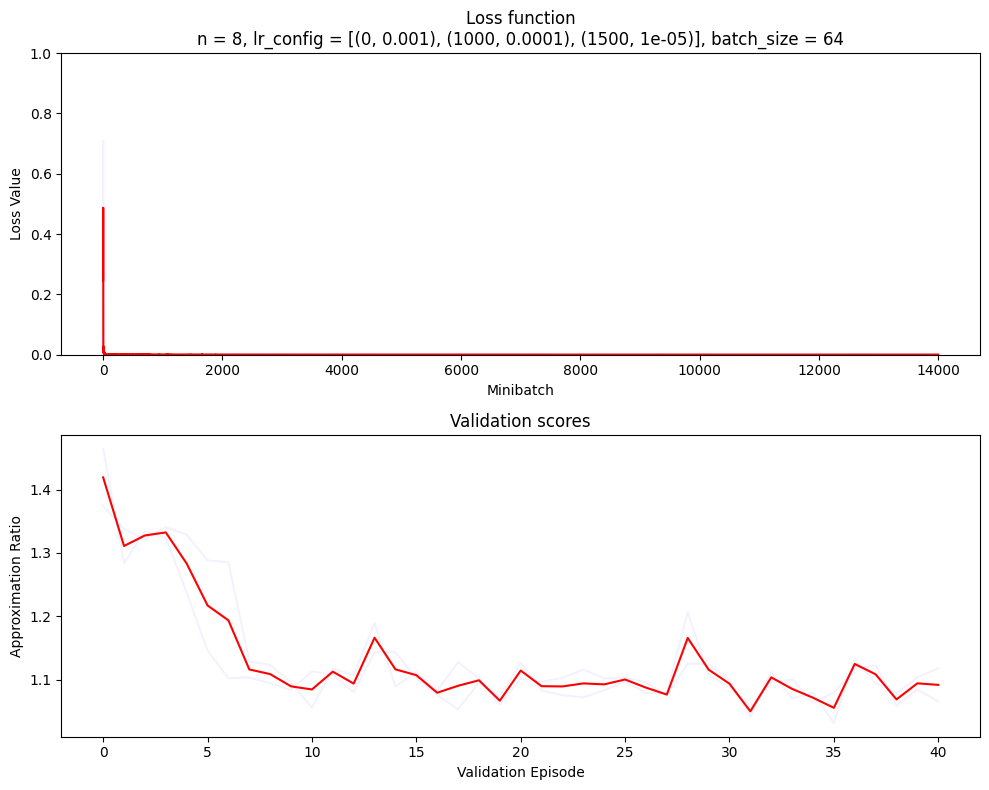

In [68]:
%%time
params = {
    'n': 8,
    'pos_lim': 1e0,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.005,
    'eps_end_at_episode': 0.8,
    'validate_each': 50,
    'print_train_metrics_each': 10,
    'batch_size': 64
}
agents = run_train(0, 2, params)

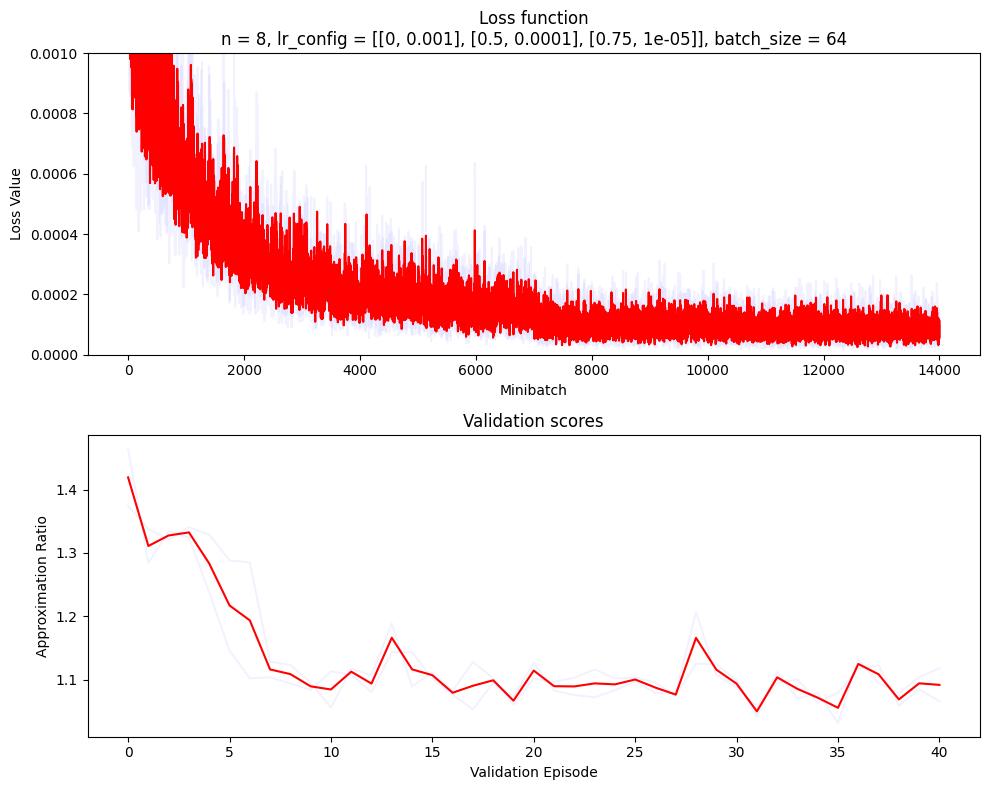

In [69]:
replay_graphs('outputs/run_0', max_loss=1e-3, filename=None)

{'n': 8, 'pos_lim': 1000000.0, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.005, 'eps_end_at_episode': 0.8, 'validate_each': 50, 'print_train_metrics_each': 10, 'batch_size': 64}
Starting run #1/2...
2899763.8961719787 2777425.4514146163 1.0440474269777618
3709095.480894019 2459845.934953102 1.5078568247668465
2239032.4232488493 1953648.6940327126 1.1460773014553856
3328620.074544616 2841963.8957721386 1.1712393952282272
3060650.730622532 2682595.428760658 1.1409289294273244
3825468.018293262 2480146.110924735 1.5424365530089341
3186829.920844415 2510135.81725896 1.2695846571060834
3398621.274878841 2840298.6564399623 1.1965717996496472
3997080.339038971 2769838.134199234 1.4430736185219484
3714812.636993697 2810284.818604447 1.3218633970482847
3203908.991006999 2463710.24961024 1.3004406632289078
3248188.5030221404 3034721.691018464 1.0703414789683847
3847403.7238532985 2764420.5416382737 1.3917577538955843
3096210.5063552

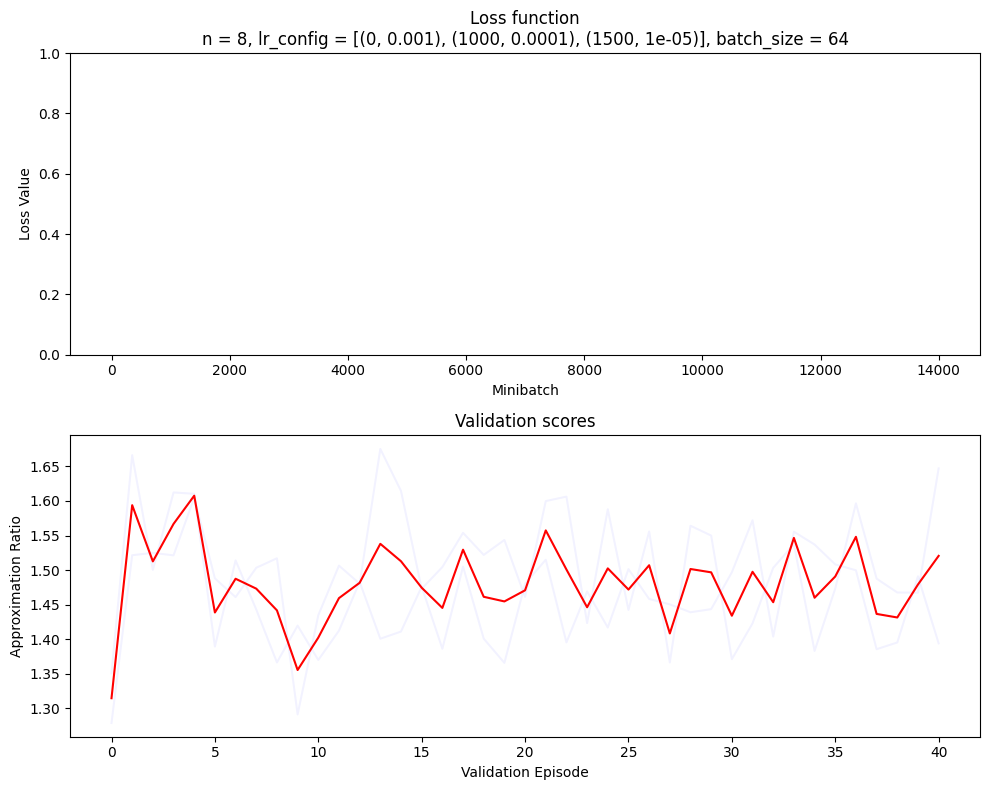

In [70]:
%%time
params = {
    'n': 8,
    'pos_lim': 1e6,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.005,
    'eps_end_at_episode': 0.8,
    'validate_each': 50,
    'print_train_metrics_each': 10,
    'batch_size': 64
}
agents = run_train(1, 2, params)

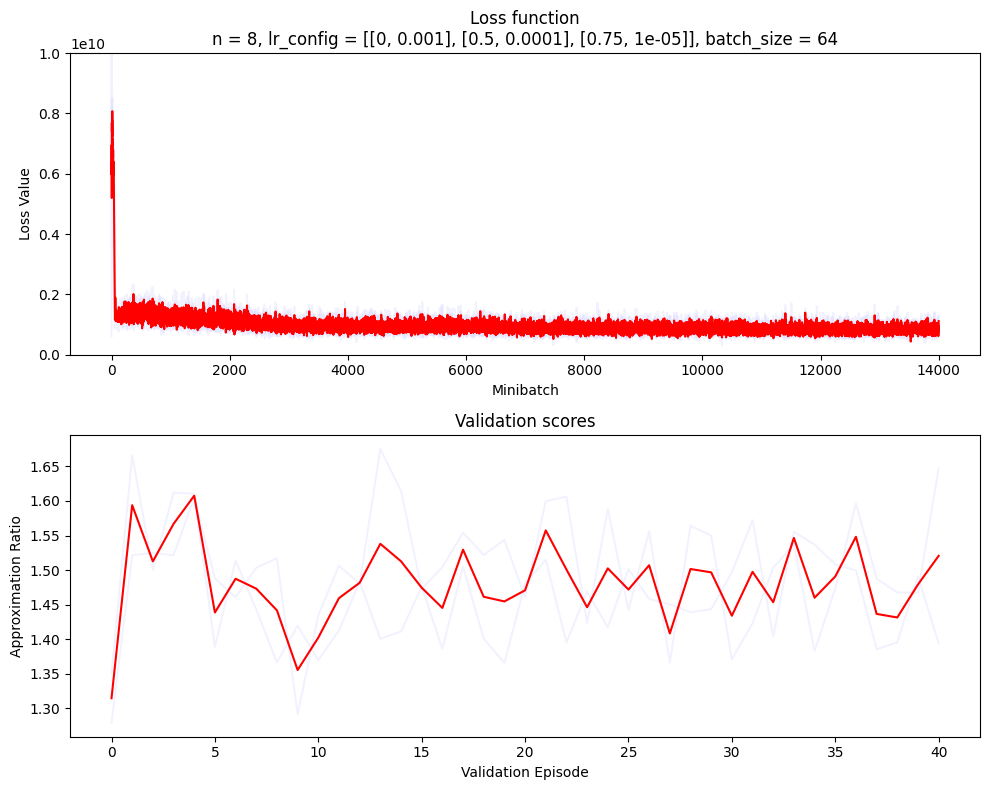

In [73]:
replay_graphs('outputs/run_1', max_loss=1e10, filename=None)

{'n': 8, 'pos_lim': 1000000.0, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.005, 'eps_end_at_episode': 0.8, 'validate_each': 50, 'print_train_metrics_each': 10, 'batch_size': 64}
Starting run #1/2...
2635283.4730495242 2287354.7671177047 1.1521096381433844
4167742.832242865 2602029.212792197 1.6017279174858017
3909800.377596047 3364776.501033825 1.1619792210254571
3264687.548539249 1949170.0217268807 1.6749116352850926
3811447.17482678 2310397.914427481 1.6496929602584325
3687645.6776191336 2840263.513749022 1.29834631884265
3703841.5526220575 2849409.8137943 1.2998627065476371
3713166.6288707936 2423223.026897205 1.5323255794681374
4607931.870881088 3224413.054532435 1.429076173849344
3023452.9347130833 2387430.9630939257 1.2664043406704093
3497176.2631398635 3015929.0369279278 1.1595684846425105
2907649.753019868 2148708.3627918214 1.3532081893337784
3873808.2719863625 2671981.194866862 1.4497887482996992
4081809.79856119

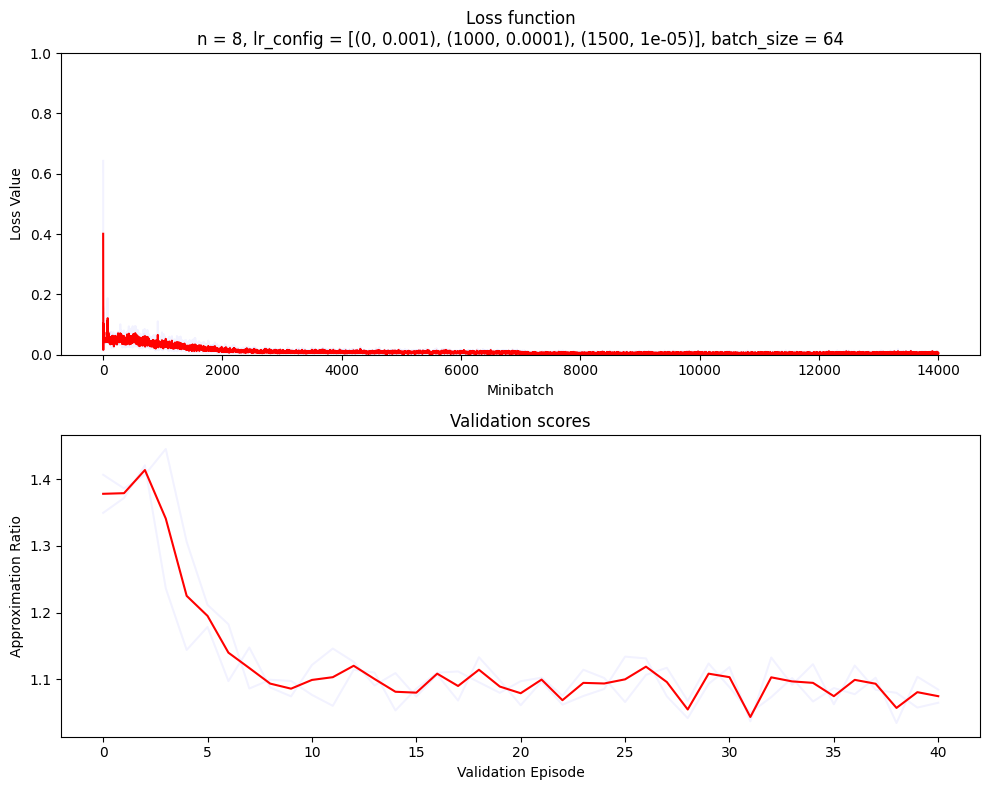

In [83]:
%%time
params = {
    'n': 8,
    'pos_lim': 1e6,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.005,
    'eps_end_at_episode': 0.8,
    'validate_each': 50,
    'print_train_metrics_each': 10,
    'batch_size': 64
}
agents = run_train(2, 2, params)

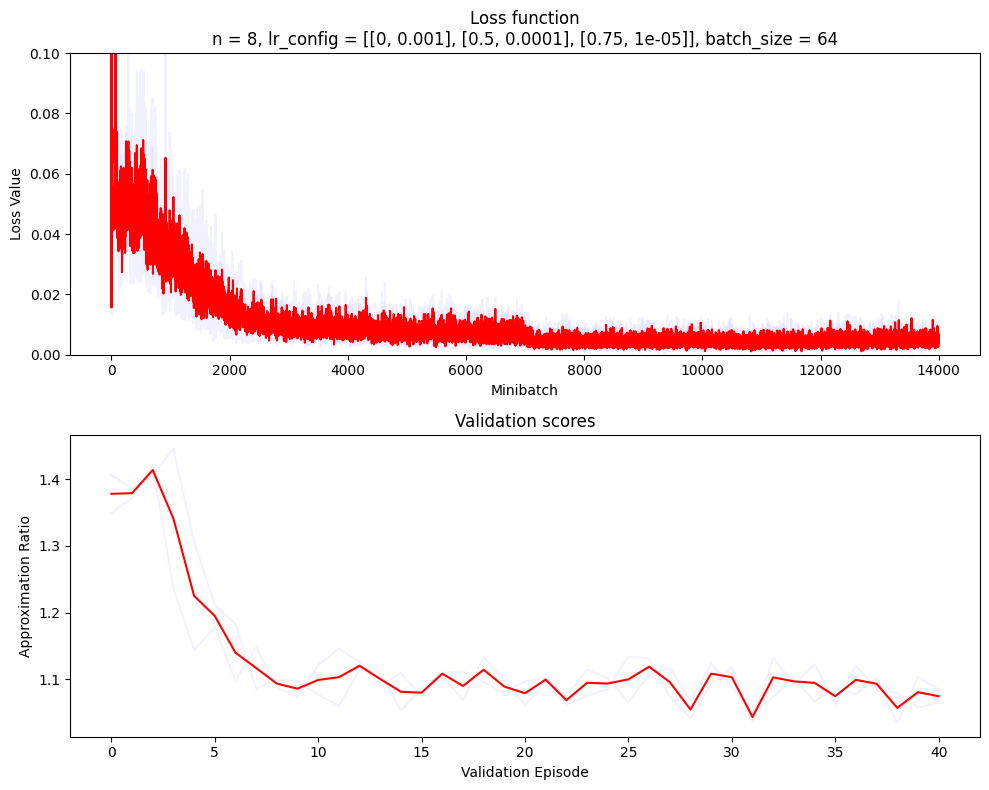

In [84]:
replay_graphs('outputs/run_2', max_loss=1e-1, filename=None)

{'n': 30, 'pos_lim': 1000000.0, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'n_episodes': 500, 'eps_start': 1.0, 'eps_end': 0.005, 'eps_end_at_episode': 1.0, 'validate_each': 50, 'print_train_metrics_each': 10, 'batch_size': 64}
Starting run #1/2...
Problem Name: 5d6f4a2c118c44b2aee4b91a9c0dbcb1
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
8283352.079609371 4833108.015448222 1.713876878632346
Finding a good tour for compression ...
linkern ...
Starting Cycle: 5458714
   0 Steps   Best: 4882875   0.00 seconds
   1 Steps   Best: 4833108   0.00 seconds
  15 Total Steps.
Best cycle length: 4833108
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4833108.0
LK Run 0: 4833108.0
LK Run from best tour: 4833108.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4833108 (from tour)
  LP Value  1: 4463437.000000  (0.00 seconds)
  LP Value  2: 4797191.000000  (0.00 seconds)
  LP Value  3: 4833108.000000  (0.00 se

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 2512b39a87844b71ad3f2dc77fcabb7d
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
10841605.702201275 4782566.767890903 2.266901065551122
linkern ...
Starting Cycle: 5508052
   0 Steps   Best: 4782566   0.00 seconds
  15 Total Steps.
Best cycle length: 4782566
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4782566.0
LK Run 0: 4782566.0
LK Run from best tour: 4782566.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4782566 (from tour)
  LP Value  1: 4654073.000000  (0.00 seconds)
  LP Value  2: 4781482.500000  (0.00 seconds)
  LP Value  3: 4782566.000000  (0.00 seconds)
New lower bound: 4782566.000000
Exact lower bound: 4782566.000000
DIFF: 0.000000
Established Bound: 4782566
Optimal tour: 4782566
Total Time to solve TSP: 0.01
Problem Name: 28fa1011f4ef405faa1796b79a3f43e5
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_da

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: f3e814d963ae457c8baad04de1f6057b
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
11511222.392798357 4165628.1748429216 2.763382114207163
linkern ...
Starting Cycle: 4930843
   0 Steps   Best: 4165629   0.00 seconds
  15 Total Steps.
Best cycle length: 4165629
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4165629.0
LK Run 0: 4174477.0
LK Run from best tour: 4165629.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4165629 (from tour)
  LP Value  1: 3569164.500000  (0.00 seconds)
  LP Value  2: 4041562.000000  (0.00 seconds)
  LP Value  3: 4118522.500000  (0.00 seconds)
  LP Value  4: 4156900.000000  (0.01 seconds)
  LP Value  5: 4165629.000000  (0.01 seconds)
New lower bound: 4165629.000000
Exact lower bound: 4165629.000000
DIFF: 0.000000
Established Bound: 4165629
Optimal tour: 4165629
Total Time to solve TSP: 0.02
10613869.48834447 4357836.213909633 2.435582

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: d616539191b541d9aafce3836cbcda21
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
11542837.38188197 4525960.281126283 2.5503620590787732
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4957997
   0 Steps   Best: 4827070   0.00 seconds
   1 Steps   Best: 4572061   0.00 seconds
   2 Steps   Best: 4525962   0.00 seconds
  15 Total Steps.
Best cycle length: 4525962
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4525962.0
LK Run 0: 4525962.0
LK Run from best tour: 4525962.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4525962 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4298662.000000  (0.00 seconds)
  LP Value  2: 4525962.000000  (0.00 seconds)
New lower bound: 4525962.000000
Exact lower bound: 4525962.000000
DIFF: 0.000000
Established Bound: 4525962
Optimal tour: 4525962
Total Time to solve TSP: 0.01
Problem Name: 5a69d28bf421475c839791b29cf207c8
P

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: a56d5fb18a0a45b494a2c7969bb16dc3
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
7391407.542203992 3414744.1715868264 2.1645567488498605
linkern ...
Starting Cycle: 3537282
   0 Steps   Best: 3414744   0.00 seconds
  15 Total Steps.
Best cycle length: 3414744
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3414744.0
LK Run 0: 3414744.0
LK Run from best tour: 3414744.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3414744 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3106504.000000  (0.00 seconds)
  LP Value  2: 3376136.000000  (0.00 seconds)
  LP Value  3: 3409029.000000  (0.00 seconds)
  LP Value  4: 3414744.000000  (0.00 seconds)
New lower bound: 3414744.000000
Exact lower bound: 3414744.000000
DIFF: 0.000000
Established Bound: 3414744
Optimal tour: 3414744
Total Time to solve TSP: 0.01
Problem Name: 5a25950bd5284ecda7fb7ca21

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


10873915.534094272linkern ...
Starting Cycle: 4975971
   0 Steps   Best: 4760408   0.00 seconds
   1 Steps   Best: 4735949   0.00 seconds
  15 Total Steps.
Best cycle length: 4735949
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4735949.0
LK Run 0: 4760408.0
LK Run from best tour: 4735949.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4735949 (from tour)
  LP Value  1: 4686112.500000  (0.00 seconds)
  LP Value  2: 4735949.000000  (0.00 seconds)
New lower bound: 4735949.000000
Exact lower bound: 4735949.000000
DIFF: 0.000000
Established Bound: 4735949
Optimal tour: 4735949
Total Time to solve TSP: 0.01
 4735950.915548829 2.296036366929732
Problem Name: 3b382fce9a3749ae80ce9ce0d2999234
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
10644074.953225318 4869254.045075231 2.1859765078371187
Finding a good tour for compression ...
linkern ...
Starting Cycle: 5643613
   0 Steps   Best: 5011426   0.00 seconds
   1 St

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


9887773.357901596Finding a good tour for compression ...
linkern ...
Starting Cycle: 5811314
   0 Steps   Best: 4670116   0.00 seconds
  15 Total Steps.
Best cycle length: 4670116
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4670116.0
LK Run 0: 4670116.0
LK Run from best tour: 4670116.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4670116 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4188686.500000  (0.00 seconds)
  LP Value  2: 4624504.000000  (0.00 seconds)
  LP Value  3: 4669660.500000  (0.00 seconds)
  LP Value  4: 4670116.000000  (0.00 seconds)
New lower bound: 4670116.000000
Exact lower bound: 4670116.000000
DIFF: 0.000000
Established Bound: 4670116
Optimal tour: 4670116
Total Time to solve TSP: 0.02
 4670116.972155441 2.1172431904501106
Problem Name: c2c3a4706dfb420eaa0cf77da560b29b
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
13573480.76961762 4485235.727374828 3.02

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 4480c8e1a2bc43c9993a15a54b8df43e
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
10397002.369900282 4833355.5791299855 2.1510940380206343
linkern ...
Starting Cycle: 5948568
   0 Steps   Best: 4881765   0.00 seconds
   2 Steps   Best: 4833357   0.00 seconds
  15 Total Steps.
Best cycle length: 4833357
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4833357.0
LK Run 0: 4833357.0
LK Run from best tour: 4833357.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4833357 (from tour)
  LP Value  1: 4459000.000000  (0.00 seconds)
  LP Value  2: 4799005.000000  (0.00 seconds)
  LP Value  3: 4831763.000000  (0.00 seconds)
  LP Value  4: 4833357.000000  (0.00 seconds)
New lower bound: 4833357.000000
Exact lower bound: 4833357.000000
DIFF: 0.000000
Established Bound: 4833357
Optimal tour: 4833357
Total Time to solve TSP: 0.01
Problem Name: a85f82543e4e472999fd77734d4cc5fa


ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: f6dadff89cca4613883f41c3262241d4
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
12664194.168649992 4585154.367784401 2.7619995212439212
linkern ...
Starting Cycle: 5687867
   0 Steps   Best: 4711498   0.00 seconds
   1 Steps   Best: 4585153   0.00 seconds
  15 Total Steps.
Best cycle length: 4585153
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4585153.0
LK Run 0: 4585153.0
LK Run from best tour: 4585153.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4585153 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4316494.000000  (0.00 seconds)
  LP Value  2: 4564116.000000  (0.00 seconds)
  LP Value  3: 4585153.000000  (0.00 seconds)
New lower bound: 4585153.000000
Exact lower bound: 4585153.000000
DIFF: 0.000000
Established Bound: 4585153
Optimal tour: 4585153
Total Time to solve TSP: 0.01
Problem Name: 393ccd3bdc3545a28baa2b4fd11b6

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
need to link an lp solver to use this function
CClp_getweight failed
find_candidate_cliques failed


Problem Name: 5c600561ffaa4af78902caa95865e9f7
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
10023702.1462162 3787774.007128711 2.646330569709617
linkern ...
Starting Cycle: 4162584
   0 Steps   Best: 3787774   0.00 seconds
  15 Total Steps.
Best cycle length: 3787774
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3787774.0
LK Run 0: 3787774.0
LK Run from best tour: 3787774.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 3787774 (from tour)
  LP Value  1: 3466936.000000  (0.00 seconds)
  LP Value  2: 3753671.000000  (0.00 seconds)
  LP Value  3: 3787774.000000  (0.00 seconds)
New lower bound: 3787774.000000
Exact lower bound: 3787774.000000
DIFF: 0.000000
Established Bound: 3787774
Optimal tour: 3787774
Total Time to solve TSP: 0.01
Problem Name: 573d5ed93bee41f89d67638806b26da3
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat 

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 2481de291c9f4f0caf2193915fe925e0
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
11603760.103084864 4231582.015224764 2.7421801258573786
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4684236
   0 Steps   Best: 4595792   0.00 seconds
   1 Steps   Best: 4231581   0.00 seconds
  15 Total Steps.
Best cycle length: 4231581
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4231581.0
LK Run 0: 4231581.0
LK Run from best tour: 4231581.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4231581 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4007576.000000  (0.00 seconds)
  LP Value  2: 4203545.500000  (0.00 seconds)
  LP Value  3: 4231581.000000  (0.00 seconds)
New lower bound: 4231581.000000
Exact lower bound: 4231581.000000
DIFF: 0.000000
Established Bound: 4231581
Optimal tour: 4231581
Total Time to solve TSP: 0.00
Problem Name: b65e0a770adb46d08e9f85c4c9dd3

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 703f539a5c5645acb8b3eae9936e19b4
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
14042992.265379881 4986992.889589096 2.815923859586043
linkern ...
Starting Cycle: 5940208
   0 Steps   Best: 4995131   0.00 seconds
   2 Steps   Best: 4993789   0.00 seconds
   6 Steps   Best: 4986993   0.00 seconds
  15 Total Steps.
Best cycle length: 4986993
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4986993.0
LK Run 0: 4986993.0
LK Run from best tour: 4986993.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4986993 (from tour)
  LP Value  1: 4678138.750000  (0.00 seconds)
  LP Value  2: 4889303.625000  (0.00 seconds)
  LP Value  3: 4957066.285714  (0.00 seconds)
  LP Value  4: 4964644.000000  (0.01 seconds)
  LP Value  5: 4973405.000000  (0.01 seconds)
  LP Value  6: 4980455.600000  (0.01 seconds)
  LP Value  7: 4985852.000000  (0.01 seconds)
  LP Value  8: 4986993.000000

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed


Problem Name: b953e6fabfa84576b026418fe2c295b0
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
11311195.866888637 4629663.065617093 2.443200662029377
linkern ...
Starting Cycle: 5262625
   0 Steps   Best: 4629665   0.00 seconds
  15 Total Steps.
Best cycle length: 4629665
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4629665.0
LK Run 0: 4629665.0
LK Run from best tour: 4629665.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4629665 (from tour)
  LP Value  1: 4335882.500000  (0.00 seconds)
  LP Value  2: 4625802.000000  (0.00 seconds)
  LP Value  3: 4629665.000000  (0.00 seconds)
New lower bound: 4629665.000000
Exact lower bound: 4629665.000000
DIFF: 0.000000
Established Bound: 4629665
Optimal tour: 4629665
Total Time to solve TSP: 0.01
Problem Name: 07204a46534a43c48ae0cec435b64f40
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_da

No warmstart, stumbling on anyway


Problem Name: 5f487c5d65ad4782b72d19e19768dfde
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
8576855.488402138 4695886.657110799 1.826461351109175
linkern ...
Starting Cycle: 5618152
   0 Steps   Best: 4736012   0.00 seconds
   1 Steps   Best: 4735195   0.00 seconds
   2 Steps   Best: 4695888   0.00 seconds
  15 Total Steps.
Best cycle length: 4695888
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4695888.0
LK Run 0: 4695888.0
LK Run from best tour: 4695888.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4695888 (from tour)
  LP Value  1: 4325416.500000  (0.00 seconds)
  LP Value  2: 4646515.500000  (0.00 seconds)
  LP Value  3: 4695888.000000  (0.00 seconds)
New lower bound: 4695888.000000
Exact lower bound: 4695888.000000
DIFF: 0.000000
Established Bound: 4695888
Optimal tour: 4695888
Total Time to solve TSP: 0.01
Problem Name: 43d3e07630c94e2da9566c1378c0309f
Problem

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


linkern ...
Starting Cycle: 4925117
   0 Steps   Best: 4528432   0.00 seconds
  15 Total Steps.
Best cycle length: 4528432
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4528432.0
LK Run 0: 4528432.0
LK Run from best tour: 4528432.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4528432 (from tour)
  LP Value  1: 4075651.500000  (0.00 seconds)
  LP Value  2: 4528432.000000  (0.00 seconds)
New lower bound: 4528432.000000
Exact lower bound: 4528432.000000
DIFF: 0.000000
Established Bound: 4528432
Optimal tour: 4528432
Total Time to solve TSP: 0.02
8370047.4868970215 4528428.68380932 1.8483337314823574
Problem Name: 4bbf21c2359b4966b8105ca2274710c9
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
7746570.503652217 4561996.473940948 1.6980658682886327
linkern ...
Starting Cycle: 5017629
   0 Steps   Best: 4593616   0.00 seconds
   1 Steps   Best: 4592357   0.00 seconds
   2 Ste

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


10682423.546510085Problem Name: be7554f89a644c6c8b26fd57b7c6afed
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 5211273
   0 Steps   Best: 4541581   0.00 seconds
  15 Total Steps.
Best cycle length: 4541581
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4541581.0
LK Run 0: 4541581.0
LK Run from best tour: 4541581.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4541581 (from tour)
  LP Value  1: 4473838.500000  (0.00 seconds)
  LP Value  2: 4541581.000000  (0.00 seconds)
New lower bound: 4541581.000000
Exact lower bound: 4541581.000000
DIFF: 0.000000
Established Bound: 4541581
Optimal tour: 4541581
Total Time to solve TSP: 0.00
 4541580.735096603 2.352137762069942
Problem Name: 339eac39f8c04472b1f0786d8c1875cc
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...


ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 689fe4ee9d294919b8c1017ec96f59d0
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
10035188.17057188 5073865.705928384 1.9778190342812205
linkern ...
Starting Cycle: 5913800
   0 Steps   Best: 5073868   0.00 seconds
  15 Total Steps.
Best cycle length: 5073868
Lin-Kernighan Running Time: 0.00
LK Initial Run: 5073868.0
LK Run 0: 5073868.0
LK Run from best tour: 5073868.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 5073868 (from tour)
  LP Value  1: 4548002.000000  (0.00 seconds)
  LP Value  2: 4853927.500000  (0.00 seconds)
  LP Value  3: 4957316.250000  (0.00 seconds)
  LP Value  4: 4973250.500000  (0.00 seconds)
  LP Value  5: 5023609.750000  (0.00 seconds)
  LP Value  6: 5065092.142857  (0.01 seconds)
  LP Value  7: 5073868.000000  (0.01 seconds)
New lower bound: 5073868.000000
Exact lower bound: 5073868.000000
DIFF: 0.000000
Established Bound: 5073868
Optim

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 2ec9a93d35294ae4a65d8b3c14d421be
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
10506572.742532514 4800595.459431339 2.1885978169418765
linkern ...
Starting Cycle: 5381868
   0 Steps   Best: 4800597   0.00 seconds
  15 Total Steps.
Best cycle length: 4800597
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4800597.0
LK Run 0: 4800597.0
LK Run from best tour: 4800597.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4800597 (from tour)
  LP Value  1: 4680607.000000  (0.00 seconds)
  LP Value  2: 4782165.000000  (0.00 seconds)
  LP Value  3: 4787696.000000  (0.00 seconds)
  LP Value  4: 4791381.000000  (0.00 seconds)
  LP Value  5: 4794892.923077  (0.01 seconds)
  LP Value  6: 4797126.428571  (0.01 seconds)
  LP Value  7: 4799413.666667  (0.01 seconds)
  LP Value  8: 4800597.000000  (0.01 seconds)
recomputing rownorms ...
  LP Value  9: 4800597.000000  (0.02 seco

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 468bb07619824390afe54159f3924cbc
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
11038314.404469404 4390675.56774245 2.5140355360268547
linkern ...
Starting Cycle: 5259200
   0 Steps   Best: 4397637   0.00 seconds
   7 Steps   Best: 4390675   0.00 seconds
  15 Total Steps.
Best cycle length: 4390675
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4390675.0
LK Run 0: 4390675.0
LK Run from best tour: 4390675.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4390675 (from tour)
  LP Value  1: 3928515.750000  (0.00 seconds)
  LP Value  2: 4326162.000000  (0.00 seconds)
  LP Value  3: 4390675.000000  (0.00 seconds)
New lower bound: 4390675.000000
Exact lower bound: 4390675.000000
DIFF: 0.000000
Established Bound: 4390675
Optimal tour: 4390675
Total Time to solve TSP: 0.01
Problem Name: a60902c3f4124a1687ebec7b5fafaade
Problem Type: TSP
Number of Nodes: 30
Rounded Eu

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 04765f4585324cff8e793689f32bab3b
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
7752665.037323559 4590327.391299942 1.6889133119387525
linkern ...
Starting Cycle: 5090855
   0 Steps   Best: 4590326   0.00 seconds
  15 Total Steps.
Best cycle length: 4590326
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4590326.0
LK Run 0: 4590326.0
LK Run from best tour: 4590326.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4590326 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4309548.000000  (0.00 seconds)
  LP Value  2: 4590326.000000  (0.00 seconds)
New lower bound: 4590326.000000
Exact lower bound: 4590326.000000
DIFF: 0.000000
Established Bound: 4590326
Optimal tour: 4590326
Total Time to solve TSP: 0.01
Problem Name: 8027e8683368483c8493b39f169c7a95
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_sol

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 43375a12bbee4f1eaeb8391e315ce1c3
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
10589672.316189097 4486591.23896459 2.360293539607804
linkern ...
Starting Cycle: 5356420
   0 Steps   Best: 4486591   0.00 seconds
  15 Total Steps.
Best cycle length: 4486591
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4486591.0
LK Run 0: 4486591.0
LK Run from best tour: 4486591.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4486591 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4328047.000000  (0.00 seconds)
  LP Value  2: 4465131.000000  (0.00 seconds)
  LP Value  3: 4486591.000000  (0.00 seconds)
New lower bound: 4486591.000000
Exact lower bound: 4486591.000000
DIFF: 0.000000
Established Bound: 4486591
Optimal tour: 4486591
Total Time to solve TSP: 0.01
Problem Name: fffe2a03f6a54d45a2250c36fbfe2e64
Problem Type: TSP
Number of Nodes: 30
Ro

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 79f9d61388574cb7b734b30aacbc2a2f
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
11981302.941466037 5056918.6403978495 2.369289243799939
linkern ...
Starting Cycle: 6138111
   0 Steps   Best: 5056919   0.00 seconds
  15 Total Steps.
Best cycle length: 5056919
Lin-Kernighan Running Time: 0.00
LK Initial Run: 5056919.0
LK Run 0: 5056919.0
LK Run from best tour: 5056919.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 5056919 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4767009.500000  (0.00 seconds)
  LP Value  2: 4924014.000000  (0.00 seconds)
  LP Value  3: 5056919.000000  (0.00 seconds)
New lower bound: 5056919.000000
Exact lower bound: 5056919.000000
DIFF: 0.000000
Established Bound: 5056919
Optimal tour: 5056919
Total Time to solve TSP: 0.02
Problem Name: a8d7f4f8b32d4fab85a7f2c317299de6
Problem Type: TSP
Number of Nodes: 30


ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 5c5d3aca35c94cfd81b9e0b6df418132
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
14088364.772664174 4751828.226686873 2.9648303980228334
linkern ...
Starting Cycle: 5554556
   0 Steps   Best: 5184344   0.00 seconds
   1 Steps   Best: 4751827   0.00 seconds
  15 Total Steps.
Best cycle length: 4751827
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4751827.0
LK Run 0: 4751827.0
LK Run from best tour: 4751827.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4751827 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4199393.000000  (0.00 seconds)
  LP Value  2: 4751827.000000  (0.00 seconds)
New lower bound: 4751827.000000
Exact lower bound: 4751827.000000
DIFF: 0.000000
Established Bound: 4751827
Optimal tour: 4751827
Total Time to solve TSP: 0.01
Problem Name: 5a9ffc3209354a64af9fa34b5a464c3c
Problem Type: TSP
Number of Nodes: 30
Roun

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 1c9e2c2ccd1f4e9ab13d70b7c91dc20c
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
12997787.317738751 4455614.20400875 2.9171707249798566
linkern ...
Starting Cycle: 5208848
   0 Steps   Best: 4455615   0.00 seconds
  15 Total Steps.
Best cycle length: 4455615
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4455615.0
LK Run 0: 4455615.0
LK Run from best tour: 4455615.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4455615 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4057047.000000  (0.00 seconds)
  LP Value  2: 4422500.000000  (0.00 seconds)
  LP Value  3: 4455615.000000  (0.00 seconds)
New lower bound: 4455615.000000
Exact lower bound: 4455615.000000
DIFF: 0.000000
Established Bound: 4455615
Optimal tour: 4455615
Total Time to solve TSP: 0.02
Problem Name: 27482dc8227649dda3033c71c24129df
Problem Type: TSP
Number of Nodes: 30
R

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 0e55ef0455d84017898a87e9632b9063
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
15037982.647964297 4583590.35724017 3.2808304136975344
linkern ...
Starting Cycle: 5334872
   0 Steps   Best: 4583589   0.00 seconds
  15 Total Steps.
Best cycle length: 4583589
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4583589.0
LK Run 0: 4583589.0
LK Run from best tour: 4583589.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4583589 (from tour)
  LP Value  1: 4094200.000000  (0.00 seconds)
  LP Value  2: 4583589.000000  (0.00 seconds)
New lower bound: 4583589.000000
Exact lower bound: 4583589.000000
DIFF: 0.000000
Established Bound: 4583589
Optimal tour: 4583589
Total Time to solve TSP: 0.01
Problem Name: a3dbe7b344c645f6a30ddcc1f9bb10e8
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...


ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


13506285.395724524Problem Name: f4dc7f34bc2f4324a10af784f8c62b7c
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4916232
   0 Steps   Best: 4749744   0.00 seconds
  15 Total Steps.
Best cycle length: 4749744
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4749744.0
LK Run 0: 4749744.0
LK Run from best tour: 4749744.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4749744 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4645188.000000  (0.00 seconds)
  LP Value  2: 4749744.000000  (0.00 seconds)
New lower bound: 4749744.000000
Exact lower bound: 4749744.000000
DIFF: 0.000000
Established Bound: 4749744
Optimal tour: 4749744
Total Time to solve TSP: 0.00
 4749742.634812027 2.843582575766032
Problem Name: ba7f139e113446ef9a47d3160935f1b7
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_sol

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 4389fd532c804d6d886b8faecbdb0df7
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
10835129.579198672 4396138.01163181 2.464692771366557
linkern ...
Starting Cycle: 4721184
   0 Steps   Best: 4396138   0.00 seconds
  15 Total Steps.
Best cycle length: 4396138
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4396138.0
LK Run 0: 4396138.0
LK Run from best tour: 4396138.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4396138 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4034749.500000  (0.00 seconds)
  LP Value  2: 4325737.000000  (0.00 seconds)
  LP Value  3: 4396109.000000  (0.00 seconds)
  LP Value  4: 4396138.000000  (0.00 seconds)
New lower bound: 4396138.000000
Exact lower bound: 4396138.000000
DIFF: 0.000000
Established Bound: 4396138
Optimal tour: 4396138
Total Time to solve TSP: 0.01
Problem Name: a23a0fc1296d4883ad15ccbc3b0

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: d3e9db3a65cc412c88549d3f41184bb1
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
13061926.049494088 4743218.544476069 2.7538107146055815
linkern ...
Starting Cycle: 5168471
   0 Steps   Best: 4743218   0.00 seconds
  15 Total Steps.
Best cycle length: 4743218
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4743218.0
LK Run 0: 4743218.0
LK Run from best tour: 4743218.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4743218 (from tour)
  LP Value  1: 4641745.000000  (0.00 seconds)
  LP Value  2: 4725803.000000  (0.00 seconds)
  LP Value  3: 4743218.000000  (0.00 seconds)
New lower bound: 4743218.000000
Exact lower bound: 4743218.000000
DIFF: 0.000000
Established Bound: 4743218
Optimal tour: 4743218
Total Time to solve TSP: 0.01
Problem Name: a2b2498bbe57463ea3329bd1eb72c7b0
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_d

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: fd8a22c8e0604449b280f8c9c27ad15a
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
10582997.995060671 4516650.297808743 2.3431076787580882
linkern ...
Starting Cycle: 5020497
   0 Steps   Best: 4516650   0.00 seconds
  15 Total Steps.
Best cycle length: 4516650
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4516650.0
LK Run 0: 4516650.0
LK Run from best tour: 4516650.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4516650 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4437149.500000  (0.00 seconds)
  LP Value  2: 4516650.000000  (0.00 seconds)
New lower bound: 4516650.000000
Exact lower bound: 4516650.000000
DIFF: 0.000000
Established Bound: 4516650
Optimal tour: 4516650
Total Time to solve TSP: 0.00
Problem Name: e98b77989b0c4d759a166b71a7f991ef
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_so

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: c48fca2f3582435d83d0d065c1e7984e
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
11382130.115419284 4039495.88291163 2.8177105374879483
linkern ...
Starting Cycle: 4288420
   0 Steps   Best: 4044043   0.00 seconds
  15 Total Steps.
Best cycle length: 4044043
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4044043.0
LK Run 0: 4044043.0
LK Run from best tour: 4039494.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4039494 (from tour)
  LP Value  1: 3539182.000000  (0.00 seconds)
  LP Value  2: 4012437.500000  (0.00 seconds)
  LP Value  3: 4039494.000000  (0.00 seconds)
New lower bound: 4039494.000000
Exact lower bound: 4039494.000000
DIFF: 0.000000
Established Bound: 4039494
Optimal tour: 4039494
Total Time to solve TSP: 0.01
Problem Name: afb5f066074c43debbf49e91fadeef42
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_da

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 4bba89c51fbe4c768e044cd65d74f2dc
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
10459400.164186869 4931861.352671469 2.1207814689521367
Finding a good tour for compression ...
linkern ...
Starting Cycle: 6029238
   0 Steps   Best: 4931859   0.00 seconds
  15 Total Steps.
Best cycle length: 4931859
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4931859.0
LK Run 0: 4931859.0
LK Run from best tour: 4931859.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4931859 (from tour)
  LP Value  1: 4609885.000000  (0.00 seconds)
  LP Value  2: 4902228.000000  (0.00 seconds)
  LP Value  3: 4931859.000000  (0.00 seconds)
New lower bound: 4931859.000000
Exact lower bound: 4931859.000000
DIFF: 0.000000
Established Bound: 4931859
Optimal tour: 4931859
Total Time to solve TSP: 0.01
Problem Name: 8bd728572d214649b3429e22d9b10aa2
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_d

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 0f44d6ebb3174be09043ac4648300a04
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
13404482.409244712 4745080.02048379 2.824922309292909
linkern ...
Starting Cycle: 5579952
   0 Steps   Best: 4745078   0.00 seconds
  15 Total Steps.
Best cycle length: 4745078
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4745078.0
LK Run 0: 4745078.0
LK Run from best tour: 4745078.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4745078 (from tour)
  LP Value  1: 4676511.000000  (0.00 seconds)
  LP Value  2: 4737942.000000  (0.00 seconds)
  LP Value  3: 4745078.000000  (0.00 seconds)
New lower bound: 4745078.000000
Exact lower bound: 4745078.000000
DIFF: 0.000000
Established Bound: 4745078
Optimal tour: 4745078
Total Time to solve TSP: 0.01
Problem Name: 4df5615e4d8343eea923e4988599a3a7
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


11319477.763660436Finding a good tour for compression ...
linkern ...
Starting Cycle: 4946056
   0 Steps   Best: 4304119   0.00 seconds
  15 Total Steps.
Best cycle length: 4304119
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4304119.0
LK Run 0: 4304119.0
LK Run from best tour: 4304119.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4304119 (from tour)
  LP Value  1: 4224860.000000  (0.00 seconds)
  LP Value  2: 4282955.000000  (0.00 seconds)
  LP Value  3: 4297888.000000  (0.00 seconds)
  LP Value  4: 4304119.000000  (0.00 seconds)
New lower bound: 4304119.000000
Exact lower bound: 4304119.000000
DIFF: 0.000000
Established Bound: 4304119
Optimal tour: 4304119
Total Time to solve TSP: 0.01
 4304120.53938796 2.6299165323260327
Problem Name: e73bbae61b904cf19a823d0dcef7fe5e
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
8126262.697936614 4512941.435625149 1.8006576894146

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


CPU times: user 59min 23s, sys: 27min 48s, total: 1h 27min 11s
Wall time: 29min 22s


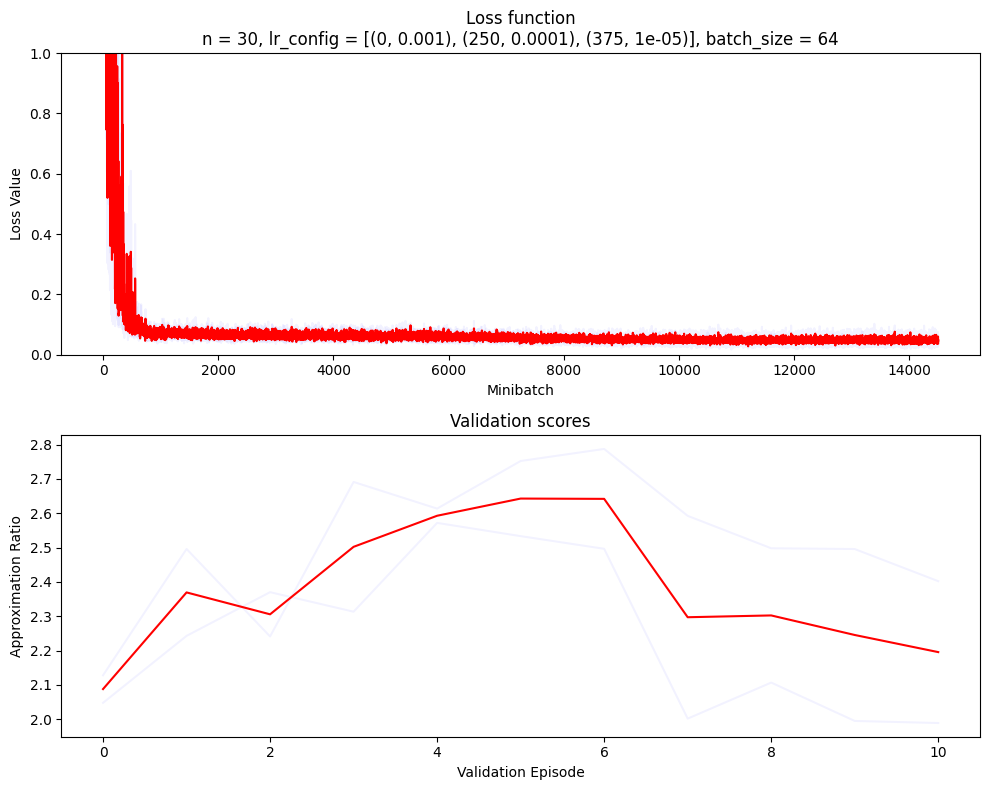

In [14]:
%%time
params = {
    'n': 30,
    'pos_lim': 1e6,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    # 'n': [3, 4, 5],
    'n_episodes': 500,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.005,
    'eps_end_at_episode': 1.0,
    'validate_each': 50,
    'print_train_metrics_each': 10,
    'batch_size': 64
}
agents = run_train(4, 2, params)

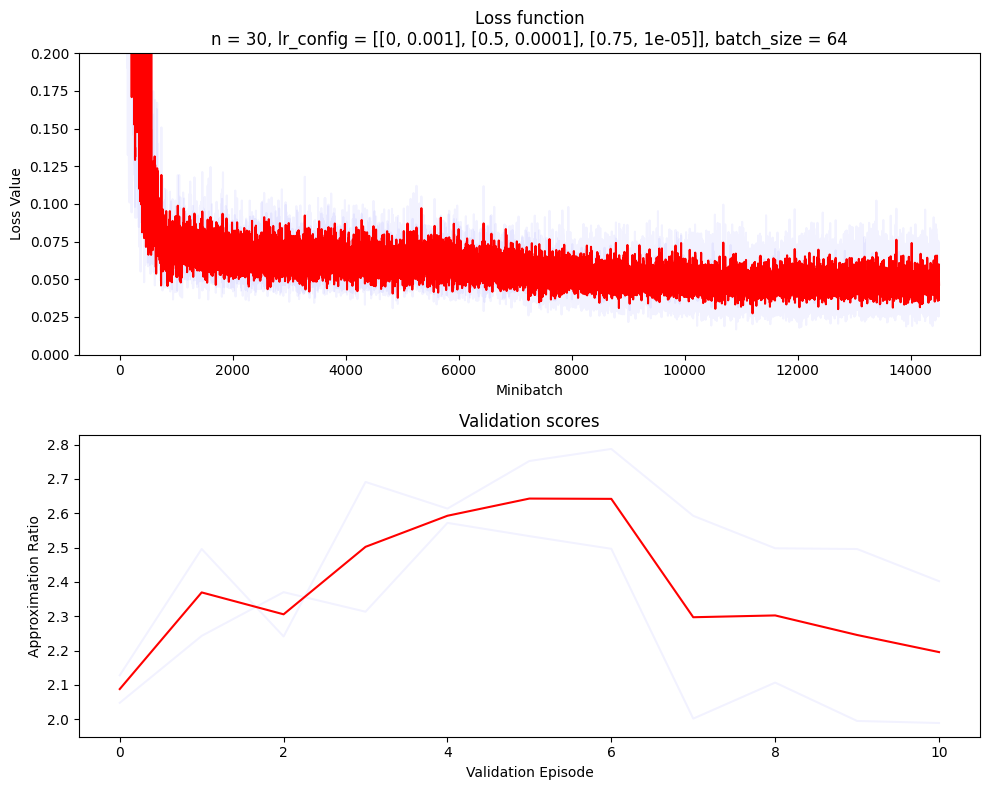

In [16]:
replay_graphs('outputs/run_4', max_loss=2e-1, filename=None)

{'n': 30, 'pos_lim': 1000000.0, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'n_episodes': 500, 'eps_start': 1.0, 'eps_end': 0.005, 'eps_end_at_episode': 1.0, 'validate_each': 50, 'print_train_metrics_each': 10, 'batch_size': 64}
Starting run #1/2...
Problem Name: 31fdee5b95d0406c8ec615452282d67a
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
7447071.599354209 4702681.315121265 1.583579898431237
Finding a good tour for compression ...
linkern ...
Starting Cycle: 5155105
   0 Steps   Best: 4705919   0.00 seconds
   3 Steps   Best: 4702682   0.00 seconds
  15 Total Steps.
Best cycle length: 4702682
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4702682.0
LK Run 0: 4702682.0
LK Run from best tour: 4702682.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4702682 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4416220.500000  (0.00 seconds)
  LP Value  2: 4631433.000000  (0.

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


9507479.339945277Problem Name: 24de89fbd3024dfb8bcdf07f3cc0c7ec
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 4387799.209710673 2.1667990911945556
linkern ...
Starting Cycle: 5325730
   0 Steps   Best: 4464715   0.00 seconds
   1 Steps   Best: 4405608   0.00 seconds
   2 Steps   Best: 4387803   0.00 seconds
  15 Total Steps.
Best cycle length: 4387803
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4387803.0
LK Run 0: 4387803.0
LK Run from best tour: 4387803.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4387803 (from tour)
  LP Value  1: 4129360.500000  (0.00 seconds)
  LP Value  2: 4337902.500000  (0.00 seconds)
  LP Value  3: 4361550.500000  (0.00 seconds)
  LP Value  4: 4366528.250000  (0.00 seconds)
  LP Value  5: 4376647.000000  (0.01 seconds)
  LP Value  6: 4385365.894737  (0.01 seconds)
  LP Value  7: 4387803.000000  (0.01 seconds)
New lower bound: 4387803.0000

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: a5002e8dab3742dbb8be2131d8a71168
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
8489556.095257089 4991198.622351996 1.7009052809957235
linkern ...
Starting Cycle: 5836943
   0 Steps   Best: 5027475   0.00 seconds
   6 Steps   Best: 5016835   0.00 seconds
   7 Steps   Best: 4991199   0.00 seconds
  15 Total Steps.
Best cycle length: 4991199
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4991199.0
LK Run 0: 4991199.0
LK Run from best tour: 4991199.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4991199 (from tour)
  LP Value  1: 4493303.000000  (0.00 seconds)
  LP Value  2: 4941958.000000  (0.00 seconds)
  LP Value  3: 4991199.000000  (0.00 seconds)
New lower bound: 4991199.000000
Exact lower bound: 4991199.000000
DIFF: 0.000000
Established Bound: 4991199
Optimal tour: 4991199
Total Time to solve TSP: 0.01
8988126.39584297 4598220.836084843 1.9546965481318452

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 44dc8032ff3f41eba877048e5ee2c827
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
10599695.139982233 4705074.343339032 2.252822031385797
Finding a good tour for compression ...
linkern ...
Starting Cycle: 5596954
   0 Steps   Best: 4705075   0.00 seconds
  15 Total Steps.
Best cycle length: 4705075
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4705075.0
LK Run 0: 4705075.0
LK Run from best tour: 4705075.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4705075 (from tour)
  LP Value  1: 4230311.000000  (0.00 seconds)
  LP Value  2: 4447171.500000  (0.00 seconds)
  LP Value  3: 4669982.000000  (0.00 seconds)
  LP Value  4: 4699440.500000  (0.00 seconds)
  LP Value  5: 4705075.000000  (0.00 seconds)
New lower bound: 4705075.000000
Exact lower bound: 4705075.000000
DIFF: 0.000000
Established Bound: 4705075
Optimal tour: 4705075
Total Time to solve TSP: 0.01
Problem Name: af719b3cded54972aa241ab829c16fc

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


10281308.44752117Problem Name: adc2a70d7ae140d185a7444d13e5e347
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4716998
   0 Steps   Best: 4543632   0.00 seconds
   1 Steps   Best: 4425438   0.00 seconds
  15 Total Steps.
Best cycle length: 4425438
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4425438.0
LK Run 0: 4425438.0
LK Run from best tour: 4425438.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4425438 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4376888.500000  (0.00 seconds)
  LP Value  2: 4425438.000000  (0.00 seconds)
New lower bound: 4425438.000000
Exact lower bound: 4425438.000000
DIFF: 0.000000
Established Bound: 4425438
Optimal tour: 4425438
Total Time to solve TSP: 0.01
 4425438.549119986 2.3232292875393434
Problem Name: 5e9c9842a8bd46469d3aed49e36d5310
Problem Type: TSP
Number of Nodes: 30
Round

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 1cff1b28b1e34905a04984a56c045f75
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
13003495.69465252 4786785.063443647 2.7165405428289096
linkern ...
Starting Cycle: 5852283
   0 Steps   Best: 4786788   0.00 seconds
  15 Total Steps.
Best cycle length: 4786788
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4786788.0
LK Run 0: 4786788.0
LK Run from best tour: 4786788.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4786788 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3870505.000000  (0.00 seconds)
  LP Value  2: 4705632.000000  (0.00 seconds)
  LP Value  3: 4786788.000000  (0.00 seconds)
New lower bound: 4786788.000000
Exact lower bound: 4786788.000000
DIFF: 0.000000
Established Bound: 4786788
Optimal tour: 4786788
Total Time to solve TSP: 0.01
Problem Name: 0af7662b593a49f0988ff6d3c41ba425
Problem Type: TSP
Number of Nodes: 30
R

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: ab40d6099b7a449b888f77fee442902c
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
10254910.34885087 4364328.201189962 2.349711084068976
linkern ...
Starting Cycle: 4808651
   0 Steps   Best: 4364327   0.00 seconds
  15 Total Steps.
Best cycle length: 4364327
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4364327.0
LK Run 0: 4364327.0
LK Run from best tour: 4364327.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4364327 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4219408.000000  (0.00 seconds)
  LP Value  2: 4329278.000000  (0.00 seconds)
  LP Value  3: 4364327.000000  (0.00 seconds)
New lower bound: 4364327.000000
Exact lower bound: 4364327.000000
DIFF: 0.000000
Established Bound: 4364327
Optimal tour: 4364327
Total Time to solve TSP: 0.01
Problem Name: 9ac54f661f6148ae9bdb9249ddf6a6ce
Problem Type: TSP
Number of Nodes: 30
Ro

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


linkern ...
Starting Cycle: 5169920
   0 Steps   Best: 4386925   0.00 seconds
  15 Total Steps.
Best cycle length: 4386925
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4386925.0
LK Run 0: 4386925.0
LK Run from best tour: 4386925.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4386925 (from tour)
  LP Value  1: 4180349.500000  (0.00 seconds)
  LP Value  2: 4321064.000000  (0.00 seconds)
  LP Value  3: 4360675.000000  (0.00 seconds)
  LP Value  4: 4381900.500000  (0.00 seconds)
  LP Value  5: 4386925.000000  (0.00 seconds)
New lower bound: 4386925.000000
Exact lower bound: 4386925.000000
DIFF: 0.000000
Established Bound: 4386925
Optimal tour: 4386925
Total Time to solve TSP: 0.01
11637773.078555375 4386922.786159776 2.652832895821913
Problem Name: 898d8b51449647beba883c730abd7134
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
12250311.406345818 5038638.492065947 2.431274

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


12548788.93405236Problem Name: e9c1a2be1f2543a69a2437d87456da06
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 5490448
   0 Steps   Best: 4975687   0.00 seconds
  15 Total Steps.
Best cycle length: 4975687
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4975687.0
LK Run 0: 4975687.0
LK Run from best tour: 4975687.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4975687 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4932216.000000  (0.00 seconds)
  LP Value  2: 4975687.000000  (0.00 seconds)
New lower bound: 4975687.000000
Exact lower bound: 4975687.000000
DIFF: 0.000000
Established Bound: 4975687
Optimal tour: 4975687
Total Time to solve TSP: 0.00
 4975689.443943387 2.522020129155621
Problem Name: 6c404bb0a2ef49fe8f827c0bad04a04f
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solv

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 3649774d68b84cc497967c9a570a7f2b
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
12153777.339168914 4440629.599762525 2.7369491343792487
linkern ...
Starting Cycle: 5243096
   0 Steps   Best: 4449389   0.00 seconds
   1 Steps   Best: 4440629   0.00 seconds
  15 Total Steps.
Best cycle length: 4440629
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4440629.0
LK Run 0: 4440629.0
LK Run from best tour: 4440629.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4440629 (from tour)
  LP Value  1: 4137295.000000  (0.00 seconds)
  LP Value  2: 4440629.000000  (0.00 seconds)
New lower bound: 4440629.000000
Exact lower bound: 4440629.000000
DIFF: 0.000000
Established Bound: 4440629
Optimal tour: 4440629
Total Time to solve TSP: 0.01
Problem Name: d05395ed18844ec09f9779ddc14d8109
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat .

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: b38e3ec0ace1440b9b90007932fd301d
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
11429545.185775159 4505931.289033118 2.536555586986705
linkern ...
Starting Cycle: 4863420
   0 Steps   Best: 4508506   0.00 seconds
   1 Steps   Best: 4505927   0.00 seconds
  15 Total Steps.
Best cycle length: 4505927
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4505927.0
LK Run 0: 4505927.0
LK Run from best tour: 4505927.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4505927 (from tour)
  LP Value  1: 3951354.000000  (0.00 seconds)
  LP Value  2: 4470935.500000  (0.00 seconds)
  LP Value  3: 4498796.000000  (0.00 seconds)
  LP Value  4: 4505927.000000  (0.00 seconds)
New lower bound: 4505927.000000
Exact lower bound: 4505927.000000
DIFF: 0.000000
Established Bound: 4505927
Optimal tour: 4505927
Total Time to solve TSP: 0.01
Problem Name: 031ab214557e410aa31f5fb6a4dcd031
Pr

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 9d65763dffe34afd970921eca7d513e5
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
9976784.507431015 4357197.035012804 2.2897253503252917
linkern ...
Starting Cycle: 5115792
   0 Steps   Best: 4357196   0.00 seconds
  15 Total Steps.
Best cycle length: 4357196
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4357196.0
LK Run 0: 4357196.0
LK Run from best tour: 4357196.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4357196 (from tour)
  LP Value  1: 4303384.500000  (0.00 seconds)
  LP Value  2: 4334594.500000  (0.00 seconds)
  LP Value  3: 4350070.250000  (0.00 seconds)
  LP Value  4: 4357196.000000  (0.00 seconds)
New lower bound: 4357196.000000
Exact lower bound: 4357196.000000
DIFF: 0.000000
Established Bound: 4357196
Optimal tour: 4357196
Total Time to solve TSP: 0.01
Problem Name: 35628195ed71462891657d7e7efa8acf
Problem Type: TSP
Number of Nodes: 30
Rounde

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: dfbaa7c35d7f4a81a78f824ae2c91b30
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
12582161.786459742 4481656.673399927 2.807480068952831
linkern ...
Starting Cycle: 4786138
   0 Steps   Best: 4481656   0.00 seconds
  15 Total Steps.
Best cycle length: 4481656
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4481656.0
LK Run 0: 4481656.0
LK Run from best tour: 4481656.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4481656 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4204427.000000  (0.00 seconds)
  LP Value  2: 4458479.500000  (0.00 seconds)
  LP Value  3: 4481656.000000  (0.00 seconds)
New lower bound: 4481656.000000
Exact lower bound: 4481656.000000
DIFF: 0.000000
Established Bound: 4481656
Optimal tour: 4481656
Total Time to solve TSP: 0.01
Problem Name: b7d190ae0aee477eab5e4ccf64e18e7d
Problem Type: TSP
Number of Nodes: 30
R

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: d1f1d82e9c0c42e7a8c15500b1279c9a
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
12059056.558522953 4658753.774691963 2.588472613434115
Finding a good tour for compression ...
linkern ...
Starting Cycle: 6105056
   0 Steps   Best: 4658758   0.00 seconds
  15 Total Steps.
Best cycle length: 4658758
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4658758.0
LK Run 0: 4658758.0
LK Run from best tour: 4658758.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4658758 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4538480.000000  (0.00 seconds)
  LP Value  2: 4658758.000000  (0.00 seconds)
New lower bound: 4658758.000000
Exact lower bound: 4658758.000000
DIFF: 0.000000
Established Bound: 4658758
Optimal tour: 4658758
Total Time to solve TSP: 0.01
Problem Name: 1b342328e1d741f7ad9df51c8a0dde75
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_sol

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: d5492fdbd2814c369676d3ac027a44e0
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
12246615.045856368 5106915.98373702 2.398045138172574
linkern ...
Starting Cycle: 6418830
   0 Steps   Best: 5164512   0.00 seconds
   3 Steps   Best: 5158211   0.00 seconds
   7 Steps   Best: 5153467   0.00 seconds
   9 Steps   Best: 5106917   0.00 seconds
  15 Total Steps.
Best cycle length: 5106917
Lin-Kernighan Running Time: 0.00
LK Initial Run: 5106917.0
LK Run 0: 5106917.0
LK Run from best tour: 5106917.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 5106917 (from tour)
  LP Value  1: 4784462.500000  (0.00 seconds)
  LP Value  2: 5089243.600000  (0.00 seconds)
  LP Value  3: 5106917.000000  (0.00 seconds)
New lower bound: 5106917.000000
Exact lower bound: 5106917.000000
DIFF: 0.000000
Established Bound: 5106917
Optimal tour: 5106917
Total Time to solve TSP: 0.01
Problem Name

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


linkern ...
Starting Cycle: 5884974
   0 Steps   Best: 4528349   0.00 seconds
  15 Total Steps.
Best cycle length: 4528349
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4528349.0
LK Run 0: 4528349.0
LK Run from best tour: 4528349.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4528349 (from tour)
  LP Value  1: 4414403.000000  (0.00 seconds)
  LP Value  2: 4516302.166667  (0.00 seconds)
  LP Value  3: 4528349.000000  (0.00 seconds)
recomputing rownorms ...
  LP Value  4: 4528349.000000  (0.00 seconds)
New lower bound: 4528349.000000
Exact lower bound: 4528349.000000
DIFF: 0.000000
Established Bound: 4528349
Optimal tour: 4528349
Total Time to solve TSP: 0.01
9313824.808978334 4528347.806843363 2.0567821214843587
Problem Name: cf453cce9975493fb521cc1a80d0ab95
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
11227719.482736394 4491066.739579231 2.5000117196629152
linkern ..

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: dd5a9bfe3ef04fa0a31ed98d3f2e202b
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
9649490.810963573 4335998.703504696 2.225436738060852
linkern ...
Starting Cycle: 5018998
   0 Steps   Best: 4336000   0.00 seconds
  15 Total Steps.
Best cycle length: 4336000
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4336000.0
LK Run 0: 4336000.0
LK Run from best tour: 4336000.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4336000 (from tour)
  LP Value  1: 4064075.500000  (0.00 seconds)
  LP Value  2: 4213447.000000  (0.00 seconds)
  LP Value  3: 4299426.500000  (0.00 seconds)
  LP Value  4: 4329755.500000  (0.00 seconds)
  LP Value  5: 4336000.000000  (0.00 seconds)
New lower bound: 4336000.000000
Exact lower bound: 4336000.000000
DIFF: 0.000000
Established Bound: 4336000
Optimal tour: 4336000
Total Time to solve TSP: 0.01
Problem Name: 10ff824b66474f0090d42b265fd914f4

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: fcb47eacb3744cbd923759a484507571
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
10121871.289890097 5010861.936567036 2.0199860658752526
linkern ...
Starting Cycle: 5694665
   0 Steps   Best: 5073046   0.00 seconds
   2 Steps   Best: 5034990   0.00 seconds
   6 Steps   Best: 5010863   0.00 seconds
  15 Total Steps.
Best cycle length: 5010863
Lin-Kernighan Running Time: 0.00
LK Initial Run: 5010863.0
LK Run 0: 5010863.0
LK Run from best tour: 5010863.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 5010863 (from tour)
  LP Value  1: 4773419.000000  (0.00 seconds)
  LP Value  2: 4997872.000000  (0.00 seconds)
  LP Value  3: 5010863.000000  (0.00 seconds)
New lower bound: 5010863.000000
Exact lower bound: 5010863.000000
DIFF: 0.000000
Established Bound: 5010863
Optimal tour: 5010863
Total Time to solve TSP: 0.01
Problem Name: ba5d104d759e4811bbc9f29a7c05c46c
Probl

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed


linkern ...
Starting Cycle: 5212293
   0 Steps   Best: 4603685   0.00 seconds
   2 Steps   Best: 4591213   0.00 seconds
  15 Total Steps.
Best cycle length: 4591213
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4591213.0
LK Run 0: 4618071.0
LK Run from best tour: 4591213.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4591213 (from tour)
  LP Value  1: 3882673.000000  (0.00 seconds)
  LP Value  2: 4591213.000000  (0.00 seconds)
New lower bound: 4591213.000000
Exact lower bound: 4591213.000000
DIFF: 0.000000
Established Bound: 4591213
Optimal tour: 4591213
Total Time to solve TSP: 0.01
9520035.517614966 4591213.740711677 2.073533504484433
Problem Name: 338b75e6a70b4768b922ea9994d4dd36
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
10279148.040767463 4590333.344975035 2.2393031765372515
linkern ...
Starting Cycle: 5369365
   0 Steps   Best: 4590330   0.00 seconds
  15 Tot

No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


8703997.463302616linkern ...
Starting Cycle: 4957420
   0 Steps   Best: 4389102   0.00 seconds
  15 Total Steps.
Best cycle length: 4389102
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4389102.0
LK Run 0: 4389102.0
LK Run from best tour: 4389102.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4389102 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4242942.500000  (0.00 seconds)
  LP Value  2: 4366702.250000  (0.00 seconds)
  LP Value  3: 4381250.000000  (0.00 seconds)
  LP Value  4: 4389102.000000  (0.00 seconds)
New lower bound: 4389102.000000
Exact lower bound: 4389102.000000
DIFF: 0.000000
Established Bound: 4389102
Optimal tour: 4389102
Total Time to solve TSP: 0.00
 4389102.140233021 1.9830929391040586
Problem Name: d8ef24e7cd184d90bbb976979ba67fe8
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
11586400.851308469 5030197.533530945 2.3

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


8831158.590418672linkern ...
Starting Cycle: 5257952
   0 Steps   Best: 4759707   0.00 seconds
   1 Steps   Best: 4705464   0.00 seconds
  15 Total Steps.
Best cycle length: 4705464
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4705464.0
LK Run 0: 4705464.0
LK Run from best tour: 4705464.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4705464 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4344511.000000  (0.00 seconds)
  LP Value  2: 4578471.000000  (0.00 seconds)
  LP Value  3: 4663636.000000  (0.00 seconds)
  LP Value  4: 4701441.000000  (0.00 seconds)
  LP Value  5: 4705464.000000  (0.00 seconds)
New lower bound: 4705464.000000
Exact lower bound: 4705464.000000
DIFF: 0.000000
Established Bound: 4705464
Optimal tour: 4705464
Total Time to solve TSP: 0.01
 4705464.289781698 1.8767879313410705
Problem Name: da4f2afd0ac7418baf2a2aa491c18b71
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


linkern ...
Starting Cycle: 4558524
   0 Steps   Best: 3960323   0.00 seconds
   1 Steps   Best: 3957075   0.00 seconds
  15 Total Steps.
Best cycle length: 3957075
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3957075.0
LK Run 0: 3957075.0
LK Run from best tour: 3957075.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 3957075 (from tour)
  LP Value  1: 3817149.000000  (0.00 seconds)
  LP Value  2: 3913792.500000  (0.00 seconds)
  LP Value  3: 3932019.857143  (0.00 seconds)
  LP Value  4: 3940632.000000  (0.01 seconds)
  LP Value  5: 3946907.500000  (0.01 seconds)
  LP Value  6: 3955874.000000  (0.01 seconds)
  LP Value  7: 3957075.000000  (0.01 seconds)
New lower bound: 3957075.000000
Exact lower bound: 3957075.000000
DIFF: 0.000000
Established Bound: 3957075
Optimal tour: 3957075
Total Time to solve TSP: 0.02
9409629.253321411 3957074.0352193206 2.377926005319201
Problem Name: 32e2ea2d56d34cce899ed7a852e144ad
Problem Type: TSP
Number of Nodes: 30
Rounded E

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: c2eee753feee4070b1f73a1da31b89d5
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
12952247.082378196 4762622.105462717 2.7195622066092535
linkern ...
Starting Cycle: 5848678
   0 Steps   Best: 4762621   0.00 seconds
  15 Total Steps.
Best cycle length: 4762621
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4762621.0
LK Run 0: 4762621.0
LK Run from best tour: 4762621.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4762621 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4452327.500000  (0.00 seconds)
  LP Value  2: 4729733.000000  (0.00 seconds)
  LP Value  3: 4760968.666667  (0.00 seconds)
  LP Value  4: 4762621.000000  (0.00 seconds)
New lower bound: 4762621.000000
Exact lower bound: 4762621.000000
DIFF: 0.000000
Established Bound: 4762621
Optimal tour: 4762621
Total Time to solve TSP: 0.01
Problem Name: dd99963b72df4bc7ac2cafe8c

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: 9acc39131ec748ae98e547cea22c2a20
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
10472304.828059824 4638906.982604963 2.2574940319624894
Finding a good tour for compression ...
linkern ...
Starting Cycle: 5216715
   0 Steps   Best: 4718812   0.00 seconds
   1 Steps   Best: 4638905   0.00 seconds
  15 Total Steps.
Best cycle length: 4638905
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4638905.0
LK Run 0: 4638905.0
LK Run from best tour: 4638905.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4638905 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4292138.500000  (0.00 seconds)
  LP Value  2: 4569047.000000  (0.00 seconds)
  LP Value  3: 4638905.000000  (0.00 seconds)
New lower bound: 4638905.000000
Exact lower bound: 4638905.000000
DIFF: 0.000000
Established Bound: 4638905
Optimal tour: 4638905
Total Time to solve TSP: 0.01
Problem Name: 0617d341fc2b4ec4863c77a7feca6

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 96c2a90473c343869935eba133a26929
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
11171467.177804265 4716385.4883937435 2.3686501464512233
Finding a good tour for compression ...
linkern ...
Starting Cycle: 5374452
   0 Steps   Best: 4716386   0.00 seconds
  15 Total Steps.
Best cycle length: 4716386
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4716386.0
LK Run 0: 4716386.0
LK Run from best tour: 4716386.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4716386 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4180358.000000  (0.00 seconds)
  LP Value  2: 4638079.500000  (0.00 seconds)
  LP Value  3: 4716386.000000  (0.00 seconds)
recomputing rownorms ...
  LP Value  4: 4716386.000000  (0.00 seconds)
New lower bound: 4716386.000000
Exact lower bound: 4716386.000000
DIFF: 0.000000
Established Bound: 4716386
Optimal tour: 4716386
Total Time to solve TSP: 0.01
Problem Name:

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


12464269.554265875Problem Name: 0d2c371c8cb1481f95715b019c094734
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
 4491221.195781106 2.775251765816916
Finding a good tour for compression ...
linkern ...
Starting Cycle: 5169379
   0 Steps   Best: 4608391   0.00 seconds
   2 Steps   Best: 4491220   0.00 seconds
  15 Total Steps.
Best cycle length: 4491220
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4491220.0
LK Run 0: 4491220.0
LK Run from best tour: 4491220.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4491220 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4420676.500000  (0.00 seconds)
  LP Value  2: 4491220.000000  (0.00 seconds)
New lower bound: 4491220.000000
Exact lower bound: 4491220.000000
DIFF: 0.000000
Established Bound: 4491220
Optimal tour: 4491220
Total Time to solve TSP: 0.01
Problem Name: 0cb8fdfda2284bd98a27101593a5564c
Problem Type: TSP
Number of Nodes: 30
Round

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 885b3c911c67428bba9f31a7c870ced6
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
10484429.408663427 4009789.502342616 2.6147081792044617
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4635706
   0 Steps   Best: 4071757   0.00 seconds
   1 Steps   Best: 4009789   0.00 seconds
  15 Total Steps.
Best cycle length: 4009789
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4009789.0
LK Run 0: 4009789.0
LK Run from best tour: 4009789.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4009789 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3871680.500000  (0.00 seconds)
  LP Value  2: 4009789.000000  (0.00 seconds)
New lower bound: 4009789.000000
Exact lower bound: 4009789.000000
DIFF: 0.000000
Established Bound: 4009789
Optimal tour: 4009789
Total Time to solve TSP: 0.01
Problem Name: c9b125d75af748a4b83bc7ecdc6e234a
Problem Type: TSP
Number of Nodes: 30
Roun

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: e5743769d1e84e6b8a1867fcacd0fba9
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
12627189.59698754 4476424.702209913 2.820820283373419
Finding a good tour for compression ...
linkern ...
Starting Cycle: 5593295
   0 Steps   Best: 4476422   0.00 seconds
  15 Total Steps.
Best cycle length: 4476422
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4476422.0
LK Run 0: 4476422.0
LK Run from best tour: 4476422.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4476422 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4258935.500000  (0.00 seconds)
  LP Value  2: 4268303.000000  (0.00 seconds)
  LP Value  3: 4476422.000000  (0.00 seconds)
New lower bound: 4476422.000000
Exact lower bound: 4476422.000000
DIFF: 0.000000
Established Bound: 4476422
Optimal tour: 4476422
Total Time to solve TSP: 0.01
Problem Name: d4561945539c40fcb271b6c80c0582ba
Problem Type: TSP
Number of Nodes: 30
Ro

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


11176350.567184908Problem Name: 87cd3aef0cfd4b9b9332c158e8c45fa9
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 4762806.065663253 2.3465894712277198
linkern ...
Starting Cycle: 5446249
   0 Steps   Best: 4777830   0.00 seconds
   2 Steps   Best: 4762810   0.00 seconds
  15 Total Steps.
Best cycle length: 4762810
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4762810.0
LK Run 0: 4762810.0
LK Run from best tour: 4762810.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4762810 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4168407.500000  (0.00 seconds)
  LP Value  2: 4602602.000000  (0.00 seconds)
  LP Value  3: 4742090.500000  (0.00 seconds)
  LP Value  4: 4762810.000000  (0.00 seconds)
New lower bound: 4762810.000000
Exact lower bound: 4762810.000000
DIFF: 0.000000
Established Bound: 4762810
Optimal tour: 4762810
Total Time to solve TSP: 0.

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: ae6a0c39ba6d4796813e1ccc247f298d
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
13228912.238034382 4809032.710871175 2.7508467988020637
Finding a good tour for compression ...
linkern ...
Starting Cycle: 6076565
   0 Steps   Best: 4849872   0.00 seconds
   2 Steps   Best: 4809029   0.00 seconds
  15 Total Steps.
Best cycle length: 4809029
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4809029.0
LK Run 0: 4809029.0
LK Run from best tour: 4809029.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4809029 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4640876.500000  (0.00 seconds)
  LP Value  2: 4758000.500000  (0.00 seconds)
  LP Value  3: 4809029.000000  (0.00 seconds)
New lower bound: 4809029.000000
Exact lower bound: 4809029.000000
DIFF: 0.000000
Established Bound: 4809029
Optimal tour: 4809029
Total Time to solve TSP: 0.01
Problem Name: bcb3211901a64ab4a648c6633b9a2

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Finding a good tour for compression ...
linkern ...
Starting Cycle: 5785298
   0 Steps   Best: 4613722   0.00 seconds
   2 Steps   Best: 4592311   0.00 seconds
  15 Total Steps.
Best cycle length: 4592311
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4592311.0
LK Run 0: 4592311.0
LK Run from best tour: 4592311.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4592311 (from tour)
  LP Value  1: 4115166.500000  (0.00 seconds)
  LP Value  2: 4549727.000000  (0.00 seconds)
  LP Value  3: 4592311.000000  (0.00 seconds)
New lower bound: 4592311.000000
Exact lower bound: 4592311.000000
DIFF: 0.000000
Established Bound: 4592311
Optimal tour: 4592311
Total Time to solve TSP: 0.01
10147309.68085438 4592311.519345958 2.2096300823903103
Problem Name: 60ae7692b0c14c0fbe4dc4ac75e5262d
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
12340219.760900764 4670331.978838148 2.642257513345053


ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 01000716739f423697f05f34d8df602f
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
9933705.260010283 4683159.454442041 2.1211546086879505
Finding a good tour for compression ...
linkern ...
Starting Cycle: 5433119
   0 Steps   Best: 4683161   0.00 seconds
  15 Total Steps.
Best cycle length: 4683161
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4683161.0
LK Run 0: 4683161.0
LK Run from best tour: 4683161.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4683161 (from tour)
  LP Value  1: 4581455.500000  (0.00 seconds)
  LP Value  2: 4667523.500000  (0.00 seconds)
  LP Value  3: 4683161.000000  (0.00 seconds)
New lower bound: 4683161.000000
Exact lower bound: 4683161.000000
DIFF: 0.000000
Established Bound: 4683161
Optimal tour: 4683161
Total Time to solve TSP: 0.01
Problem Name: 658997b8ac5b4ee3a19179c986eca7b5
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_da

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 8f3793cc3f154f40b4ce8a243499a81b
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
9540615.097117132 4333205.330430647 2.201745444675006
linkern ...
Starting Cycle: 4735040
   0 Steps   Best: 4388093   0.00 seconds
   1 Steps   Best: 4333208   0.00 seconds
  15 Total Steps.
Best cycle length: 4333208
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4333208.0
LK Run 0: 4333208.0
LK Run from best tour: 4333208.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4333208 (from tour)
  LP Value  1: 3982632.500000  (0.00 seconds)
  LP Value  2: 4330795.000000  (0.00 seconds)
  LP Value  3: 4331014.500000  (0.00 seconds)
  LP Value  4: 4333208.000000  (0.00 seconds)
New lower bound: 4333208.000000
Exact lower bound: 4333208.000000
DIFF: 0.000000
Established Bound: 4333208
Optimal tour: 4333208
Total Time to solve TSP: 0.02
Problem Name: a0be50c3c8364cfeb6d3fdbeb97b1054
Pro

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


linkern ...
Starting Cycle: 4910428
   0 Steps   Best: 4399429   0.00 seconds
  15 Total Steps.
Best cycle length: 4399429
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4399429.0
LK Run 0: 4399429.0
LK Run from best tour: 4399429.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4399429 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4261771.500000  (0.00 seconds)
  LP Value  2: 4399429.000000  (0.00 seconds)
New lower bound: 4399429.000000
Exact lower bound: 4399429.000000
DIFF: 0.000000
Established Bound: 4399429
Optimal tour: 4399429
Total Time to solve TSP: 0.01
Problem Name: 9646c21e9741418fbaa5ede9b8d08173
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
11883945.19322258 4934959.352352062 2.4081140987632543
Finding a good tour for compression ...
linkern ...
Starting Cycle: 5023240
   0 Steps   Best: 4934958   0.00 seconds
  15 Total Steps.
Best cycle length: 4934958
Lin-Kerni

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 1ec417db7477480fa7eb843e9075737d
Problem Type: TSP
Number of Nodes: 30
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
10341355.345826857 4473165.9105695225 2.311864919070305
Finding a good tour for compression ...
linkern ...
Starting Cycle: 5140841
   0 Steps   Best: 4637718   0.00 seconds
   1 Steps   Best: 4473162   0.00 seconds
  15 Total Steps.
Best cycle length: 4473162
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4473162.0
LK Run 0: 4473162.0
LK Run from best tour: 4473162.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4473162 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4131182.000000  (0.00 seconds)
  LP Value  2: 4434871.500000  (0.00 seconds)
  LP Value  3: 4439335.000000  (0.00 seconds)
  LP Value  4: 4472289.000000  (0.00 seconds)
  LP Value  5: 4473162.000000  (0.01 seconds)
New lower bound: 4473162.000000
Exact lower bound: 4473162.000000
DIFF: 0.000000
Established Bound: 4473162
Opt

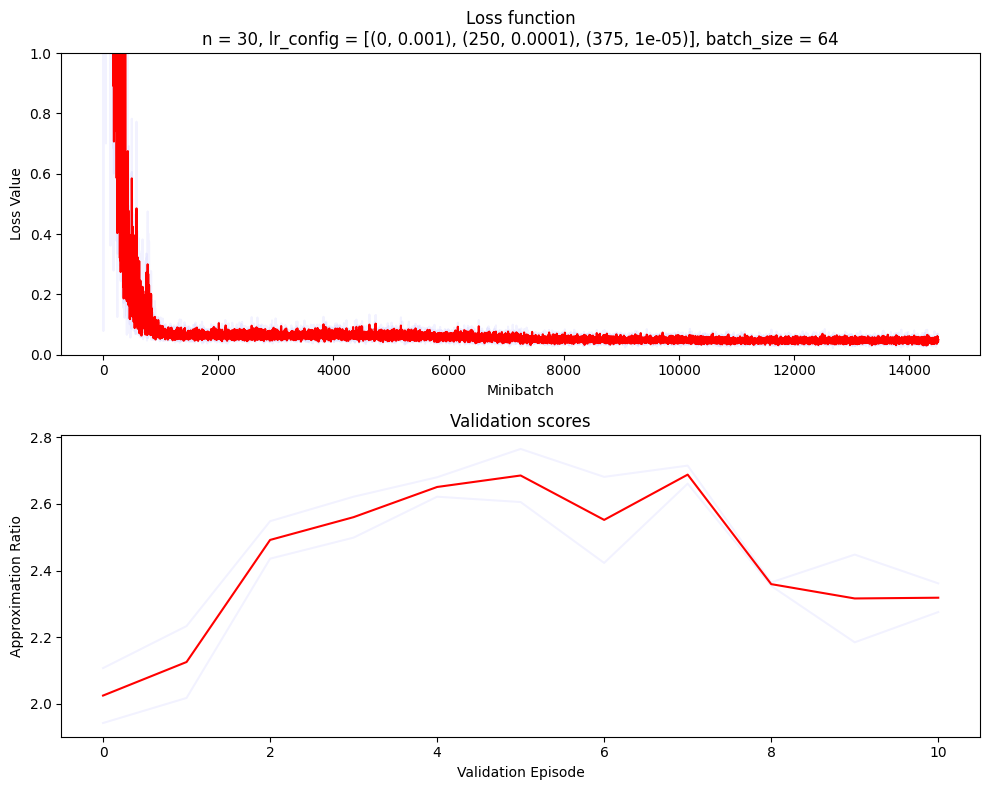

In [21]:
%%time
params = {
    'n': 30,
    'pos_lim': 1e6,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    # 'n': [3, 4, 5],
    'n_episodes': 500,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.005,
    'eps_end_at_episode': 1.0,
    'validate_each': 50,
    'print_train_metrics_each': 10,
    'batch_size': 64
}
agents = run_train(5, 2, params)

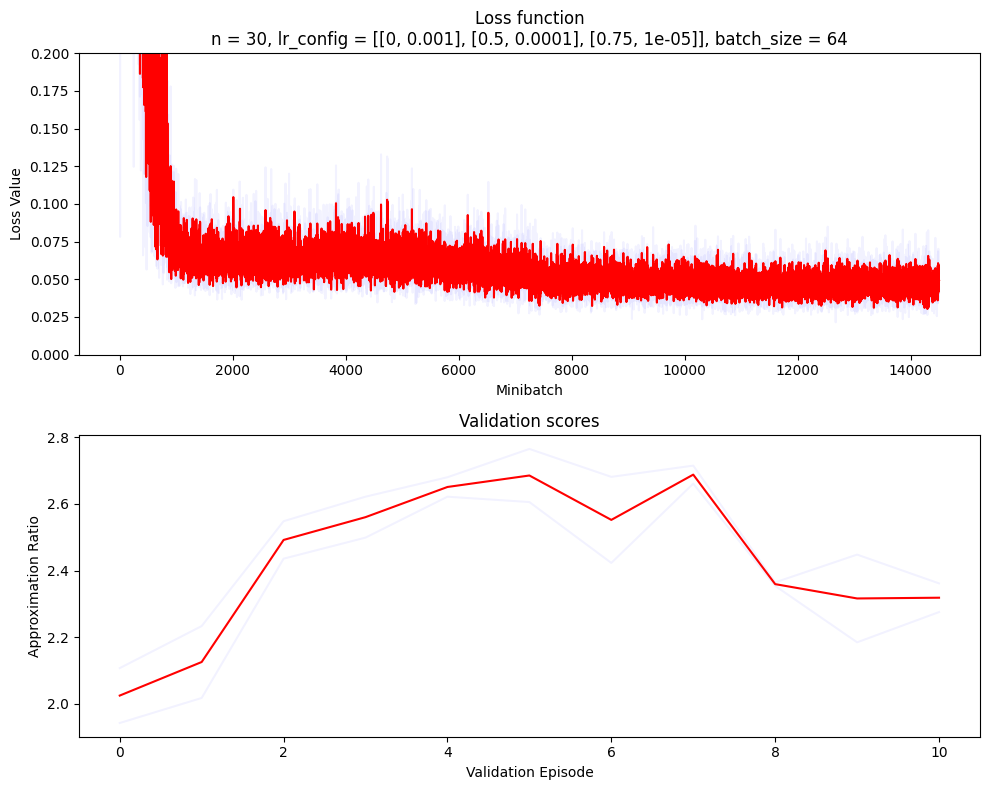

In [22]:
replay_graphs('outputs/run_5', max_loss=2e-1, filename=None)

#### Switched to Xavier Normal + normalize=True + target_update="hard"

{'n': 10, 'pos_lim': 1000000.0, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.005, 'eps_end_at_episode': 1.0, 'validate_each': 50, 'print_train_metrics_each': 10, 'batch_size': 64}
Starting run #1/2...
4485082.605750131 2924473.9162634006 1.5336374110939994
Problem Name: 1f9f61d54e4b4d75aaf6f2eb53ac5ffd
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3071291
   0 Steps   Best: 2924474   0.00 seconds
   5 Total Steps.
Best cycle length: 2924474
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2924474.0
LK Run 0: 2924474.0
LK Run from best tour: 2924474.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2924474 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2840144.000000  (0.00 seconds)
  LP Value  2: 2924474.000000  (0.00 seconds)
New lower bound: 2924474.00

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

4457605.008821451Problem Name: 57b65fd176ec41539834f68f92da749e
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3356290
   0 Steps   Best: 3112034   0.00 seconds
   5 Total Steps.
Best cycle length: 3112034
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3112034.0
LK Run 0: 3112034.0
LK Run from best tour: 3112034.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3112034 (from tour)
  LP Value  1: 2885411.000000  (0.00 seconds)
  LP Value  2: 3112034.000000  (0.00 seconds)
New lower bound: 3112034.000000
Exact lower bound: 3112034.000000
DIFF: 0.000000
Established Bound: 3112034
Optimal tour: 3112034
Total Time to solve TSP: 0.00
 3112034.7319849273 1.4323763687490365
3606393.9687127527 3007051.741892987 1.199312242775866
Problem Name: 3110bef6509f44188b74855ab8a06f43
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCts

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

4416180.179550953Problem Name: 704365a7de784f499e650bc31b4d3f3c
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3218870
   0 Steps   Best: 3218870   0.00 seconds
   5 Total Steps.
Best cycle length: 3218870
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3218870.0
LK Run 0: 3218870.0
LK Run from best tour: 3218870.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3218870 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3218870.000000  (0.00 seconds)
New lower bound: 3218870.000000
Exact lower bound: 3218870.000000
DIFF: 0.000000
Established Bound: 3218870
Optimal tour: 3218870
Total Time to solve TSP: 0.00
 3218870.317367865 1.3719658588675772
4813071.197790393 3081972.8000672576 1.5616851640239515
Problem Name: 0505be69dbb84b63bd4e3a8226f15f06
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3546578.4617193993Problem Name: 59ecabd738d04091b21bd36541a19011
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3249808
   0 Steps   Best: 2795014   0.00 seconds
   5 Total Steps.
Best cycle length: 2795014
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2795014.0
LK Run 0: 2795014.0
LK Run from best tour: 2795014.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2795014 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2729025.000000  (0.00 seconds)
  LP Value  2: 2795014.000000  (0.00 seconds)
New lower bound: 2795014.000000
Exact lower bound: 2795014.000000
DIFF: 0.000000
Established Bound: 2795014
Optimal tour: 2795014
Total Time to solve TSP: 0.00
 2795014.491725433 1.268894480589976
3471657.559581101 2560068.000851971 1.3560802128794078
Problem Name: 08e83ed7b18a472cadec569af6b86901
Problem Type: TSP
Number of No

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3931701.323930456Problem Name: 50fc410d1ff241348131cd3e4bda7abc
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 3000921.186949554 1.310164805736549
linkern ...
Starting Cycle: 3204591
   0 Steps   Best: 3000922   0.00 seconds
   5 Total Steps.
Best cycle length: 3000922
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3000922.0
LK Run 0: 3000922.0
LK Run from best tour: 3000922.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3000922 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2863517.000000  (0.00 seconds)
  LP Value  2: 3000922.000000  (0.00 seconds)
New lower bound: 3000922.000000
Exact lower bound: 3000922.000000
DIFF: 0.000000
Established Bound: 3000922
Optimal tour: 3000922
Total Time to solve TSP: 0.00
3132371.038237932 2630200.7707445216 1.1909246902666153
Problem Name: e0725b53c3084eb4a5b3e97188f8bfb2
Problem Type: TSP
Number of No

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

4386027.0702824695Problem Name: 71ffd731562b41889b672392d30ebb10
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2980290
   0 Steps   Best: 2612504   0.00 seconds
   5 Total Steps.
Best cycle length: 2612504
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2612504.0
LK Run 0: 2612504.0
LK Run from best tour: 2612504.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2612504 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2543240.000000  (0.00 seconds)
  LP Value  2: 2612504.000000  (0.00 seconds)
New lower bound: 2612504.000000
Exact lower bound: 2612504.000000
DIFF: 0.000000
Established Bound: 2612504
Optimal tour: 2612504
Total Time to solve TSP: 0.00
 2612504.1797453053 1.6788593504604712
4641412.285958502 3134156.16041259 1.48091289916693
Problem Name: d2a37a5f3094404a97e17c995fc5a0a3
Problem Type: TSP
Number of Nod

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3376689.6271220003Problem Name: aa6d6a1ff98a4a2c818c5458cc6017f0
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3159854
   0 Steps   Best: 3007970   0.00 seconds
   5 Total Steps.
Best cycle length: 3007970
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3007970.0
LK Run 0: 3007970.0
LK Run from best tour: 3007970.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3007970 (from tour)
  LP Value  1: 2603593.000000  (0.00 seconds)
  LP Value  2: 3007970.000000  (0.00 seconds)
New lower bound: 3007970.000000
Exact lower bound: 3007970.000000
DIFF: 0.000000
Established Bound: 3007970
Optimal tour: 3007970
Total Time to solve TSP: 0.00
 3007968.641490602 1.1225813928195336
2396884.716333908 2272842.9706112733 1.054575589834644
Problem Name: f9f6f8f75ef044b29b1f0e27c7bc70d0
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCts

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3824193.0928439996Problem Name: 335eda5437554f658e0919cd3e91c6b2
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 3093759.6185324467 1.236098974831807
linkern ...
Starting Cycle: 3256983
   0 Steps   Best: 3093760   0.00 seconds
   5 Total Steps.
Best cycle length: 3093760
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3093760.0
LK Run 0: 3093760.0
LK Run from best tour: 3093760.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3093760 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3075490.000000  (0.00 seconds)
  LP Value  2: 3093760.000000  (0.00 seconds)
New lower bound: 3093760.000000
Exact lower bound: 3093760.000000
DIFF: 0.000000
Established Bound: 3093760
Optimal tour: 3093760
Total Time to solve TSP: 0.00
3786403.827077312 3163373.4589935904 1.1969512535146372
Problem Name: 8ca6b2f365d74175a1412f1c0de3471f
Problem Type: TSP
Number of 

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2742605.4021694083Problem Name: 7a23cdbcf3d44a009b41d1e9883d0d37
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 2593258.2638926436 1.0575905378790098
linkern ...
Starting Cycle: 2742606
   0 Steps   Best: 2593259   0.00 seconds
   5 Total Steps.
Best cycle length: 2593259
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2593259.0
LK Run 0: 2593259.0
LK Run from best tour: 2593259.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2593259 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2593259.000000  (0.00 seconds)
New lower bound: 2593259.000000
Exact lower bound: 2593259.000000
DIFF: 0.000000
Established Bound: 2593259
Optimal tour: 2593259
Total Time to solve TSP: 0.00
3450475.9519268055 2856571.499968253 1.2079081346170235
Problem Name: d0cc2d54abca4f51b380532852cb3326
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEA

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2662112.893329286Problem Name: 1eefe6c9a2c24e1b8547ebc5457a9899
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2478323
   0 Steps   Best: 2359103   0.00 seconds
   5 Total Steps.
Best cycle length: 2359103
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2359103.0
LK Run 0: 2359103.0
LK Run from best tour: 2359103.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2359103 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2066119.000000  (0.00 seconds)
  LP Value  2: 2359103.000000  (0.00 seconds)
New lower bound: 2359103.000000
Exact lower bound: 2359103.000000
DIFF: 0.000000
Established Bound: 2359103
Optimal tour: 2359103
Total Time to solve TSP: 0.00
 2359103.889039541 1.1284424165029496
3484607.921881367 2914626.9951334605 1.1955587894092798
Problem Name: 7e7942be4c26457ea6eb2862b07f3496
Problem Type: TSP
Number of N

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2757294.722391597Problem Name: 6ab075fce6994d09a98a28bc430277fd
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2757293
   0 Steps   Best: 2746023   0.00 seconds
   5 Total Steps.
Best cycle length: 2746023
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2746023.0
LK Run 0: 2746023.0
LK Run from best tour: 2746023.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2746023 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2698513.000000  (0.00 seconds)
  LP Value  2: 2746023.000000  (0.00 seconds)
New lower bound: 2746023.000000
Exact lower bound: 2746023.000000
DIFF: 0.000000
Established Bound: 2746023
Optimal tour: 2746023
Total Time to solve TSP: 0.00
 2746024.24022286 1.00410429085208
3230358.0155506567 2488711.62578228 1.2980041488476004
Problem Name: 13897f71ba854b6bba100166df6b0965
Problem Type: TSP
Number of Nodes

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3350050.3899346297Problem Name: 9d0a1b3e743144ca8ae91309b8285014
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3148464
   0 Steps   Best: 2819515   0.00 seconds
   5 Total Steps.
Best cycle length: 2819515
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2819515.0
LK Run 0: 2819515.0
LK Run from best tour: 2819515.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2819515 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2548114.000000  (0.00 seconds)
  LP Value  2: 2819515.000000  (0.00 seconds)
New lower bound: 2819515.000000
Exact lower bound: 2819515.000000
DIFF: 0.000000
Established Bound: 2819515
Optimal tour: 2819515
Total Time to solve TSP: 0.00
 2819514.8243433977 1.1881655528144923
3444441.253558394 2674622.038101473 1.2878235520721881
Problem Name: e00afa3031134879a68af4cb688b8fae
Problem Type: TSP
Number of 

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2457295.5272853305Problem Name: c447ada192cf4c9aaba653bc6b06b71b
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 2322757.1225655335 1.057921856492338
linkern ...
Starting Cycle: 2392823
   0 Steps   Best: 2322756   0.00 seconds
   5 Total Steps.
Best cycle length: 2322756
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2322756.0
LK Run 0: 2322756.0
LK Run from best tour: 2322756.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2322756 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2039076.000000  (0.00 seconds)
  LP Value  2: 2322756.000000  (0.00 seconds)
New lower bound: 2322756.000000
Exact lower bound: 2322756.000000
DIFF: 0.000000
Established Bound: 2322756
Optimal tour: 2322756
Total Time to solve TSP: 0.00
2949158.262099203 2832129.046433824 1.041321992658753
Problem Name: 935cfbc79216471e8495e666904fad6b
Problem Type: TSP
Number of No

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3143644.949599844Problem Name: b0e02ad2dc3b43b1beda5f7bcec84a36
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2794820
   0 Steps   Best: 2665839   0.00 seconds
   5 Total Steps.
Best cycle length: 2665839
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2665839.0
LK Run 0: 2665839.0
LK Run from best tour: 2665839.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2665839 (from tour)
  LP Value  1: 2277884.000000  (0.00 seconds)
  LP Value  2: 2665839.000000  (0.00 seconds)
New lower bound: 2665839.000000
Exact lower bound: 2665839.000000
DIFF: 0.000000
Established Bound: 2665839
Optimal tour: 2665839
Total Time to solve TSP: 0.00
 2665840.7838399056 1.179232071418648
2546763.4608847667 2337629.0678971107 1.0894643191512798
Problem Name: 3ada0b3f0f0346a49d296078ad78c7be
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCt

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3678205.1487865876Problem Name: ae6053d0bf824b43a409c49a711b2835
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3129256
   0 Steps   Best: 2791297   0.00 seconds
   5 Total Steps.
Best cycle length: 2791297
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2791297.0
LK Run 0: 2791297.0
LK Run from best tour: 2791297.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2791297 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2599330.000000  (0.00 seconds)
  LP Value  2: 2791297.000000  (0.00 seconds)
New lower bound: 2791297.000000
Exact lower bound: 2791297.000000
DIFF: 0.000000
Established Bound: 2791297
Optimal tour: 2791297
Total Time to solve TSP: 0.00
 2791297.7777448446 1.317740148726911
2520485.387002657 2291997.937170626 1.099689203958922
Problem Name: 6045ddcc9a83495ba42ee1ad3fa65ba1
Problem Type: TSP
Number of No

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3353053.235444429Problem Name: bb96557a4f7f4bc6a9daf550b41530e1
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3353054
   0 Steps   Best: 3135239   0.00 seconds
   5 Total Steps.
Best cycle length: 3135239
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3135239.0
LK Run 0: 3135239.0
LK Run from best tour: 3135239.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3135239 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3015855.000000  (0.00 seconds)
  LP Value  2: 3135239.000000  (0.00 seconds)
New lower bound: 3135239.000000
Exact lower bound: 3135239.000000
DIFF: 0.000000
Established Bound: 3135239
Optimal tour: 3135239
Total Time to solve TSP: 0.00
 3135238.9374369504 1.0694729500219657
3569714.6649701865 3071017.5518646855 1.1623882327871093
Problem Name: 858678a601564ddb98dde13927af7f2d
Problem Type: TSP
Number of

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3689911.107520933Problem Name: 4042ad36e85a42fb8e330bd9086649b0
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3689911
   0 Steps   Best: 3282746   0.00 seconds
   5 Total Steps.
Best cycle length: 3282746
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3282746.0
LK Run 0: 3282746.0
LK Run from best tour: 3282746.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3282746 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3174132.000000  (0.00 seconds)
  LP Value  2: 3282746.000000  (0.00 seconds)
New lower bound: 3282746.000000
Exact lower bound: 3282746.000000
DIFF: 0.000000
Established Bound: 3282746
Optimal tour: 3282746
Total Time to solve TSP: 0.00
 3282745.611693331 1.1240319975989777
2959551.5206797505 2720808.572478387 1.087747058215085
Problem Name: 0c3394320cf04c519696d514ce81c0ec
Problem Type: TSP
Number of No

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3966433.872007288Problem Name: 822b16f8805b4eb1b59a25eb5f98a1b6
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3536283
   0 Steps   Best: 3290107   0.00 seconds
   5 Total Steps.
Best cycle length: 3290107
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3290107.0
LK Run 0: 3290107.0
LK Run from best tour: 3290107.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3290107 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3193983.000000  (0.00 seconds)
  LP Value  2: 3290107.000000  (0.00 seconds)
New lower bound: 3290107.000000
Exact lower bound: 3290107.000000
DIFF: 0.000000
Established Bound: 3290107
Optimal tour: 3290107
Total Time to solve TSP: 0.00
 3290108.116685356 1.2055633831277561
3120190.8411941384 2978597.013452767 1.047537087797331
Problem Name: fac618eaf1a5499e96ac3b9997715aa4
Problem Type: TSP
Number of No

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3637823.7959429263Problem Name: c92ec4a0730c4f21aca42ec20759bb27
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3141994
   0 Steps   Best: 3141994   0.00 seconds
   5 Total Steps.
Best cycle length: 3141994
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3141994.0
LK Run 0: 3141994.0
LK Run from best tour: 3141994.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3141994 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3084311.500000  (0.00 seconds)
  LP Value  2: 3141994.000000  (0.00 seconds)
New lower bound: 3141994.000000
Exact lower bound: 3141994.000000
DIFF: 0.000000
Established Bound: 3141994
Optimal tour: 3141994
Total Time to solve TSP: 0.00
 3141993.6435067123 1.1578074969887044
2914742.542779825 2602293.5070002396 1.120066792980534
Problem Name: f472700560d4465c84c88d664250f508
Problem Type: TSP
Number of 

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3982772.7064440604Problem Name: 25b6cca2d3504a8cb7f4e2c9b8123f8b
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3816958
   0 Steps   Best: 3470070   0.00 seconds
   5 Total Steps.
Best cycle length: 3470070
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3470070.0
LK Run 0: 3470070.0
LK Run from best tour: 3470070.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3470070 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3470070.000000  (0.00 seconds)
New lower bound: 3470070.000000
Exact lower bound: 3470070.000000
DIFF: 0.000000
Established Bound: 3470070
Optimal tour: 3470070
Total Time to solve TSP: 0.00
 3470068.889396168 1.1477503281317014
3692328.290810942 3164639.8029335067 1.166745197159022
Problem Name: 5265065ed24a4152bb7b030468d1f8d5
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2911294.0507519874Problem Name: 438595720e38490397529d45e0548cec
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2628097
   0 Steps   Best: 2624519   0.00 seconds
   5 Total Steps.
Best cycle length: 2624519
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2624519.0
LK Run 0: 2624519.0
LK Run from best tour: 2624519.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2624519 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2521429.000000  (0.00 seconds)
  LP Value  2: 2624519.000000  (0.00 seconds)
New lower bound: 2624519.000000
Exact lower bound: 2624519.000000
DIFF: 0.000000
Established Bound: 2624519
Optimal tour: 2624519
Total Time to solve TSP: 0.00
 2624517.3404675256 1.1092683617908106
3627798.8543285467 3286904.850258304 1.1037127691857138
Problem Name: d9a6ec54e175409ea0c5f2172b043d0c
Problem Type: TSP
Number of

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

4030331.1805987568Problem Name: d041f0d8e78642ef83d3bc145a935009
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3687414
   0 Steps   Best: 3268938   0.00 seconds
   5 Total Steps.
Best cycle length: 3268938
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3268938.0
LK Run 0: 3268938.0
LK Run from best tour: 3268938.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3268938 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3268938.000000  (0.00 seconds)
New lower bound: 3268938.000000
Exact lower bound: 3268938.000000
DIFF: 0.000000
Established Bound: 3268938
Optimal tour: 3268938
Total Time to solve TSP: 0.00
 3268937.2569663688 1.2329178762944428
3182798.283851593 2732333.9898625826 1.1648642865990426
Problem Name: b5e8275d3e8e4bf3b04cadec616524cf
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEA

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

4163701.3369863275Problem Name: de61200ee2034dc5856bd00675f00d58
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3611532
   0 Steps   Best: 3279133   0.00 seconds
   5 Total Steps.
Best cycle length: 3279133
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3279133.0
LK Run 0: 3279133.0
LK Run from best tour: 3279133.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3279133 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3279133.000000  (0.00 seconds)
New lower bound: 3279133.000000
Exact lower bound: 3279133.000000
DIFF: 0.000000
Established Bound: 3279133
Optimal tour: 3279133
Total Time to solve TSP: 0.00
 3279133.4983539376 1.2697565802296327
2935322.7181568746 2535128.9590339772 1.1578593300734465
Problem Name: a16cc69df9b54403a487b14ef039f8af
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDE

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2240832.012660587Problem Name: d350992fd74e469984e2e0d8dd4ad681
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2673830
   0 Steps   Best: 2240833   0.00 seconds
   5 Total Steps.
Best cycle length: 2240833
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2240833.0
LK Run 0: 2240833.0
LK Run from best tour: 2240833.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2240833 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2032963.000000  (0.00 seconds)
  LP Value  2: 2240833.000000  (0.00 seconds)
New lower bound: 2240833.000000
Exact lower bound: 2240833.000000
DIFF: 0.000000
Established Bound: 2240833
Optimal tour: 2240833
Total Time to solve TSP: 0.00
 2240832.012660587 1.0
3577489.5967325037 3173329.637146189 1.1273614801485863
Problem Name: a0097b029b63409f81e1387521df33ea
Problem Type: TSP
Number of Nodes: 10
Rounde

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

4082165.2570030303Problem Name: 059424e1f74e4573b348391bd2130cdd
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3184944
   0 Steps   Best: 3184944   0.00 seconds
   5 Total Steps.
Best cycle length: 3184944
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3184944.0
LK Run 0: 3184944.0
LK Run from best tour: 3184944.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3184944 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2998422.000000  (0.00 seconds)
  LP Value  2: 3184944.000000  (0.00 seconds)
New lower bound: 3184944.000000
Exact lower bound: 3184944.000000
DIFF: 0.000000
Established Bound: 3184944
Optimal tour: 3184944
Total Time to solve TSP: 0.00
 3184944.3456197446 1.2817069355127773
2906808.53261651 2535727.9015332093 1.146340871533941
Problem Name: 7bedc11a50744a099a03884e9abe4199
Problem Type: TSP
Number of N

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3083953.5333398213Problem Name: 54b571b3e59a4538aab61a30ee9e097e
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3083954
   0 Steps   Best: 2991255   0.00 seconds
   5 Total Steps.
Best cycle length: 2991255
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2991255.0
LK Run 0: 2991255.0
LK Run from best tour: 2991255.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2991255 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2828842.000000  (0.00 seconds)
  LP Value  2: 2991255.000000  (0.00 seconds)
New lower bound: 2991255.000000
Exact lower bound: 2991255.000000
DIFF: 0.000000
Established Bound: 2991255
Optimal tour: 2991255
Total Time to solve TSP: 0.00
 2991255.0745280976 1.0309898208284185
3097865.2173077962 2728278.7219843147 1.135465079995447
Problem Name: 4d83731dc2334a5f97eba007a8a2c405
Problem Type: TSP
Number of

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3399052.092790208Problem Name: 5114366693624600b71e5a3212fd4597
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2863353
   0 Steps   Best: 2551217   0.00 seconds
   1 Steps   Best: 2459353   0.00 seconds
   5 Total Steps.
Best cycle length: 2459353
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2459353.0
LK Run 0: 2459353.0
LK Run from best tour: 2459353.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2459353 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2424872.000000  (0.00 seconds)
  LP Value  2: 2459353.000000  (0.00 seconds)
New lower bound: 2459353.000000
Exact lower bound: 2459353.000000
DIFF: 0.000000
Established Bound: 2459353
Optimal tour: 2459353
Total Time to solve TSP: 0.00
 2459352.4958367054 1.3820922777618356
3477679.7901739576 3220057.3376347227 1.0800055482019677
Problem Name: a596a62b1043466499

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2596848.3958880124Problem Name: fe258d667c894f77b39828c46e857412
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2262538
   0 Steps   Best: 2168897   0.00 seconds
   5 Total Steps.
Best cycle length: 2168897
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2168897.0
LK Run 0: 2168897.0
LK Run from best tour: 2168897.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2168897 (from tour)
  LP Value  1: 1940461.000000  (0.00 seconds)
  LP Value  2: 2168897.000000  (0.00 seconds)
New lower bound: 2168897.000000
Exact lower bound: 2168897.000000
DIFF: 0.000000
Established Bound: 2168897
Optimal tour: 2168897
Total Time to solve TSP: 0.00
 2168897.5207401286 1.1973126305210802
3212518.0179178133 2587088.2866084464 1.2417504398851715
Problem Name: 50e55c8292984df1b3cfa9e2a4be962b
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
C

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2724425.5259558414Problem Name: af553b03ccc0472eb6154f9ea4c9a0a9
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2497562
   0 Steps   Best: 2404917   0.00 seconds
   2 Steps   Best: 2391857   0.00 seconds
   5 Total Steps.
Best cycle length: 2391857
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2391857.0
LK Run 0: 2391857.0
LK Run from best tour: 2391857.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2391857 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 1570020.000000  (0.00 seconds)
  LP Value  2: 2391857.000000  (0.00 seconds)
New lower bound: 2391857.000000
Exact lower bound: 2391857.000000
DIFF: 0.000000
Established Bound: 2391857
Optimal tour: 2391857
Total Time to solve TSP: 0.00
 2391856.2803682736 1.1390423196900283
2697010.1329722176 2686537.814498969 1.0038980722388238
Problem Name: 5eb12fcd9de5461da6

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3719353.710185208Problem Name: 108539deeff8438c9aef8a9b0480c1d7
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2817570
   0 Steps   Best: 2817570   0.00 seconds
   5 Total Steps.
Best cycle length: 2817570
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2817570.0
LK Run 0: 2817570.0
LK Run from best tour: 2817570.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2817570 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2817570.000000  (0.00 seconds)
New lower bound: 2817570.000000
Exact lower bound: 2817570.000000
DIFF: 0.000000
Established Bound: 2817570
Optimal tour: 2817570
Total Time to solve TSP: 0.00
 2817568.712126602 1.3200578549078117
3156367.326772786 2821313.3137104847 1.1187581724560933
Problem Name: c337dff96efb4aa7b3ddbea449855156
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3738715.5617794823Problem Name: fbf3893809a04a9f89bfa456caf202ed
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3573611
   0 Steps   Best: 3214281   0.00 seconds
   5 Total Steps.
Best cycle length: 3214281
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3214281.0
LK Run 0: 3214281.0
LK Run from best tour: 3214281.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3214281 (from tour)
  LP Value  1: 3214281.000000  (0.00 seconds)
New lower bound: 3214281.000000
Exact lower bound: 3214281.000000
DIFF: 0.000000
Established Bound: 3214281
Optimal tour: 3214281
Total Time to solve TSP: 0.00
 3214281.9510498764 1.1631573143601515
2879797.524226847 2879097.101997435 1.0002432784322994
Problem Name: 9992b2af2da44cb7a37fe5e3622e7922
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compr

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3134181.035673445Problem Name: 3c000a596b714ee9b9a1239b818190c2
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 2992010.7476524045 1.0475166368077355
linkern ...
Starting Cycle: 2992011
   0 Steps   Best: 2992011   0.00 seconds
   5 Total Steps.
Best cycle length: 2992011
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2992011.0
LK Run 0: 2992011.0
LK Run from best tour: 2992011.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2992011 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2992011.000000  (0.00 seconds)
New lower bound: 2992011.000000
Exact lower bound: 2992011.000000
DIFF: 0.000000
Established Bound: 2992011
Optimal tour: 2992011
Total Time to solve TSP: 0.00
4321608.009395177 3557878.229372772 1.2146587743552553
Problem Name: d9289e25a4d44e3e9f16c361a470962f
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: 81ed0747e8464262bf9c5eb2884bba68
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
3145449.003553928 2794999.4745517997 1.1253844704419222
linkern ...
Starting Cycle: 3187144
   0 Steps   Best: 2794999   0.00 seconds
   5 Total Steps.
Best cycle length: 2794999
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2794999.0
LK Run 0: 2794999.0
LK Run from best tour: 2794999.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2794999 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2676178.000000  (0.00 seconds)
  LP Value  2: 2780385.500000  (0.00 seconds)
  LP Value  3: 2794999.000000  (0.00 seconds)
New lower bound: 2794999.000000
Exact lower bound: 2794999.000000
DIFF: 0.000000
Established Bound: 2794999
Optimal tour: 2794999
Total Time to solve TSP: 0.00
3564325.9553475943 2949287.0122376746 1.2085381790778238
Problem Name: f94d84c9fce64a

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3424249.4558259877Problem Name: 5325b84128cf4df1b6ddaf1c61eca0fa
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3208507
   0 Steps   Best: 2783380   0.00 seconds
   5 Total Steps.
Best cycle length: 2783380
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2783380.0
LK Run 0: 2783380.0
LK Run from best tour: 2783380.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2783380 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2706675.000000  (0.00 seconds)
  LP Value  2: 2783380.000000  (0.00 seconds)
New lower bound: 2783380.000000
Exact lower bound: 2783380.000000
DIFF: 0.000000
Established Bound: 2783380
Optimal tour: 2783380
Total Time to solve TSP: 0.00
 2783379.930311048 1.230248669445325


ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


3453547.440304718Problem Name: 8f2e8d0240c343f99b4cc35d4d80a8cf
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3228904
   0 Steps   Best: 3060258   0.00 seconds
   5 Total Steps.
Best cycle length: 3060258
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3060258.0
LK Run 0: 3060258.0
LK Run from best tour: 3060258.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3060258 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2968894.000000  (0.00 seconds)
  LP Value  2: 3060258.000000  (0.00 seconds)
New lower bound: 3060258.000000
Exact lower bound: 3060258.000000
DIFF: 0.000000
Established Bound: 3060258
Optimal tour: 3060258
Total Time to solve TSP: 0.00
 3060259.3257116526 1.1285146364194503
2894115.8472725833 2711185.504736524 1.0674724552106354
Problem Name: 4277a7b4e3d64d18884ef038f223b0ca
Problem Type: TSP
Number of 

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2749890.3091247897Problem Name: 166097a0827b4d1c8d7205598b5419e3
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2749891
   0 Steps   Best: 2536637   0.00 seconds
   1 Steps   Best: 2490392   0.00 seconds
   5 Total Steps.
Best cycle length: 2490392
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2490392.0
LK Run 0: 2490392.0
LK Run from best tour: 2490392.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2490392 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2409662.000000  (0.00 seconds)
  LP Value  2: 2444015.000000  (0.00 seconds)
  LP Value  3: 2490392.000000  (0.00 seconds)
New lower bound: 2490392.000000
Exact lower bound: 2490392.000000
DIFF: 0.000000
Established Bound: 2490392
Optimal tour: 2490392
Total Time to solve TSP: 0.00
 2490392.311237977 1.1041996462628878
2770711.813043326 2702309.642442419 1.02531

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3741821.150487185Problem Name: dccf4ad211444f6faf9c7fdf0f4b803b
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3138343
   0 Steps   Best: 2781087   0.00 seconds
   5 Total Steps.
Best cycle length: 2781087
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2781087.0
LK Run 0: 2781087.0
LK Run from best tour: 2781087.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2781087 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2781087.000000  (0.00 seconds)
New lower bound: 2781087.000000
Exact lower bound: 2781087.000000
DIFF: 0.000000
Established Bound: 2781087
Optimal tour: 2781087
Total Time to solve TSP: 0.00
 2781085.5645982134 1.3454534438345374
3098983.772112548 2768622.5619171318 1.1193233107103835
Problem Name: b1ab41455bdc4b738b7c3f77b4bcc77a
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

4275068.488211694Problem Name: 7dbf8c0c60f34893bc6a01f800274a93
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3990486
   0 Steps   Best: 3458057   0.00 seconds
   5 Total Steps.
Best cycle length: 3458057
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3458057.0
LK Run 0: 3458057.0
LK Run from best tour: 3458057.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3458057 (from tour)
  LP Value  1: 3458057.000000  (0.00 seconds)
New lower bound: 3458057.000000
Exact lower bound: 3458057.000000
DIFF: 0.000000
Established Bound: 3458057
Optimal tour: 3458057
Total Time to solve TSP: 0.00
 3458057.1544241053 1.236263108821766
3656433.7489976133 2846622.49686489 1.2844814347615827
Problem Name: 1c03080ff92040a0af1fb2761f6e2ee4
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compres

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2584397.4085172606Problem Name: 6eac4884978948eb91cf047c6cb8b46e
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2584397
   0 Steps   Best: 2577089   0.00 seconds
   5 Total Steps.
Best cycle length: 2577089
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2577089.0
LK Run 0: 2577089.0
LK Run from best tour: 2577089.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2577089 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2577089.000000  (0.00 seconds)
New lower bound: 2577089.000000
Exact lower bound: 2577089.000000
DIFF: 0.000000
Established Bound: 2577089
Optimal tour: 2577089
Total Time to solve TSP: 0.00
 2577089.066523984 1.0028358903416303
3062301.4781830674 3062301.4781830674 1.0
Problem Name: 567c6b1a45114458b276d6b83f23a499
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3653179.4420250794Problem Name: a25e6d3372ac46f883e6ee2f4e421556
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 3464805.733734768 1.0543677547217807
linkern ...
Starting Cycle: 3653180
   0 Steps   Best: 3464806   0.00 seconds
   5 Total Steps.
Best cycle length: 3464806
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3464806.0
LK Run 0: 3464806.0
LK Run from best tour: 3464806.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3464806 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3464806.000000  (0.00 seconds)
New lower bound: 3464806.000000
Exact lower bound: 3464806.000000
DIFF: 0.000000
Established Bound: 3464806
Optimal tour: 3464806
Total Time to solve TSP: 0.00
3677853.6858790102 3629412.706446164 1.0133467817938728
Problem Name: a6a754324cf04617ae8a8c2fd849524e
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3406469.2702590264Problem Name: 55aa2a1883cf4dfe915292d5f3ad5642
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3119845
   0 Steps   Best: 3119845   0.00 seconds
   5 Total Steps.
Best cycle length: 3119845
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3119845.0
LK Run 0: 3119845.0
LK Run from best tour: 3119845.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3119845 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3060943.000000  (0.00 seconds)
  LP Value  2: 3119845.000000  (0.00 seconds)
New lower bound: 3119845.000000
Exact lower bound: 3119845.000000
DIFF: 0.000000
Established Bound: 3119845
Optimal tour: 3119845
Total Time to solve TSP: 0.00
 3119847.246799561 1.0918705310824084
3867403.860955123 3167664.5469546523 1.2209006994358635
Problem Name: 4827e36a2a664454889ef24694f0db9b
Problem Type: TSP
Number of 

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

4649290.0386287905Problem Name: 0b12adc3b81a490f9c6f6fd03f39dc4f
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2918911
   0 Steps   Best: 2872380   0.00 seconds
   5 Total Steps.
Best cycle length: 2872380
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2872380.0
LK Run 0: 2872380.0
LK Run from best tour: 2872380.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2872380 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2665174.000000  (0.00 seconds)
  LP Value  2: 2872380.000000  (0.00 seconds)
New lower bound: 2872380.000000
Exact lower bound: 2872380.000000
DIFF: 0.000000
Established Bound: 2872380
Optimal tour: 2872380
Total Time to solve TSP: 0.00
 2872381.2586732134 1.618618706896992
4242005.3669819925 2229846.225714751 1.9023757414582556
Problem Name: 2b84f63035e54215b8167bdaac8acc31
Problem Type: TSP
Number of 

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3520058.044861874Problem Name: 705c2828ee2b4318a1a54e0c0968ee37
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2924494
   0 Steps   Best: 2447349   0.00 seconds
   5 Total Steps.
Best cycle length: 2447349
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2447349.0
LK Run 0: 2447349.0
LK Run from best tour: 2447349.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2447349 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2423255.000000  (0.00 seconds)
  LP Value  2: 2447349.000000  (0.00 seconds)
New lower bound: 2447349.000000
Exact lower bound: 2447349.000000
DIFF: 0.000000
Established Bound: 2447349
Optimal tour: 2447349
Total Time to solve TSP: 0.00
 2447349.5805590907 1.4383143596746508
3507537.2075657924 2629605.645495307 1.3338643433377326
Problem Name: 343cbdf0c1cb4ccd9fe950bc5a384f9d
Problem Type: TSP
Number of 

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

4379506.421747486Problem Name: 5c6f0abfd4e642c6a2e84257bc1079de
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3335804
   0 Steps   Best: 2862201   0.00 seconds
   5 Total Steps.
Best cycle length: 2862201
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2862201.0
LK Run 0: 2862201.0
LK Run from best tour: 2862201.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2862201 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2862201.000000  (0.00 seconds)
New lower bound: 2862201.000000
Exact lower bound: 2862201.000000
DIFF: 0.000000
Established Bound: 2862201
Optimal tour: 2862201
Total Time to solve TSP: 0.00
 2862201.0517599494 1.5301183748271474
4745823.258978957 2545013.063942568 1.864753987402736
Problem Name: fa3ff3cc7c3c4f56ab2105d781bdd60e
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)


ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

4786364.368277912Problem Name: 5252ec0be3c741a6923a28a8f74b016b
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2831514
   0 Steps   Best: 2831514   0.00 seconds
   5 Total Steps.
Best cycle length: 2831514
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2831514.0
LK Run 0: 2831514.0
LK Run from best tour: 2831514.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2831514 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2831514.000000  (0.00 seconds)
New lower bound: 2831514.000000
Exact lower bound: 2831514.000000
DIFF: 0.000000
Established Bound: 2831514
Optimal tour: 2831514
Total Time to solve TSP: 0.00
 2831513.8465217995 1.6903905923530727
3626814.1134138843 3010574.935737064 1.2046915259812156
Problem Name: f0a7601aeb0045f48c428d3e10bb7b85
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

4572979.87434891Problem Name: 77971b346ee84bf99809bdaf13302fb1
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3165023
   0 Steps   Best: 2923194   0.00 seconds
   5 Total Steps.
Best cycle length: 2923194
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2923194.0
LK Run 0: 2923194.0
LK Run from best tour: 2923194.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2923194 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2842010.500000  (0.00 seconds)
  LP Value  2: 2923194.000000  (0.00 seconds)
New lower bound: 2923194.000000
Exact lower bound: 2923194.000000
DIFF: 0.000000
Established Bound: 2923194
Optimal tour: 2923194
Total Time to solve TSP: 0.00
 2923195.0546493265 1.564377261474772
4449796.262672791 2959874.603966707 1.5033732363895924
Problem Name: ef9a89d6a11c47bc873930ca6c39578e
Problem Type: TSP
Number of Nod

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3014841.5463443077Problem Name: 599b2523ab6b4f5aa7a4fb0fa3d35327
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3014842
   0 Steps   Best: 2954399   0.00 seconds
   5 Total Steps.
Best cycle length: 2954399
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2954399.0
LK Run 0: 2954399.0
LK Run from best tour: 2954399.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2954399 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2954399.000000  (0.00 seconds)
New lower bound: 2954399.000000
Exact lower bound: 2954399.000000
DIFF: 0.000000
Established Bound: 2954399
Optimal tour: 2954399
Total Time to solve TSP: 0.00
 2954399.308373305 1.0204583848228297
Problem Name: 92cdb251f2ee486288de0c921fc927c4
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compressio

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 8937c77143ba4a30a6bda106d66de7eb
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3419725
   0 Steps   Best: 3419725   0.00 seconds
   5 Total Steps.
Best cycle length: 3419725
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3419725.0
3628775.735509509 3419724.7039310485 1.0611309534180198
LK Run 0: 3419725.0
LK Run from best tour: 3419725.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3419725 (from tour)
  LP Value  1: 3316234.500000  (0.00 seconds)
  LP Value  2: 3419725.000000  (0.00 seconds)
New lower bound: 3419725.000000
Exact lower bound: 3419725.000000
DIFF: 0.000000
Established Bound: 3419725
Optimal tour: 3419725
Total Time to solve TSP: 0.00
2869641.657932495 2869641.6579324957 0.9999999999999999
Problem Name: 79ab7bb4cc74489f818f2c22e68e9999
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCt

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


3151280.158701237Problem Name: 2aed0e5bd52c40b08873ad679a6b12d4
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2993810
   0 Steps   Best: 2854861   0.00 seconds
   5 Total Steps.
Best cycle length: 2854861
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2854861.0
LK Run 0: 2854861.0
LK Run from best tour: 2854861.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2854861 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2565376.000000  (0.00 seconds)
  LP Value  2: 2854861.000000  (0.00 seconds)
New lower bound: 2854861.000000
Exact lower bound: 2854861.000000
DIFF: 0.000000
Established Bound: 2854861
Optimal tour: 2854861
Total Time to solve TSP: 0.00
 2854861.322223349 1.103829504491321
4137943.902536687 3275262.0603391463 1.2633932266501484
Problem Name: 6a6bd436c44a4ab3a9647f28582e96b4
Problem Type: TSP
Number of No

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3247968.4568974976Problem Name: b326bc84df694276b5db8b85c07917d6
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3106218
   0 Steps   Best: 2785684   0.00 seconds
   5 Total Steps.
Best cycle length: 2785684
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2785684.0
LK Run 0: 2785684.0
LK Run from best tour: 2785684.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2785684 (from tour)
  LP Value  1: 2536681.000000  (0.00 seconds)
  LP Value  2: 2785684.000000  (0.00 seconds)
New lower bound: 2785684.000000
Exact lower bound: 2785684.000000
DIFF: 0.000000
Established Bound: 2785684
Optimal tour: 2785684
Total Time to solve TSP: 0.00
 2785684.111813537 1.1659500239540816
3934950.581403686 3105125.198451818 1.2672437759886817
Problem Name: 82bebb82d16a44dc99b9867d07f0f4d9
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCts

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3068691.7816441134Problem Name: b24a5c49fdf34a079749f17f9b708cca
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3120852
   0 Steps   Best: 2792831   0.00 seconds
   5 Total Steps.
Best cycle length: 2792831
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2792831.0
LK Run 0: 2792831.0
LK Run from best tour: 2792831.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2792831 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2654416.000000  (0.00 seconds)
  LP Value  2: 2792831.000000  (0.00 seconds)
New lower bound: 2792831.000000
Exact lower bound: 2792831.000000
DIFF: 0.000000
Established Bound: 2792831
Optimal tour: 2792831
Total Time to solve TSP: 0.00
 2792830.7332733893 1.0987747109354515
3192273.4267765074 3175974.110211627 1.0051320684612868
Problem Name: 276118a23fa04ae5816584fc64a10af5
Problem Type: TSP
Number of

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3818151.4740487537Problem Name: 7a8aaf2a432445d19b60d4f5f6a586e4
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 2856501.481494072 1.336653069772503
linkern ...
Starting Cycle: 2856503
   0 Steps   Best: 2856503   0.00 seconds
   5 Total Steps.
Best cycle length: 2856503
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2856503.0
LK Run 0: 2856503.0
LK Run from best tour: 2856503.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2856503 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2856503.000000  (0.00 seconds)
New lower bound: 2856503.000000
Exact lower bound: 2856503.000000
DIFF: 0.000000
Established Bound: 2856503
Optimal tour: 2856503
Total Time to solve TSP: 0.00
2881586.9831988956 2777365.1882476904 1.037525419916767
Problem Name: 06abcbff1c564c73b7e5fbc0fb642d1c
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3046824.21153527Problem Name: a1bdf345dbfd41c3a50c0b96423f185c
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3099820
   0 Steps   Best: 2824933   0.00 seconds
   5 Total Steps.
Best cycle length: 2824933
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2824933.0
LK Run 0: 2824933.0
LK Run from best tour: 2824933.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2824933 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2697256.000000  (0.00 seconds)
  LP Value  2: 2824933.000000  (0.00 seconds)
New lower bound: 2824933.000000
Exact lower bound: 2824933.000000
DIFF: 0.000000
Established Bound: 2824933
Optimal tour: 2824933
Total Time to solve TSP: 0.00
 2824932.330638977 1.0785476800593319
3216188.518022939 2972326.2712201104 1.0820442389397331
Problem Name: 0eaaafe84c3441719ad3477972f8ee2f
Problem Type: TSP
Number of No

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3649090.252102881Problem Name: ba0e1452b761416ba1a72b8767d73faf
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3417474
   0 Steps   Best: 3287583   0.00 seconds
   5 Total Steps.
Best cycle length: 3287583
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3287583.0
LK Run 0: 3287583.0
LK Run from best tour: 3287583.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3287583 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3005694.000000  (0.00 seconds)
  LP Value  2: 3287583.000000  (0.00 seconds)
New lower bound: 3287583.000000
Exact lower bound: 3287583.000000
DIFF: 0.000000
Established Bound: 3287583
Optimal tour: 3287583
Total Time to solve TSP: 0.00
 3287582.940581683 1.1099614269981688
3338354.076522763 2983051.6407123315 1.1191070348770722
Problem Name: d2c218d1bdc146bdb702edf15393b85b
Problem Type: TSP
Number of N

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3081486.5808647578Problem Name: 90a917ad42764a2db8b5b25dab6d3048
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3081487
   0 Steps   Best: 3081487   0.00 seconds
   5 Total Steps.
Best cycle length: 3081487
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3081487.0
LK Run 0: 3081487.0
LK Run from best tour: 3081487.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3081487 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3033378.500000  (0.00 seconds)
  LP Value  2: 3081487.000000  (0.00 seconds)
New lower bound: 3081487.000000
Exact lower bound: 3081487.000000
DIFF: 0.000000
Established Bound: 3081487
Optimal tour: 3081487
Total Time to solve TSP: 0.00
 3081486.5808647578 1.0
3805133.809107299 3031375.568292156 1.255249876956378
Problem Name: 676392a8cba84e8c807447a87af6c79c
Problem Type: TSP
Number of Nodes: 10
Rounde

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3103056.319450922Problem Name: 0b2468044a5444e983adf7dc0f5d7a7d
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3297322
   0 Steps   Best: 3010481   0.00 seconds
   5 Total Steps.
Best cycle length: 3010481
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3010481.0
LK Run 0: 3010481.0
LK Run from best tour: 3010481.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3010481 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2907101.000000  (0.00 seconds)
  LP Value  2: 3010481.000000  (0.00 seconds)
New lower bound: 3010481.000000
Exact lower bound: 3010481.000000
DIFF: 0.000000
Established Bound: 3010481
Optimal tour: 3010481
Total Time to solve TSP: 0.00
 3010481.193635528 1.0307509397537866
3073307.699637481 3073307.699637481 1.0
Problem Name: b7d48925c45942e69b46b824e7049ec6
Problem Type: TSP
Number of Nodes: 10
Rounded

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2604447.2060996173Problem Name: 942a8a18ebdc49989459ff56384059b7
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 2497407.4654205535 1.042860343040193
linkern ...
Starting Cycle: 2659240
   0 Steps   Best: 2497409   0.00 seconds
   5 Total Steps.
Best cycle length: 2497409
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2497409.0
LK Run 0: 2497409.0
LK Run from best tour: 2497409.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2497409 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2440759.500000  (0.00 seconds)
  LP Value  2: 2497409.000000  (0.00 seconds)
New lower bound: 2497409.000000
Exact lower bound: 2497409.000000
DIFF: 0.000000
Established Bound: 2497409
Optimal tour: 2497409
Total Time to solve TSP: 0.00
2778255.6902734567 2768260.4794783145 1.0036106467831474
Problem Name: fd1ee68692ad4d9b929eb179ef5ff585
Problem Type: TSP
Number of

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2921552.5703124157Problem Name: c6e31b6777e2484ba7ef3b333fdf1d11
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 2921552.5703124152 1.0000000000000002
linkern ...
Starting Cycle: 3179407
   0 Steps   Best: 2921553   0.00 seconds
   5 Total Steps.
Best cycle length: 2921553
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2921553.0
LK Run 0: 2921553.0
LK Run from best tour: 2921553.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2921553 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2710480.000000  (0.00 seconds)
  LP Value  2: 2921553.000000  (0.00 seconds)
New lower bound: 2921553.000000
Exact lower bound: 2921553.000000
DIFF: 0.000000
Established Bound: 2921553
Optimal tour: 2921553
Total Time to solve TSP: 0.00
2858255.1647772533 2561176.1608957234 1.1159931942274646
Problem Name: a00455ec5bd94f8c951ab4d217b98a30
Problem Type: TSP
Number o

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2552074.781050333Problem Name: 8efb0fb7291d4a7592024742bcbde546
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2563375
   0 Steps   Best: 2463921   0.00 seconds
   5 Total Steps.
Best cycle length: 2463921
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2463921.0
LK Run 0: 2463921.0
LK Run from best tour: 2463921.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2463921 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2451048.000000  (0.00 seconds)
  LP Value  2: 2463921.000000  (0.00 seconds)
New lower bound: 2463921.000000
Exact lower bound: 2463921.000000
DIFF: 0.000000
Established Bound: 2463921
Optimal tour: 2463921
Total Time to solve TSP: 0.00
 2463920.8031180743 1.0357779267177338
2940106.712877425 2752932.8806431554 1.067990699501014
Problem Name: 312f569843044a89a2fbe00557b36dda
Problem Type: TSP
Number of N

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3603928.2270985357Problem Name: 1f8b803a6b3442988422af27ae526e50
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 2965343.714050117 1.2153492392880922
linkern ...
Starting Cycle: 2965343
   0 Steps   Best: 2965343   0.00 seconds
   5 Total Steps.
Best cycle length: 2965343
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2965343.0
LK Run 0: 2965343.0
LK Run from best tour: 2965343.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2965343 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2965343.000000  (0.00 seconds)
New lower bound: 2965343.000000
Exact lower bound: 2965343.000000
DIFF: 0.000000
Established Bound: 2965343
Optimal tour: 2965343
Total Time to solve TSP: 0.00
3285437.468049307 2885644.2658537114 1.1385455604928203
Problem Name: 3b962045e24d4a589a1b9768ccd39139
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3363870.863394741Problem Name: ccf8ccf7edc54d32a9b721a49622cca6
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3478732
   0 Steps   Best: 3296274   0.00 seconds
   5 Total Steps.
Best cycle length: 3296274
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3296274.0
LK Run 0: 3296274.0
LK Run from best tour: 3296274.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3296274 (from tour)
  LP Value  1: 3284776.000000  (0.00 seconds)
  LP Value  2: 3296274.000000  (0.00 seconds)
New lower bound: 3296274.000000
Exact lower bound: 3296274.000000
DIFF: 0.000000
Established Bound: 3296274
Optimal tour: 3296274
Total Time to solve TSP: 0.00
 3296274.5789021906 1.020506873100075
2550820.9163074964 2286416.9972502207 1.115641162296844
Problem Name: 505399a9c84140d696b2415035ba0376
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCts

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2628659.680937586Problem Name: a61d5ddb1ddf44b2b28d1888eba339a3
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 2558361.769502351 1.0274777055666013
linkern ...
Starting Cycle: 3016363
   0 Steps   Best: 2558361   0.00 seconds
   5 Total Steps.
Best cycle length: 2558361
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2558361.0
LK Run 0: 2558361.0
LK Run from best tour: 2558361.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2558361 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2379393.000000  (0.00 seconds)
  LP Value  2: 2558361.000000  (0.00 seconds)
New lower bound: 2558361.000000
Exact lower bound: 2558361.000000
DIFF: 0.000000
Established Bound: 2558361
Optimal tour: 2558361
Total Time to solve TSP: 0.00
3816601.7231311146 3382893.6965424023 1.1282062238704096
Problem Name: 07e10e42cfb741a5a77b26ca9aab0365
Problem Type: TSP
Number of 

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3504471.2018133756Problem Name: ae7e164d5b714941808ec53c9e069664
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3674687
   0 Steps   Best: 2971246   0.00 seconds
   5 Total Steps.
Best cycle length: 2971246
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2971246.0
LK Run 0: 2971246.0
LK Run from best tour: 2971246.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2971246 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2966697.000000  (0.00 seconds)
  LP Value  2: 2971246.000000  (0.00 seconds)
New lower bound: 2971246.000000
Exact lower bound: 2971246.000000
DIFF: 0.000000
Established Bound: 2971246
Optimal tour: 2971246
Total Time to solve TSP: 0.00
 2971246.96165224 1.1794614338838474
2684507.6882111165 2376271.940498374 1.129714003881263
Problem Name: 242f78adb3aa4bc79b513ce4e4783fe6
Problem Type: TSP
Number of No

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: 1194e430c6904e62b689950e3904fe05
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
3188732.93278904 2993256.57213742 1.065305581376218
linkern ...
Starting Cycle: 3375029
   0 Steps   Best: 2993255   0.00 seconds
   5 Total Steps.
Best cycle length: 2993255
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2993255.0
LK Run 0: 2993255.0
LK Run from best tour: 2993255.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2993255 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2983733.000000  (0.00 seconds)
  LP Value  2: 2993255.000000  (0.00 seconds)
New lower bound: 2993255.000000
Exact lower bound: 2993255.000000
DIFF: 0.000000
Established Bound: 2993255
Optimal tour: 2993255
Total Time to solve TSP: 0.00
3597233.6701170383 3065347.1417055796 1.173515919673461
Problem Name: d0a8b111a687483888187cbfe337ad76
Problem Type: TSP
Number of Node

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3358234.5923282993Problem Name: ac5390da1ff34aa09648fdccc89fdf33
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2832407
   0 Steps   Best: 2670273   0.00 seconds
   5 Total Steps.
Best cycle length: 2670273
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2670273.0
LK Run 0: 2670273.0
LK Run from best tour: 2670273.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2670273 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2659275.500000  (0.00 seconds)
  LP Value  2: 2670273.000000  (0.00 seconds)
New lower bound: 2670273.000000
Exact lower bound: 2670273.000000
DIFF: 0.000000
Established Bound: 2670273
Optimal tour: 2670273
Total Time to solve TSP: 0.00
 2670273.2941234577 1.2576370365231366
3258227.5773685584 2778225.993932595 1.1727726918127774
Problem Name: ca87975e5c004df9933fec87028a3eb8
Problem Type: TSP
Number of

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2977345.9207047317Problem Name: f2e94c8a33c34b6d86eb33c1e34e343b
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2696472
   0 Steps   Best: 2696472   0.00 seconds
   5 Total Steps.
Best cycle length: 2696472
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2696472.0
LK Run 0: 2696472.0
LK Run from best tour: 2696472.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2696472 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2475063.000000  (0.00 seconds)
  LP Value  2: 2696472.000000  (0.00 seconds)
New lower bound: 2696472.000000
Exact lower bound: 2696472.000000
DIFF: 0.000000
Established Bound: 2696472
Optimal tour: 2696472
Total Time to solve TSP: 0.00
 2696471.0075715864 1.104163891376714
3419516.432225173 3047706.999374197 1.1219964494379944
Problem Name: 463ed23b4b5046a885e19e7e34787b8a
Problem Type: TSP
Number of N

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3745892.3431286984Problem Name: 5bd68d2050a44d969f7a95605451882e
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 2886609.8498405605 1.2976787782164603
linkern ...
Starting Cycle: 3481502
   0 Steps   Best: 2886609   0.00 seconds
   5 Total Steps.
Best cycle length: 2886609
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2886609.0
LK Run 0: 2886609.0
LK Run from best tour: 2886609.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2886609 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2761233.000000  (0.00 seconds)
  LP Value  2: 2886609.000000  (0.00 seconds)
New lower bound: 2886609.000000
Exact lower bound: 2886609.000000
DIFF: 0.000000
Established Bound: 2886609
Optimal tour: 2886609
Total Time to solve TSP: 0.00
3372917.15109244 3372917.1510924404 0.9999999999999999
Problem Name: ccb4d1ca2bc1459e85969fe0f2884de3
Problem Type: TSP
Number of 

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2791055.1199541977Problem Name: f48eef0cf9674d7ca3e92b15157f7ffc
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2856949
   0 Steps   Best: 2504113   0.00 seconds
   5 Total Steps.
Best cycle length: 2504113
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2504113.0
LK Run 0: 2504113.0
LK Run from best tour: 2504113.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2504113 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2327734.000000  (0.00 seconds)
  LP Value  2: 2504113.000000  (0.00 seconds)
New lower bound: 2504113.000000
Exact lower bound: 2504113.000000
DIFF: 0.000000
Established Bound: 2504113
Optimal tour: 2504113
Total Time to solve TSP: 0.00
 2504111.90463794 1.1145888148148657
3250771.930362508 2838844.6449439973 1.145103849255068
Problem Name: 7b0b011b29cc453ca778d7583b46bc6f
Problem Type: TSP
Number of No

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3099634.991024548Problem Name: 99cf2f168a25419d86bac6db112514ec
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3074129
   0 Steps   Best: 3074129   0.00 seconds
   5 Total Steps.
Best cycle length: 3074129
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3074129.0
LK Run 0: 3074129.0
LK Run from best tour: 3074129.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3074129 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2946019.000000  (0.00 seconds)
  LP Value  2: 3074129.000000  (0.00 seconds)
New lower bound: 3074129.000000
Exact lower bound: 3074129.000000
DIFF: 0.000000
Established Bound: 3074129
Optimal tour: 3074129
Total Time to solve TSP: 0.00
 3074128.1151740234 1.0082972715823462
4084148.5288189705 2842792.2298685336 1.4366679653573713
Problem Name: 68284e771c654befbdcc5ab06769253c
Problem Type: TSP
Number of

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2881323.575214352Problem Name: 2042a61711934080bc7d3e5cfc25a7fd
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 2788172.0301434128 1.0334095400369352
linkern ...
Starting Cycle: 2881325
   0 Steps   Best: 2788173   0.00 seconds
   5 Total Steps.
Best cycle length: 2788173
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2788173.0
LK Run 0: 2788173.0
LK Run from best tour: 2788173.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2788173 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2619558.000000  (0.00 seconds)
  LP Value  2: 2788173.000000  (0.00 seconds)
New lower bound: 2788173.000000
Exact lower bound: 2788173.000000
DIFF: 0.000000
Established Bound: 2788173
Optimal tour: 2788173
Total Time to solve TSP: 0.00
2597505.133497051 2547707.40280101 1.0195460949092083
Problem Name: 2ce7814a8acb48b5af2ac876d48b11ef
Problem Type: TSP
Number of No

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2804838.8490277417Problem Name: f57e708e4f204edab799385b2ddc88bb
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2725958
   0 Steps   Best: 2725958   0.00 seconds
   5 Total Steps.
Best cycle length: 2725958
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2725958.0
LK Run 0: 2725958.0
LK Run from best tour: 2725958.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2725958 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2005309.000000  (0.00 seconds)
  LP Value  2: 2725958.000000  (0.00 seconds)
New lower bound: 2725958.000000
Exact lower bound: 2725958.000000
DIFF: 0.000000
Established Bound: 2725958
Optimal tour: 2725958
Total Time to solve TSP: 0.00
 2725957.0729297493 1.0289372774359993
2786723.919288156 2402518.959592001 1.1599175557646384
Problem Name: 8788d4355eba4e9e8e8668dad310e223
Problem Type: TSP
Number of 

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2955888.4188535092Problem Name: f78255633645435381e217e4898c0e01
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3180942
   0 Steps   Best: 2590987   0.00 seconds
   5 Total Steps.
Best cycle length: 2590987
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2590987.0
LK Run 0: 2590987.0
LK Run from best tour: 2590987.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2590987 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2423172.000000  (0.00 seconds)
  LP Value  2: 2590987.000000  (0.00 seconds)
New lower bound: 2590987.000000
Exact lower bound: 2590987.000000
DIFF: 0.000000
Established Bound: 2590987
Optimal tour: 2590987
Total Time to solve TSP: 0.00
 2590987.367733719 1.1408347472720262
3859059.0035089664 3364783.2941558613 1.146896743755115
Problem Name: f2e7cb1f9e6a4f18ac54d5e6ebc2e8f5
Problem Type: TSP
Number of 

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


3302580.7234495934Problem Name: 7b9320a0de1044fe830b48d176b2aba5
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 3302580.7234495934 1.0
linkern ...
Starting Cycle: 3302582
   0 Steps   Best: 3302582   0.00 seconds
   5 Total Steps.
Best cycle length: 3302582
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3302582.0
LK Run 0: 3302582.0
LK Run from best tour: 3302582.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3302582 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3302582.000000  (0.00 seconds)
New lower bound: 3302582.000000
Exact lower bound: 3302582.000000
DIFF: 0.000000
Established Bound: 3302582
Optimal tour: 3302582
Total Time to solve TSP: 0.00
4178378.7870266754 3539969.491585947 1.1803431631142995
Problem Name: 04b6861800cc4aa48f71696de1c37579
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2580424.6261387756Problem Name: 62406729f022488eb93321dcced75111
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 2489683.1219327454 1.0364470094232665
linkern ...
Starting Cycle: 2638440
   0 Steps   Best: 2489683   0.00 seconds
   5 Total Steps.
Best cycle length: 2489683
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2489683.0
LK Run 0: 2489683.0
LK Run from best tour: 2489683.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2489683 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2489683.000000  (0.00 seconds)
New lower bound: 2489683.000000
Exact lower bound: 2489683.000000
DIFF: 0.000000
Established Bound: 2489683
Optimal tour: 2489683
Total Time to solve TSP: 0.00
3463874.654640871 3112002.1829976365 1.113069480980985
Problem Name: 19aaf69ac1f54d8cb6437e30f9280a9d
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3433277.5939779137Problem Name: 243acdc522e14d9ebadf72e277e939d2
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3387991
   0 Steps   Best: 3123914   0.00 seconds
   5 Total Steps.
Best cycle length: 3123914
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3123914.0
LK Run 0: 3123914.0
LK Run from best tour: 3123914.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3123914 (from tour)
  LP Value  1: 2916933.000000  (0.00 seconds)
  LP Value  2: 3123914.000000  (0.00 seconds)
New lower bound: 3123914.000000
Exact lower bound: 3123914.000000
DIFF: 0.000000
Established Bound: 3123914
Optimal tour: 3123914
Total Time to solve TSP: 0.00
 3123912.738299193 1.0990312091262684
2606290.9947204865 2360213.8944273144 1.1042605082845174
Problem Name: 57492e2e84f844e7b9e6fc4cbc011ffd
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CC

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3306700.444369659Problem Name: 1e1393576dcb4280a3a788c473ca7d1d
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3219955
   0 Steps   Best: 2838608   0.00 seconds
   5 Total Steps.
Best cycle length: 2838608
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2838608.0
LK Run 0: 2838608.0
LK Run from best tour: 2838608.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2838608 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2521773.000000  (0.00 seconds)
  LP Value  2: 2838608.000000  (0.00 seconds)
New lower bound: 2838608.000000
Exact lower bound: 2838608.000000
DIFF: 0.000000
Established Bound: 2838608
Optimal tour: 2838608
Total Time to solve TSP: 0.00
 2838607.994162599 1.1649021108831017
3152566.2687451723 2895359.4795517824 1.0888341468511562
Problem Name: 9336dfabd4fb4c3c881a1e96cbb21c01
Problem Type: TSP
Number of 

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3447529.219151792Problem Name: 8767eabcf3cf45859c1904e406b4c390
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3366884
   0 Steps   Best: 3075252   0.00 seconds
   5 Total Steps.
Best cycle length: 3075252
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3075252.0
LK Run 0: 3075252.0
LK Run from best tour: 3075252.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3075252 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2724309.000000  (0.00 seconds)
  LP Value  2: 3075252.000000  (0.00 seconds)
New lower bound: 3075252.000000
Exact lower bound: 3075252.000000
DIFF: 0.000000
Established Bound: 3075252
Optimal tour: 3075252
Total Time to solve TSP: 0.00
 3075251.7501760116 1.1210559327230603
2720652.5751990825 2573252.134665876 1.0572817714002773
Problem Name: 9961ad803fa14aaabec49e073bc085c5
Problem Type: TSP
Number of 

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2867297.39457407Problem Name: 4055c6ebe618406aab688283ea036c9d
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2867296
   0 Steps   Best: 2867296   0.00 seconds
   5 Total Steps.
Best cycle length: 2867296
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2867296.0
LK Run 0: 2867296.0
LK Run from best tour: 2867296.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2867296 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2867296.000000  (0.00 seconds)
New lower bound: 2867296.000000
Exact lower bound: 2867296.000000
DIFF: 0.000000
Established Bound: 2867296
Optimal tour: 2867296
Total Time to solve TSP: 0.00
 2867297.3945740703 0.9999999999999999
2327753.5036327476 1941339.5953993772 1.1990449837571444
Problem Name: e9aceba6405f4ad79a505ab07837b749
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

3001337.434881779Problem Name: 2ce5a3f260954996bd0400e806733140
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 2900166.5325968126 1.0348845147848726
linkern ...
Starting Cycle: 2900164
   0 Steps   Best: 2900164   0.00 seconds
   5 Total Steps.
Best cycle length: 2900164
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2900164.0
LK Run 0: 2900164.0
LK Run from best tour: 2900164.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2900164 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2900164.000000  (0.00 seconds)
New lower bound: 2900164.000000
Exact lower bound: 2900164.000000
DIFF: 0.000000
Established Bound: 2900164
Optimal tour: 2900164
Total Time to solve TSP: 0.00
3959893.3990253373 2966109.3258842025 1.3350463398192127
Problem Name: bacdad4ca3454d3b8e47afdbe5881804
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEA

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2874315.410827132Problem Name: 33ca01694c2d47b8a23c9f197658ef26
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2874315
   0 Steps   Best: 2832595   0.00 seconds
   5 Total Steps.
Best cycle length: 2832595
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2832595.0
LK Run 0: 2832595.0
LK Run from best tour: 2832595.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2832595 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2783863.000000  (0.00 seconds)
  LP Value  2: 2814421.500000  (0.00 seconds)
  LP Value  3: 2832595.000000  (0.00 seconds)
New lower bound: 2832595.000000
Exact lower bound: 2832595.000000
DIFF: 0.000000
Established Bound: 2832595
Optimal tour: 2832595
Total Time to solve TSP: 0.00
 2832594.5722194575 1.0147288422483223
3491267.6882146914 2965655.794716576 1.1772329393163266
Problem Name: 8c9dd4f4f4c642c

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2468945.6293793214Problem Name: 104f7ed9a3744d5c98471fbf7fff2430
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 2451105.301053088 1.0072784830250125
linkern ...
Starting Cycle: 2451106
   0 Steps   Best: 2451106   0.00 seconds
   5 Total Steps.
Best cycle length: 2451106
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2451106.0
LK Run 0: 2451106.0
LK Run from best tour: 2451106.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2451106 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2451106.000000  (0.00 seconds)
New lower bound: 2451106.000000
Exact lower bound: 2451106.000000
DIFF: 0.000000
Established Bound: 2451106
Optimal tour: 2451106
Total Time to solve TSP: 0.00
3143845.8656456512 2924192.4388237684 1.0751159273601831
Problem Name: 71e49eac88d944d6a81938f5be657a93
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEA

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

2764326.8825606466Problem Name: cf25c1b17443496490af332ca4b57b33
Problem Type: TSP
Number of Nodes: 10
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 2764325
   0 Steps   Best: 2764325   0.00 seconds
   5 Total Steps.
Best cycle length: 2764325
Lin-Kernighan Running Time: 0.00
LK Initial Run: 2764325.0
LK Run 0: 2764325.0
LK Run from best tour: 2764325.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 2764325 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2648500.000000  (0.00 seconds)
  LP Value  2: 2764325.000000  (0.00 seconds)
New lower bound: 2764325.000000
Exact lower bound: 2764325.000000
DIFF: 0.000000
Established Bound: 2764325
Optimal tour: 2764325
Total Time to solve TSP: 0.00
 2764326.8825606466 1.0
2990236.1621152028 2849146.7675514836 1.049519875974999
Problem Name: 424e657d7ea84e47aab1fc873fff97d0
Problem Type: TSP
Number of Nodes: 10
Roun

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

CPU times: user 7min 5s, sys: 5min 16s, total: 12min 22s
Wall time: 8min 32s


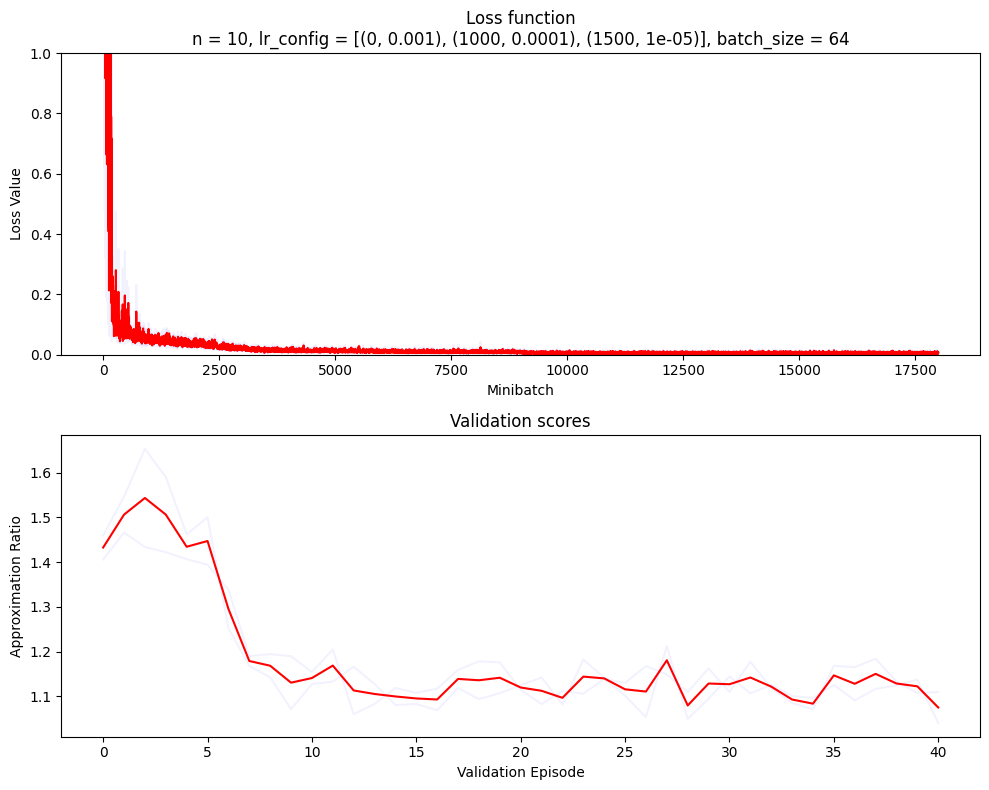

In [116]:
%%time
params = {
    'n': 10,
    'pos_lim': 1e6,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.005,
    'eps_end_at_episode': 1.0,
    'validate_each': 50,
    'print_train_metrics_each': 10,
    'batch_size': 64
}
agents = run_train(6, 2, params)

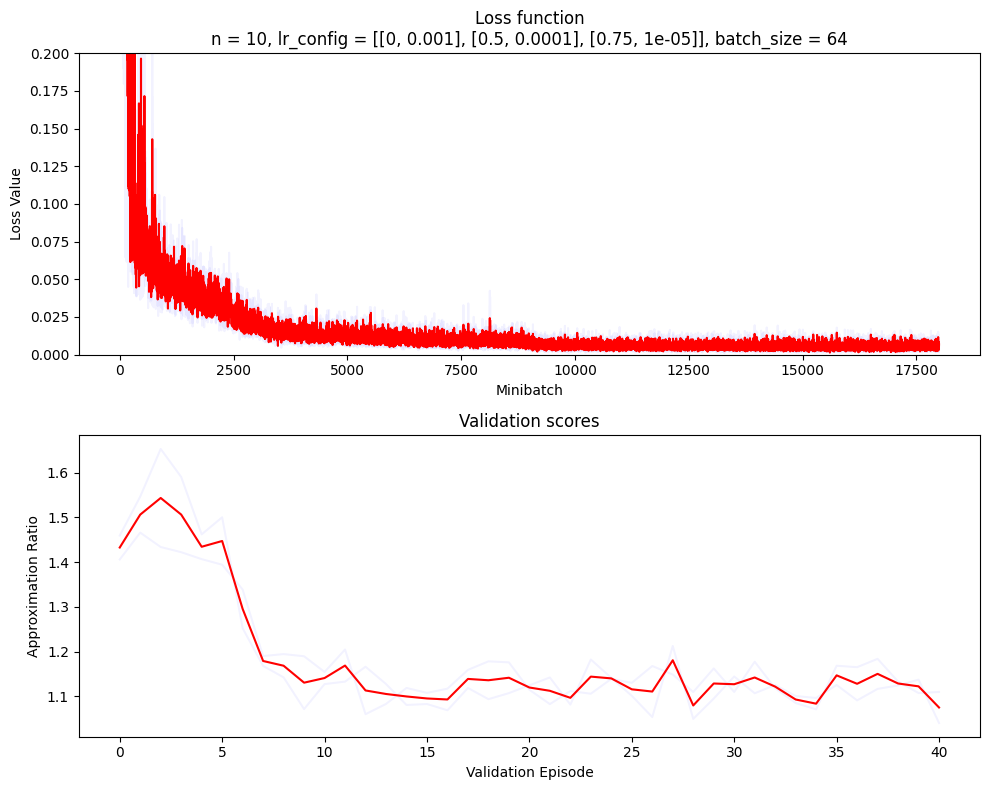

In [117]:
replay_graphs('outputs/run_6', max_loss=2e-1, filename=None)

{'n': 20, 'pos_lim': 1000000.0, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.005, 'eps_end_at_episode': 1.0, 'validate_each': 50, 'print_train_metrics_each': 10, 'batch_size': 64}
Starting run #1/2...
Problem Name: 6f87a42a9b7a4f949f31e9a76c216ee7
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
8559702.550394459 4010221.822350668 2.1344710915210734
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4175731
   0 Steps   Best: 4010222   0.00 seconds
  10 Total Steps.
Best cycle length: 4010222
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4010222.0
LK Run 0: 4010222.0
LK Run from best tour: 4010222.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4010222 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4001847.000000  (0.00 seconds)
  LP Value  2: 4010222.000000  (0.00 seconds)
New lower bound: 4010222.000

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


5986060.881501099 3396108.968269367 1.7626233249375252
6222716.375003317 3828746.437380445 1.6252620738344794
Problem Name: d26bd120ab234719ac96b8c7f68b032f
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4001335
   0 Steps   Best: 3828746   0.00 seconds
  10 Total Steps.
Best cycle length: 3828746
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3828746.0
LK Run 0: 3828746.0
LK Run from best tour: 3828746.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3828746 (from tour)
  LP Value  1: 3269553.000000  (0.00 seconds)
  LP Value  2: 3782344.000000  (0.00 seconds)
  LP Value  3: 3828746.000000  (0.00 seconds)
New lower bound: 3828746.000000
Exact lower bound: 3828746.000000
DIFF: 0.000000
Established Bound: 3828746
Optimal tour: 3828746
Total Time to solve TSP: 0.00
8471023.867207453 3537647.526972364 2.3945358610831518
Problem Name: c4003d7374b94

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 71f11e8c52ad4b89b81ffba84cf8ee4b
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
7158202.255964168 3997766.7710976303 1.7905502411284504
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4729468
   0 Steps   Best: 3997768   0.00 seconds
  10 Total Steps.
Best cycle length: 3997768
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3997768.0
LK Run 0: 3997768.0
LK Run from best tour: 3997768.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3997768 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3701162.500000  (0.00 seconds)
  LP Value  2: 3916443.000000  (0.00 seconds)
  LP Value  3: 3991889.000000  (0.00 seconds)
  LP Value  4: 3997768.000000  (0.00 seconds)
New lower bound: 3997768.000000
Exact lower bound: 3997768.000000
DIFF: 0.000000
Established Bound: 3997768
Optimal tour: 3997768
Total Time to solve TSP: 0.01
6877816.967261374 3754252.8277766877 1.

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution


Problem Name: 1e3db0e5c1234ed38585b6029a5d4ed0
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
7793514.34820981 3355393.7066426743 2.3226825313467647
linkern ...
Starting Cycle: 3451626
   0 Steps   Best: 3355395   0.00 seconds
  10 Total Steps.
Best cycle length: 3355395
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3355395.0
LK Run 0: 3355395.0
LK Run from best tour: 3355395.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3355395 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3355395.000000  (0.00 seconds)
New lower bound: 3355395.000000
Exact lower bound: 3355395.000000
DIFF: 0.000000
Established Bound: 3355395
Optimal tour: 3355395
Total Time to solve TSP: 0.00
Problem Name: 82e2d848c939441c923d88f813a755f4
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
8451112.113970127 3673505.676905735

Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in 

6831286.746972547Problem Name: 55cf9438502844ffb0a9d8db455c28d6
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3933800
   0 Steps   Best: 3807447   0.00 seconds
  10 Total Steps.
Best cycle length: 3807447
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3807447.0
LK Run 0: 3807447.0
LK Run from best tour: 3807447.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3807447 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3669373.500000  (0.00 seconds)
  LP Value  2: 3807447.000000  (0.00 seconds)
New lower bound: 3807447.000000
Exact lower bound: 3807447.000000
DIFF: 0.000000
Established Bound: 3807447
Optimal tour: 3807447
Total Time to solve TSP: 0.00
 3807448.8004101184 1.7941900482645272
8188250.312714473 3478873.2765751546 2.3537075546412423
Problem Name: 1689855840054b5d910f6704fcf0a0e7
Problem Type: TSP
Number of 

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 93fad27b4e534d42b7098036ed234c53
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
7531306.862635475 3816396.1640306497 1.9734080370422966
linkern ...
Starting Cycle: 4256580
   0 Steps   Best: 3960964   0.00 seconds
   1 Steps   Best: 3816395   0.00 seconds
  10 Total Steps.
Best cycle length: 3816395
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3816395.0
LK Run 0: 3816395.0
LK Run from best tour: 3816395.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3816395 (from tour)
  LP Value  1: 2901343.000000  (0.00 seconds)
  LP Value  2: 3800091.000000  (0.00 seconds)
  LP Value  3: 3816395.000000  (0.00 seconds)
New lower bound: 3816395.000000
Exact lower bound: 3816395.000000
DIFF: 0.000000
Established Bound: 3816395
Optimal tour: 3816395
Total Time to solve TSP: 0.01
Problem Name: 9a2f9880264640348850efe79ad9422d
Problem Type: TSP
Number of Nodes: 20
Rounded E

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


8941981.86639464Problem Name: 716e6480805d484ea7f827c136d8540f
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4461942
   0 Steps   Best: 3992259   0.00 seconds
  10 Total Steps.
Best cycle length: 3992259
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3992259.0
LK Run 0: 3992259.0
LK Run from best tour: 3992259.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3992259 (from tour)
  LP Value  1: 3914691.000000  (0.00 seconds)
  LP Value  2: 3992259.000000  (0.00 seconds)
New lower bound: 3992259.000000
Exact lower bound: 3992259.000000
DIFF: 0.000000
Established Bound: 3992259
Optimal tour: 3992259
Total Time to solve TSP: 0.00
 3992257.579871906 2.239830894549031
Problem Name: 7b0cf44f2a19417894a6636efdfbdc17
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
99

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: 0bd53717b73f4f7abe762cb797760012
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
6645858.280008301 4270223.016485068 1.5563258064864913
linkern ...
Starting Cycle: 4564355
   0 Steps   Best: 4270224   0.00 seconds
  10 Total Steps.
Best cycle length: 4270224
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4270224.0
LK Run 0: 4270224.0
LK Run from best tour: 4270224.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4270224 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4087646.000000  (0.00 seconds)
  LP Value  2: 4270224.000000  (0.00 seconds)
New lower bound: 4270224.000000
Exact lower bound: 4270224.000000
DIFF: 0.000000
Established Bound: 4270224
Optimal tour: 4270224
Total Time to solve TSP: 0.00
Problem Name: 5aad57ff028b4b7da79babba8762a7d4
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_sol

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

7291901.878603197Problem Name: a2c47d0ee5724c9da0bdd1590899609a
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 4015109.665041368 1.8161152463884365
linkern ...
Starting Cycle: 4605448
   0 Steps   Best: 4015110   0.00 seconds
  10 Total Steps.
Best cycle length: 4015110
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4015110.0
LK Run 0: 4015110.0
LK Run from best tour: 4015110.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4015110 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3550115.000000  (0.00 seconds)
  LP Value  2: 4015110.000000  (0.00 seconds)
New lower bound: 4015110.000000
Exact lower bound: 4015110.000000
DIFF: 0.000000
Established Bound: 4015110
Optimal tour: 4015110
Total Time to solve TSP: 0.00
5761387.207245084 4137589.784669514 1.3924500753051985
Problem Name: 0a229d35d38a432289fc67768f8fef3a
Problem Type: TSP
Number of No

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 8a919ee482734c4f8fc3bc50656b6fec
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
3537528.4120372976 3281393.703382214 1.0780566831682157
linkern ...
Starting Cycle: 3594965
   0 Steps   Best: 3281392   0.00 seconds
  10 Total Steps.
Best cycle length: 3281392
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3281392.0
LK Run 0: 3281392.0
LK Run from best tour: 3281392.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3281392 (from tour)
  LP Value  1: 2884430.000000  (0.00 seconds)
  LP Value  2: 3184989.500000  (0.00 seconds)
  LP Value  3: 3246185.000000  (0.00 seconds)
  LP Value  4: 3281392.000000  (0.00 seconds)
New lower bound: 3281392.000000
Exact lower bound: 3281392.000000
DIFF: 0.000000
Established Bound: 3281392
Optimal tour: 3281392
Total Time to solve TSP: 0.00
4325014.106791056 4127391.5723981285 1.0478807331280426
Problem Name: 5f70ce02c29740fda66b

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: b16ab47e7b994ab99c0f8fdb69fbfdd7
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3739500
   0 Steps   Best: 3591802   0.00 seconds
  10 Total Steps.
Best cycle length: 3591802
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3591802.0
LK Run 0: 3591802.0
LK Run from best tour: 3591802.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3591802 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3274137.000000  (0.00 seconds)
  LP Value  2: 3591802.000000  (0.00 seconds)
New lower bound: 3591802.000000
Exact lower bound: 3591802.000000
DIFF: 0.000000
Established Bound: 3591802
Optimal tour: 3591802
Total Time to solve TSP: 0.00
5294909.324589979 3591802.0928148897 1.4741651092586692
Problem Name: 2c3940fbf0d14d37968ba783fd3a1696
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_so

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


4296248.705047821Problem Name: 52e5e00c6b26473b9b1892a6d85a5f30
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4364882
   0 Steps   Best: 3677537   0.00 seconds
  10 Total Steps.
Best cycle length: 3677537
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3677537.0
LK Run 0: 3677537.0
LK Run from best tour: 3677537.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3677537 (from tour)
  LP Value  1: 3660495.000000  (0.00 seconds)
  LP Value  2: 3677537.000000  (0.00 seconds)
New lower bound: 3677537.000000
Exact lower bound: 3677537.000000
DIFF: 0.000000
Established Bound: 3677537
Optimal tour: 3677537
Total Time to solve TSP: 0.00
 3677536.2797183082 1.168241011989936
5603746.409369431 3810642.5932573956 1.4705515598037924
Problem Name: 535becb0a9e54b82926920a2140d3084
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCts

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: 9df7861a5f754d4882bbdc1e30b242fc
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
5274900.872301064 3914172.582036031 1.3476413627007793
linkern ...
Starting Cycle: 4856457
   0 Steps   Best: 3914173   0.00 seconds
  10 Total Steps.
Best cycle length: 3914173
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3914173.0
LK Run 0: 3914173.0
LK Run from best tour: 3914173.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3914173 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3860014.500000  (0.00 seconds)
  LP Value  2: 3914173.000000  (0.00 seconds)
New lower bound: 3914173.000000
Exact lower bound: 3914173.000000
DIFF: 0.000000
Established Bound: 3914173
Optimal tour: 3914173
Total Time to solve TSP: 0.00
Problem Name: e08e81f7c26042b6baedbb78397e5be9
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_sol

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: bd5e17b4c2fc49989241bbfadaaa556b
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
4616491.236510635 3512780.510225791 1.3141986022388574
linkern ...
Starting Cycle: 4073679
   0 Steps   Best: 3543036   0.00 seconds
   1 Steps   Best: 3512780   0.00 seconds
  10 Total Steps.
Best cycle length: 3512780
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3512780.0
LK Run 0: 3512780.0
LK Run from best tour: 3512780.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3512780 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3271067.000000  (0.00 seconds)
  LP Value  2: 3512780.000000  (0.00 seconds)
New lower bound: 3512780.000000
Exact lower bound: 3512780.000000
DIFF: 0.000000
Established Bound: 3512780
Optimal tour: 3512780
Total Time to solve TSP: 0.01
Problem Name: 88c67c206f434468919bcaa3236ff732
Problem Type: TSP
Number of Nodes: 20
Round

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Finding a good tour for compression ...
linkern ...
Starting Cycle: 4135909
   0 Steps   Best: 3861653   0.00 seconds
  10 Total Steps.
Best cycle length: 3861653
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3861653.0
LK Run 0: 3861653.0
LK Run from best tour: 3861653.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3861653 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3472331.000000  (0.00 seconds)
  LP Value  2: 3779410.000000  (0.00 seconds)
  LP Value  3: 3857401.000000  (0.00 seconds)
  LP Value  4: 3861653.000000  (0.00 seconds)
New lower bound: 3861653.000000
Exact lower bound: 3861653.000000
DIFF: 0.000000
Established Bound: 3861653
Optimal tour: 3861653
Total Time to solve TSP: 0.01


ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 88946f396c264f3abbd579d8d33f02c7
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
4278310.639428447 3759662.7164439117 1.1379506519869687
linkern ...
Starting Cycle: 4471781
   0 Steps   Best: 3888249   0.00 seconds
   1 Steps   Best: 3807061   0.00 seconds
   2 Steps   Best: 3759663   0.00 seconds
  10 Total Steps.
Best cycle length: 3759663
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3759663.0
LK Run 0: 3759663.0
LK Run from best tour: 3759663.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3759663 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3409595.500000  (0.00 seconds)
  LP Value  2: 3759663.000000  (0.00 seconds)
New lower bound: 3759663.000000
Exact lower bound: 3759663.000000
DIFF: 0.000000
Established Bound: 3759663
Optimal tour: 3759663
Total Time to solve TSP: 0.00
3654204.4621092714 3519912.3708237167 1.0381521

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 76dfa01d75304d67a2ce69b47072848f
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
4937713.114620243 4128981.8869717815 1.1958669836262201
linkern ...
Starting Cycle: 4374515
   0 Steps   Best: 4210550   0.00 seconds
   1 Steps   Best: 4128982   0.00 seconds
  10 Total Steps.
Best cycle length: 4128982
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4128982.0
LK Run 0: 4128982.0
LK Run from best tour: 4128982.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4128982 (from tour)
  LP Value  1: 4074312.000000  (0.00 seconds)
  LP Value  2: 4128982.000000  (0.00 seconds)
New lower bound: 4128982.000000
Exact lower bound: 4128982.000000
DIFF: 0.000000
Established Bound: 4128982
Optimal tour: 4128982
Total Time to solve TSP: 0.00
Problem Name: 678e1ab0ca744356bd5b9f6e6844e60f
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat .

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: 43415f8eb4ef447a8bdd9afc4b3edc94
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
4396109.445087061 3879298.887935315 1.1332226704054786
linkern ...
Starting Cycle: 4316696
   0 Steps   Best: 3879299   0.00 seconds
  10 Total Steps.
Best cycle length: 3879299
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3879299.0
LK Run 0: 3879299.0
LK Run from best tour: 3879299.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3879299 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3711151.000000  (0.00 seconds)
  LP Value  2: 3879299.000000  (0.00 seconds)
New lower bound: 3879299.000000
Exact lower bound: 3879299.000000
DIFF: 0.000000
Established Bound: 3879299
Optimal tour: 3879299
Total Time to solve TSP: 0.00
Problem Name: 4778dd27ae7e4c22bae50f36b261e516
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_sol

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: 1964f6ad3739401796c0cbdcb688945e
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
4776101.46873657 3738488.08832224 1.2775489331249925
linkern ...
Starting Cycle: 4295605
   0 Steps   Best: 3738489   0.00 seconds
  10 Total Steps.
Best cycle length: 3738489
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3738489.0
LK Run 0: 3738489.0
LK Run from best tour: 3738489.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3738489 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3640582.000000  (0.00 seconds)
  LP Value  2: 3738489.000000  (0.00 seconds)
New lower bound: 3738489.000000
Exact lower bound: 3738489.000000
DIFF: 0.000000
Established Bound: 3738489
Optimal tour: 3738489
Total Time to solve TSP: 0.00
4210478.216920857 3686864.2836619085 1.1420214830199498
Problem Name: d5c8080cd2b5402ca7aaa4547e04b71e
Problem Type: TSP
Number of Nod

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 4e659ba0a2a14c3d88b7ff69e8b3bd33
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
4479477.9883301845 4117213.7902772767 1.0879877063727874
linkern ...
Starting Cycle: 4284634
   0 Steps   Best: 4117214   0.00 seconds
  10 Total Steps.
Best cycle length: 4117214
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4117214.0
LK Run 0: 4117214.0
LK Run from best tour: 4117214.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4117214 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3390139.000000  (0.00 seconds)
  LP Value  2: 4117214.000000  (0.00 seconds)
New lower bound: 4117214.000000
Exact lower bound: 4117214.000000
DIFF: 0.000000
Established Bound: 4117214
Optimal tour: 4117214
Total Time to solve TSP: 0.01
Problem Name: 5a9e6d1b59db4305993c5d1c8f2a8005
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_s

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: a09833a572dd4ed9a62d0aa24bf9020a
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
5312971.5386241255 4087092.771985073 1.2999390606060677
linkern ...
Starting Cycle: 4423597
   0 Steps   Best: 4094140   0.00 seconds
   1 Steps   Best: 4087092   0.00 seconds
  10 Total Steps.
Best cycle length: 4087092
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4087092.0
LK Run 0: 4087092.0
LK Run from best tour: 4087092.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4087092 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3900358.000000  (0.00 seconds)
  LP Value  2: 4087092.000000  (0.00 seconds)
New lower bound: 4087092.000000
Exact lower bound: 4087092.000000
DIFF: 0.000000
Established Bound: 4087092
Optimal tour: 4087092
Total Time to solve TSP: 0.01
Problem Name: bb8e32412783485390926181d58dffc5
Problem Type: TSP
Number of Nodes: 20
Roun

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: 47755be135ff4fae9a0686f4cb021979
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
4821351.915616465 3692129.3475085534 1.305845885077106
linkern ...
Starting Cycle: 4203931
   0 Steps   Best: 3692128   0.00 seconds
  10 Total Steps.
Best cycle length: 3692128
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3692128.0
LK Run 0: 3692128.0
LK Run from best tour: 3692128.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3692128 (from tour)
  LP Value  1: 3602997.000000  (0.00 seconds)
  LP Value  2: 3692128.000000  (0.00 seconds)
New lower bound: 3692128.000000
Exact lower bound: 3692128.000000
DIFF: 0.000000
Established Bound: 3692128
Optimal tour: 3692128
Total Time to solve TSP: 0.01
4198191.925716291 3955398.5472747153 1.0613827849557314
Problem Name: 700e922f167e43fdae5e09e7c70dcd3b
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCts

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Finding a good tour for compression ...
linkern ...
Starting Cycle: 3910795
   0 Steps   Best: 3798293   0.00 seconds
  10 Total Steps.
Best cycle length: 3798293
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3798293.0
LK Run 0: 3798293.0
LK Run from best tour: 3798293.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3798293 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3599384.000000  (0.00 seconds)
  LP Value  2: 3798293.000000  (0.00 seconds)
New lower bound: 3798293.000000
Exact lower bound: 3798293.000000
DIFF: 0.000000
Established Bound: 3798293
Optimal tour: 3798293
Total Time to solve TSP: 0.00
Problem Name: 97224a749123498da3cc1bd7bb35d716
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
5095228.667119136 4305113.1518329065 1.183529558322953
linkern ...
Starting Cycle: 4574605
   0 Steps   Best: 4305112   0.00 seconds
  10 Total Ste

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: 375751695763492ba17371946fe5dbca
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
4022805.474193382 3648859.721335068 1.1024829073783884
linkern ...
Starting Cycle: 3683473
   0 Steps   Best: 3648859   0.00 seconds
  10 Total Steps.
Best cycle length: 3648859
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3648859.0
LK Run 0: 3648859.0
LK Run from best tour: 3648859.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3648859 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3483941.000000  (0.00 seconds)
  LP Value  2: 3635800.000000  (0.00 seconds)
  LP Value  3: 3648859.000000  (0.00 seconds)
New lower bound: 3648859.000000
Exact lower bound: 3648859.000000
DIFF: 0.000000
Established Bound: 3648859
Optimal tour: 3648859
Total Time to solve TSP: 0.00
Problem Name: ddf629eaf27e44fabc6d3ef6bf055e29
Problem Type: TSP
Number of Nodes: 20
R

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 750c91f9acad4c97973f25f0924a4080
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
4446408.907467135 3995722.943612456 1.1127920955018025
linkern ...
Starting Cycle: 4243814
   0 Steps   Best: 3995723   0.00 seconds
  10 Total Steps.
Best cycle length: 3995723
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3995723.0
LK Run 0: 3995723.0
LK Run from best tour: 3995723.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3995723 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3788152.000000  (0.00 seconds)
  LP Value  2: 3995723.000000  (0.00 seconds)
New lower bound: 3995723.000000
Exact lower bound: 3995723.000000
DIFF: 0.000000
Established Bound: 3995723
Optimal tour: 3995723
Total Time to solve TSP: 0.01
Problem Name: a624a4915e574f2a8e5a940b7a9f6d24
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_sol

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: e1f36039ca78444a81fa2739d23fa6c8
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
4961396.350852396 3816581.483526959 1.2999581883071698
linkern ...
Starting Cycle: 4287058
   0 Steps   Best: 3816580   0.00 seconds
  10 Total Steps.
Best cycle length: 3816580
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3816580.0
LK Run 0: 3816580.0
LK Run from best tour: 3816580.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3816580 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3649786.000000  (0.00 seconds)
  LP Value  2: 3816211.500000  (0.00 seconds)
  LP Value  3: 3816580.000000  (0.00 seconds)
New lower bound: 3816580.000000
Exact lower bound: 3816580.000000
DIFF: 0.000000
Established Bound: 3816580
Optimal tour: 3816580
Total Time to solve TSP: 0.01
Problem Name: 9ef506495ae749e8a34dc912fc60f92b
Problem Type: TSP
Number of Nodes: 20
R

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 155ca022ebd84cb0810cc35e380b308f
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
4705276.939600751 4273870.78229632 1.1009403838533085
linkern ...
Starting Cycle: 4612851
   0 Steps   Best: 4273870   0.00 seconds
  10 Total Steps.
Best cycle length: 4273870
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4273870.0
LK Run 0: 4273870.0
LK Run from best tour: 4273870.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4273870 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4158240.500000  (0.00 seconds)
  LP Value  2: 4247127.500000  (0.00 seconds)
  LP Value  3: 4273870.000000  (0.00 seconds)
New lower bound: 4273870.000000
Exact lower bound: 4273870.000000
DIFF: 0.000000
Established Bound: 4273870
Optimal tour: 4273870
Total Time to solve TSP: 0.01


ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: b0749bd3f529403786a198f116beede5
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
5448576.15064696 4229917.789260352 1.2881045027590723
linkern ...
Starting Cycle: 4710331
   0 Steps   Best: 4229918   0.00 seconds
  10 Total Steps.
Best cycle length: 4229918
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4229918.0
LK Run 0: 4229918.0
LK Run from best tour: 4229918.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4229918 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 4006697.000000  (0.00 seconds)
  LP Value  2: 4218790.000000  (0.00 seconds)
  LP Value  3: 4229918.000000  (0.00 seconds)
New lower bound: 4229918.000000
Exact lower bound: 4229918.000000
DIFF: 0.000000
Established Bound: 4229918
Optimal tour: 4229918
Total Time to solve TSP: 0.00
4022140.680204401 3398883.507302346 1.1833711486619105
Problem Name: 17a08d02aede4b99bd

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: b28ef464339c421fab9747eb194c5682
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
3905462.247174889 3618871.675097888 1.0791933502503233
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3927482
   0 Steps   Best: 3618874   0.00 seconds
  10 Total Steps.
Best cycle length: 3618874
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3618874.0
LK Run 0: 3618874.0
LK Run from best tour: 3618874.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3618874 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3451910.000000  (0.00 seconds)
  LP Value  2: 3561686.000000  (0.00 seconds)
  LP Value  3: 3571956.000000  (0.00 seconds)
  LP Value  4: 3602799.000000  (0.00 seconds)
  LP Value  5: 3618874.000000  (0.00 seconds)
New lower bound: 3618874.000000
Exact lower bound: 3618874.000000
DIFF: 0.000000
Established Bound: 3618874
Optimal tour: 3618874
Total Time to solve TSP:

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


4762045.72541434Problem Name: d9b0c6c49fff44fba98c57efba9e9ee6
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4028904
   0 Steps   Best: 3907624   0.00 seconds
  10 Total Steps.
Best cycle length: 3907624
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3907624.0
LK Run 0: 3907624.0
LK Run from best tour: 3907624.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3907624 (from tour)
  LP Value  1: 3730534.000000  (0.00 seconds)
  LP Value  2: 3907624.000000  (0.00 seconds)
New lower bound: 3907624.000000
Exact lower bound: 3907624.000000
DIFF: 0.000000
Established Bound: 3907624
Optimal tour: 3907624
Total Time to solve TSP: 0.00
 3907621.1434771256 1.2186559419567784
5267384.029585688 3911441.0268121446 1.346660730272763
Problem Name: 58187d22e0aa4509861dc32111ceb38f
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: ffa82656e1434a068c5b6272bca8028a
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
4343613.462832922 3895308.603481262 1.1150884063334565
linkern ...
Starting Cycle: 4617821
   0 Steps   Best: 3895308   0.00 seconds
  10 Total Steps.
Best cycle length: 3895308
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3895308.0
LK Run 0: 3895308.0
LK Run from best tour: 3895308.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3895308 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3741443.500000  (0.00 seconds)
  LP Value  2: 3895308.000000  (0.00 seconds)
New lower bound: 3895308.000000
Exact lower bound: 3895308.000000
DIFF: 0.000000
Established Bound: 3895308
Optimal tour: 3895308
Total Time to solve TSP: 0.01
3861645.9088812876 3733715.4939597347 1.034263568053997
Problem Name: 1adc47d49670478ba22f4abd3ede07c2
Problem Type: TSP
Number of N

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 7cae262035dc4bc9af32c78319f57087
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
5046859.462427127 3797634.455517576 1.3289481969741859
linkern ...
Starting Cycle: 5043468
   0 Steps   Best: 3797636   0.00 seconds
  10 Total Steps.
Best cycle length: 3797636
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3797636.0
LK Run 0: 3797636.0
LK Run from best tour: 3797636.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3797636 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3782949.000000  (0.00 seconds)
  LP Value  2: 3797636.000000  (0.00 seconds)
New lower bound: 3797636.000000
Exact lower bound: 3797636.000000
DIFF: 0.000000
Established Bound: 3797636
Optimal tour: 3797636
Total Time to solve TSP: 0.00
Problem Name: f8a2c00fda024a27a377843b7310352a
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_sol

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution


Problem Name: f1a267e90753445292c4d8b23d9f9ed0
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
4719028.254529415 4020276.8760428983 1.1738067799883194
linkern ...
Starting Cycle: 4482732
   0 Steps   Best: 4020275   0.00 seconds
  10 Total Steps.
Best cycle length: 4020275
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4020275.0
LK Run 0: 4020275.0
LK Run from best tour: 4020275.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 4020275 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3860022.000000  (0.00 seconds)
  LP Value  2: 4020275.000000  (0.00 seconds)
New lower bound: 4020275.000000
Exact lower bound: 4020275.000000
DIFF: 0.000000
Established Bound: 4020275
Optimal tour: 4020275
Total Time to solve TSP: 0.01
Problem Name: 4d35ee23c6894c7294e9b48d3e19f2ea
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_so

Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


linkern ...
Starting Cycle: 4403944
   0 Steps   Best: 3657280   0.00 seconds
  10 Total Steps.
Best cycle length: 3657280
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3657280.0
LK Run 0: 3657280.0
LK Run from best tour: 3657280.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3657280 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3462734.000000  (0.00 seconds)
  LP Value  2: 3561205.000000  (0.00 seconds)
  LP Value  3: 3637464.000000  (0.00 seconds)
  LP Value  4: 3657280.000000  (0.00 seconds)
New lower bound: 3657280.000000
Exact lower bound: 3657280.000000
DIFF: 0.000000
Established Bound: 3657280
Optimal tour: 3657280
Total Time to solve TSP: 0.01
Problem Name: 063d00e13967427f81a6a9cc0932d136
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4711126
   0 Steps   Best: 4414937   0.00 seconds
  10 Total Steps.

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: 6a519960c30d483eacd2e0ddd19a849c
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
4955862.772462528 4036348.9960724553 1.2278082934069379
Finding a good tour for compression ...
linkern ...
Starting Cycle: 5000924
   0 Steps   Best: 4036348   0.00 seconds
  10 Total Steps.
Best cycle length: 4036348
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4036348.0
LK Run 0: 4036348.0
LK Run from best tour: 4036348.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4036348 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3916526.500000  (0.00 seconds)
  LP Value  2: 4036348.000000  (0.00 seconds)
New lower bound: 4036348.000000
Exact lower bound: 4036348.000000
DIFF: 0.000000
Established Bound: 4036348
Optimal tour: 4036348
Total Time to solve TSP: 0.00
Problem Name: f11fa3ea598b416989408ae580380d2b
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_so

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: 925d4644f8914cdf8ef8b77217683c01
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
4320172.041546282 3775572.975953183 1.1442427597245977
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4059501
   0 Steps   Best: 4051773   0.00 seconds
   1 Steps   Best: 3775574   0.00 seconds
  10 Total Steps.
Best cycle length: 3775574
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3775574.0
LK Run 0: 3775574.0
LK Run from best tour: 3775574.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3775574 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3447921.500000  (0.00 seconds)
  LP Value  2: 3686032.500000  (0.00 seconds)
  LP Value  3: 3775574.000000  (0.00 seconds)
New lower bound: 3775574.000000
Exact lower bound: 3775574.000000
DIFF: 0.000000
Established Bound: 3775574
Optimal tour: 3775574
Total Time to solve TSP: 0.00
Problem Name: d2c0dd7dabbb447d972e1975ff13a5

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution


Problem Name: 38353721ec5d420b8854d9f5059d0a46
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
3790370.2894398393 3553180.437078393 1.0667542379458994
linkern ...
Starting Cycle: 3890998
   0 Steps   Best: 3553181   0.00 seconds
  10 Total Steps.
Best cycle length: 3553181
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3553181.0
LK Run 0: 3553181.0
LK Run from best tour: 3553181.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3553181 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3402738.000000  (0.00 seconds)
  LP Value  2: 3527300.500000  (0.00 seconds)
  LP Value  3: 3553181.000000  (0.00 seconds)
New lower bound: 3553181.000000
Exact lower bound: 3553181.000000
DIFF: 0.000000
Established Bound: 3553181
Optimal tour: 3553181
Total Time to solve TSP: 0.00
Problem Name: 5f1cc4be6f7e4930bb6727909602c34b
Problem Type: TSP
Number of Nodes: 20


Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 01f213001bf14657afed4d3254de57ad
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
5197777.382281003 4193099.465333529 1.239602691339343
linkern ...
Starting Cycle: 5063478
   0 Steps   Best: 4193101   0.00 seconds
  10 Total Steps.
Best cycle length: 4193101
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4193101.0
LK Run 0: 4193101.0
LK Run from best tour: 4193101.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4193101 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3625197.500000  (0.00 seconds)
  LP Value  2: 4193101.000000  (0.00 seconds)
New lower bound: 4193101.000000
Exact lower bound: 4193101.000000
DIFF: 0.000000
Established Bound: 4193101
Optimal tour: 4193101
Total Time to solve TSP: 0.00
Problem Name: e0380f8e8b6d4d1f9b6d8be406652cc8
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solv

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 1bd8e49a0a2f46dda4b465de5ddd290f
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
4886709.31467458 4076735.5318140695 1.1986819543577523
linkern ...
Starting Cycle: 4734291
   0 Steps   Best: 4076737   0.00 seconds
  10 Total Steps.
Best cycle length: 4076737
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4076737.0
LK Run 0: 4076737.0
LK Run from best tour: 4076737.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4076737 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3904206.000000  (0.00 seconds)
  LP Value  2: 4076737.000000  (0.00 seconds)
New lower bound: 4076737.000000
Exact lower bound: 4076737.000000
DIFF: 0.000000
Established Bound: 4076737
Optimal tour: 4076737
Total Time to solve TSP: 0.00


ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 2a5c1d94691d4d5899776a39bff6a17c
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
3891633.396638431 3208574.0612596115 1.2128856377747648
linkern ...
Starting Cycle: 3765920
   0 Steps   Best: 3208576   0.00 seconds
  10 Total Steps.
Best cycle length: 3208576
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3208576.0
LK Run 0: 3208576.0
LK Run from best tour: 3208576.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3208576 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3075902.000000  (0.00 seconds)
  LP Value  2: 3165278.000000  (0.00 seconds)
  LP Value  3: 3208576.000000  (0.00 seconds)
New lower bound: 3208576.000000
Exact lower bound: 3208576.000000
DIFF: 0.000000
Established Bound: 3208576
Optimal tour: 3208576
Total Time to solve TSP: 0.01
Problem Name: a851b1e3b4234935a3024d7ffae33470
Problem Type: TSP
Number of Nodes: 20


ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Finding a good tour for compression ...
linkern ...
Starting Cycle: 4274970
   0 Steps   Best: 3636826   0.00 seconds
  10 Total Steps.
Best cycle length: 3636826
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3636826.0
LK Run 0: 3636826.0
LK Run from best tour: 3636826.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3636826 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3545144.000000  (0.00 seconds)
  LP Value  2: 3636826.000000  (0.00 seconds)
New lower bound: 3636826.000000
Exact lower bound: 3636826.000000
DIFF: 0.000000
Established Bound: 3636826
Optimal tour: 3636826
Total Time to solve TSP: 0.00
Problem Name: 1bc3d5e25689447fbaf5ecbfc0c36d1a
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
8174003.503293275 4098238.191398818 1.9945164535454465
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4320328
   0 Steps   Best: 4128693   0.00 seconds
   1 Steps   B

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


6741221.5147304Problem Name: 0a6f9c33c47c45df993448204937c100
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4201286
   0 Steps   Best: 4132018   0.00 seconds
  10 Total Steps.
Best cycle length: 4132018
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4132018.0
LK Run 0: 4132018.0
LK Run from best tour: 4132018.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4132018 (from tour)
  LP Value  1: 3819104.000000  (0.00 seconds)
  LP Value  2: 4132018.000000  (0.00 seconds)
New lower bound: 4132018.000000
Exact lower bound: 4132018.000000
DIFF: 0.000000
Established Bound: 4132018
Optimal tour: 4132018
Total Time to solve TSP: 0.00
 4132018.2462470336 1.6314597644512374
8862652.138647612 3884247.7720747753 2.281690731050768
Problem Name: 5f408984f17f47188b4481b2081d1884
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


8869441.426673144Problem Name: 877e2f4e876940f19b353d2003f29158
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 4067602.468632858 2.180508418674013
linkern ...
Starting Cycle: 4293606
   0 Steps   Best: 4067604   0.00 seconds
  10 Total Steps.
Best cycle length: 4067604
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4067604.0
LK Run 0: 4067604.0
LK Run from best tour: 4067604.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4067604 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3494128.500000  (0.00 seconds)
  LP Value  2: 4067604.000000  (0.00 seconds)
New lower bound: 4067604.000000
Exact lower bound: 4067604.000000
DIFF: 0.000000
Established Bound: 4067604
Optimal tour: 4067604
Total Time to solve TSP: 0.00
5958115.5447006915 3605048.959753257 1.6527141825858827
Problem Name: 894536a8b6b047b090361a5e98225b87
Problem Type: TSP
Number of No

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: e419bb6b0d7b4c73bdb101aaf536f0f4
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
6814591.695001573 3921196.0445151357 1.7378859964254127
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3921195
   0 Steps   Best: 3921195   0.00 seconds
  10 Total Steps.
Best cycle length: 3921195
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3921195.0
LK Run 0: 3921195.0
LK Run from best tour: 3921195.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3921195 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3889904.000000  (0.00 seconds)
  LP Value  2: 3921195.000000  (0.00 seconds)
New lower bound: 3921195.000000
Exact lower bound: 3921195.000000
DIFF: 0.000000
Established Bound: 3921195
Optimal tour: 3921195
Total Time to solve TSP: 0.01
7542519.326312996 4358365.853981824 1.7305842554319104
Problem Name: ea4682cbb07d40f7b92f719ad44848bc
Problem Type: TSP
Number of N

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

8223421.517272168Problem Name: c5a1cedbc5b54ffda99ccf94df062289
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3706009
   0 Steps   Best: 3704897   0.00 seconds
  10 Total Steps.
Best cycle length: 3704897
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3704897.0
LK Run 0: 3704897.0
LK Run from best tour: 3704897.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3704897 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3428848.000000  (0.00 seconds)
  LP Value  2: 3704897.000000  (0.00 seconds)
New lower bound: 3704897.000000
Exact lower bound: 3704897.000000
DIFF: 0.000000
Established Bound: 3704897
Optimal tour: 3704897
Total Time to solve TSP: 0.00
 3704897.7847958277 2.219608203772712
9078075.515036553 3739301.905710259 2.42774607238145
Problem Name: 8379287a203e47118c48b05fa6f4b4d6
Problem Type: TSP
Number of Node

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


10500622.42658311Problem Name: 1497119f18c34da09b97fd5c17242a39
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
 4068458.2181252204 2.5809832284382863
linkern ...
Starting Cycle: 4332335
   0 Steps   Best: 4068456   0.00 seconds
  10 Total Steps.
Best cycle length: 4068456
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4068456.0
LK Run 0: 4068456.0
LK Run from best tour: 4068456.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4068456 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3864145.500000  (0.00 seconds)
  LP Value  2: 4068456.000000  (0.00 seconds)
New lower bound: 4068456.000000
Exact lower bound: 4068456.000000
DIFF: 0.000000
Established Bound: 4068456
Optimal tour: 4068456
Total Time to solve TSP: 0.00
9218594.040342128 4176066.914635312 2.2074823581094773
Problem Name: a174130dc4704845b426327ca6d9f76c
Problem Type: TSP
Number of N

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

9023777.553290257Problem Name: 863d4c1e2dd94ce18be188a492f8f9ea
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4224042
   0 Steps   Best: 4154110   0.00 seconds
  10 Total Steps.
Best cycle length: 4154110
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4154110.0
LK Run 0: 4154110.0
LK Run from best tour: 4154110.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4154110 (from tour)
  LP Value  1: 3891110.500000  (0.00 seconds)
  LP Value  2: 4112500.000000  (0.00 seconds)
  LP Value  3: 4143261.500000  (0.00 seconds)
  LP Value  4: 4154110.000000  (0.00 seconds)
New lower bound: 4154110.000000
Exact lower bound: 4154110.000000
DIFF: 0.000000
Established Bound: 4154110
Optimal tour: 4154110
Total Time to solve TSP: 0.00
 4154109.2440656195 2.172253309462488
11092456.083562505 4312021.119437064 2.5724493865676217
Problem Name: f73f8876b50d4178a33d5

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


7590796.741294411Problem Name: c109be2a1df04bff867e7e847190ef89
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4268090
   0 Steps   Best: 3674450   0.00 seconds
  10 Total Steps.
Best cycle length: 3674450
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3674450.0
LK Run 0: 3674450.0
LK Run from best tour: 3674450.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3674450 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3357506.000000  (0.00 seconds)
  LP Value  2: 3674450.000000  (0.00 seconds)
New lower bound: 3674450.000000
Exact lower bound: 3674450.000000
DIFF: 0.000000
Established Bound: 3674450
Optimal tour: 3674450
Total Time to solve TSP: 0.00
 3674448.4128580024 2.065832987267402
Problem Name: 00e4cc2fe27f477196f7ad38d0531c2e
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_sol

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

8498917.053445382Problem Name: 87443cfdc709402f903cb395a2c71985
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4973535
   0 Steps   Best: 3938494   0.00 seconds
  10 Total Steps.
Best cycle length: 3938494
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3938494.0
LK Run 0: 3938494.0
LK Run from best tour: 3938494.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3938494 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3687248.000000  (0.00 seconds)
  LP Value  2: 3938494.000000  (0.00 seconds)
New lower bound: 3938494.000000
Exact lower bound: 3938494.000000
DIFF: 0.000000
Established Bound: 3938494
Optimal tour: 3938494
Total Time to solve TSP: 0.00
 3938494.8365683705 2.157909913841738
Problem Name: 3c9212838c73470694bbffd54cc13a5c
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_sol

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


8897214.451973753Problem Name: 36c90ac7230d4b85b12f61f05222aa1a
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4397495
   0 Steps   Best: 3767796   0.00 seconds
  10 Total Steps.
Best cycle length: 3767796
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3767796.0
LK Run 0: 3767796.0
LK Run from best tour: 3767796.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3767796 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3745125.500000  (0.00 seconds)
  LP Value  2: 3767796.000000  (0.00 seconds)
New lower bound: 3767796.000000
Exact lower bound: 3767796.000000
DIFF: 0.000000
Established Bound: 3767796
Optimal tour: 3767796
Total Time to solve TSP: 0.00
 3767795.991273815 2.3613843404949817
Problem Name: b0d31ad0ce424f05b6047736c19f96ce
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_sol

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


7264162.171996039Problem Name: 32295c2c7fe349bc8f9918267d8542de
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4097116
   0 Steps   Best: 3987415   0.00 seconds
   1 Steps   Best: 3935848   0.00 seconds
  10 Total Steps.
Best cycle length: 3935848
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3935848.0
LK Run 0: 3935848.0
LK Run from best tour: 3935848.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3935848 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3165959.000000  (0.00 seconds)
  LP Value  2: 3935848.000000  (0.00 seconds)
New lower bound: 3935848.000000
Exact lower bound: 3935848.000000
DIFF: 0.000000
Established Bound: 3935848
Optimal tour: 3935848
Total Time to solve TSP: 0.00
 3935845.80039832 1.845641963732645
12440939.386273349 3973489.48665192 3.1309858571580467
Problem Name: b81addbcdaf8446c9638834

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: 39461c12abcc48f0ab3ee1ed2be0f097
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
6871964.157856494 3437336.386865843 1.999212001512118
linkern ...
Starting Cycle: 3704791
   0 Steps   Best: 3476136   0.00 seconds
   7 Steps   Best: 3437337   0.00 seconds
  10 Total Steps.
Best cycle length: 3437337
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3437337.0
LK Run 0: 3437337.0
LK Run from best tour: 3437337.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3437337 (from tour)
  LP Value  1: 3076202.000000  (0.00 seconds)
  LP Value  2: 3407831.500000  (0.00 seconds)
  LP Value  3: 3437337.000000  (0.00 seconds)
New lower bound: 3437337.000000
Exact lower bound: 3437337.000000
DIFF: 0.000000
Established Bound: 3437337
Optimal tour: 3437337
Total Time to solve TSP: 0.01
Problem Name: 609cf7e918c7486c81aa1350e0d6323d
Problem Type: TSP
Number of Nodes: 20
Rounded Euc

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

8624474.807853695Problem Name: 16909e5978824050bf9895e1c14cbbfd
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4946224
   0 Steps   Best: 4802014   0.00 seconds
   1 Steps   Best: 4153709   0.00 seconds
   3 Steps   Best: 4130453   0.00 seconds
  10 Total Steps.
Best cycle length: 4130453
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4130453.0
LK Run 0: 4130453.0
LK Run from best tour: 4130453.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4130453 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3918022.000000  (0.00 seconds)
  LP Value  2: 4114264.000000  (0.00 seconds)
  LP Value  3: 4130453.000000  (0.00 seconds)
New lower bound: 4130453.000000
Exact lower bound: 4130453.000000
DIFF: 0.000000
Established Bound: 4130453
Optimal tour: 4130453
Total Time to solve TSP: 0.00
 4130453.8930193116 2.088021082242201
92

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: d274065bbffc4a26b91e0a53e58cd29d
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
9445736.106235845 3765000.4263727735 2.5088273669429384
linkern ...
Starting Cycle: 4320670
   0 Steps   Best: 3764999   0.00 seconds
  10 Total Steps.
Best cycle length: 3764999
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3764999.0
LK Run 0: 3764999.0
LK Run from best tour: 3764999.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3764999 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 2969473.000000  (0.00 seconds)
  LP Value  2: 3764999.000000  (0.00 seconds)
New lower bound: 3764999.000000
Exact lower bound: 3764999.000000
DIFF: 0.000000
Established Bound: 3764999
Optimal tour: 3764999
Total Time to solve TSP: 0.00
8625682.313106721 4055550.8360826443 2.1268830454208976
Problem Name: 4b198c49f66940699b218a4493d9e262
Problem Type: TSP
Number of 

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: c1ebe8150e54418faa2839d9d73a9fac
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
9274752.056848666 4133701.853823738 2.243691583191801
linkern ...
Starting Cycle: 4803936
   0 Steps   Best: 4133701   0.00 seconds
  10 Total Steps.
Best cycle length: 4133701
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4133701.0
LK Run 0: 4133701.0
LK Run from best tour: 4133701.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4133701 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3873564.000000  (0.00 seconds)
  LP Value  2: 4081147.000000  (0.00 seconds)
  LP Value  3: 4110737.500000  (0.00 seconds)
  LP Value  4: 4133701.000000  (0.00 seconds)
New lower bound: 4133701.000000
Exact lower bound: 4133701.000000
DIFF: 0.000000
Established Bound: 4133701
Optimal tour: 4133701
Total Time to solve TSP: 0.01
11143057.307113457 4199785.068265081 2.65

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


7146535.6781113045Problem Name: 934c7bf24c2c471b8c4a73ade93bfb86
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4522190
   0 Steps   Best: 3923668   0.00 seconds
  10 Total Steps.
Best cycle length: 3923668
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3923668.0
LK Run 0: 3923668.0
LK Run from best tour: 3923668.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3923668 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3917392.000000  (0.00 seconds)
  LP Value  2: 3923668.000000  (0.00 seconds)
New lower bound: 3923668.000000
Exact lower bound: 3923668.000000
DIFF: 0.000000
Established Bound: 3923668
Optimal tour: 3923668
Total Time to solve TSP: 0.00
 3923669.5220152037 1.8213908276456552
Problem Name: 79979f3ffc924b1b94631cbab32b272e
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_s

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: bacc78663dd64ed5972d03e23f1f8b74
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
8750392.796607886 3753950.224840342 2.3309826376240896
linkern ...
Starting Cycle: 4236384
   0 Steps   Best: 3767092   0.00 seconds
   3 Steps   Best: 3763481   0.00 seconds
   6 Steps   Best: 3753954   0.00 seconds
  10 Total Steps.
Best cycle length: 3753954
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3753954.0
LK Run 0: 3753954.0
LK Run from best tour: 3753954.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3753954 (from tour)
  LP Value  1: 3416259.000000  (0.00 seconds)
  LP Value  2: 3730144.750000  (0.00 seconds)
  LP Value  3: 3747964.333333  (0.00 seconds)
  LP Value  4: 3752742.000000  (0.01 seconds)
  LP Value  5: 3753954.000000  (0.01 seconds)
New lower bound: 3753954.000000
Exact lower bound: 3753954.000000
DIFF: 0.000000
Established Bound: 3753954
Optimal tour:

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


9749421.07765514Problem Name: dd93b8a02b2441eaac27c9bfe5e3cc4c
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4152993
   0 Steps   Best: 3767466   0.00 seconds
  10 Total Steps.
Best cycle length: 3767466
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3767466.0
LK Run 0: 3767466.0
LK Run from best tour: 3767466.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3767466 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3511439.000000  (0.00 seconds)
  LP Value  2: 3767466.000000  (0.00 seconds)
New lower bound: 3767466.000000
Exact lower bound: 3767466.000000
DIFF: 0.000000
Established Bound: 3767466
Optimal tour: 3767466
Total Time to solve TSP: 0.00
 3767466.211841052 2.5877925718385884
10302834.18784091 4032523.1834080187 2.5549348929306452
Problem Name: 631015497dc14ff483cdf944f5dcc58f
Problem Type: TSP
Number of No

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


10372469.94137307Problem Name: e40da3e9203d4bc499527bebd4e18bc6
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4105048
   0 Steps   Best: 3974629   0.00 seconds
  10 Total Steps.
Best cycle length: 3974629
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3974629.0
LK Run 0: 3974629.0
LK Run from best tour: 3974629.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3974629 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3808351.500000  (0.00 seconds)
  LP Value  2: 3974629.000000  (0.00 seconds)
New lower bound: 3974629.000000
Exact lower bound: 3974629.000000
DIFF: 0.000000
Established Bound: 3974629
Optimal tour: 3974629
Total Time to solve TSP: 0.00
 3974628.546898071 2.609670267041201
Problem Name: c2cd6e9aaa184102987604cdacb81789
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solv

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


7805990.107152752Problem Name: c5cd8142c0cf44d39d8aad4bf39581e6
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
 3209902.2439544583 2.4318466775287573
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3409672
   0 Steps   Best: 3209902   0.00 seconds
  10 Total Steps.
Best cycle length: 3209902
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3209902.0
LK Run 0: 3209902.0
LK Run from best tour: 3209902.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3209902 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3179335.000000  (0.00 seconds)
  LP Value  2: 3209902.000000  (0.00 seconds)
New lower bound: 3209902.000000
Exact lower bound: 3209902.000000
DIFF: 0.000000
Established Bound: 3209902
Optimal tour: 3209902
Total Time to solve TSP: 0.00
Problem Name: 9887740bf6b04989b496d16b4805a9f5
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_so

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: 9838b70d6a0c4ff6b4b5b21177b79635
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
7573106.507853673 3747731.0511070536 2.020717710150687
linkern ...
Starting Cycle: 4005834
   0 Steps   Best: 3747730   0.00 seconds
  10 Total Steps.
Best cycle length: 3747730
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3747730.0
LK Run 0: 3747730.0
LK Run from best tour: 3747730.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3747730 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3003577.000000  (0.00 seconds)
  LP Value  2: 3747730.000000  (0.00 seconds)
New lower bound: 3747730.000000
Exact lower bound: 3747730.000000
DIFF: 0.000000
Established Bound: 3747730
Optimal tour: 3747730
Total Time to solve TSP: 0.00
8872170.844406195 3689559.84284291 2.4046691806928213
Problem Name: 52d0ee6d6d0947c79ea9b33e19393d01
Problem Type: TSP
Number of Nod

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: 1b31b3a4daf94466856923296b2db30c
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
6606393.502837738 3470738.5058582616 1.9034546946382744
linkern ...
Starting Cycle: 4036774
   0 Steps   Best: 3499657   0.00 seconds
   1 Steps   Best: 3470738   0.00 seconds
  10 Total Steps.
Best cycle length: 3470738
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3470738.0
LK Run 0: 3470738.0
LK Run from best tour: 3470738.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3470738 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3092987.000000  (0.00 seconds)
  LP Value  2: 3470738.000000  (0.00 seconds)
New lower bound: 3470738.000000
Exact lower bound: 3470738.000000
DIFF: 0.000000
Established Bound: 3470738
Optimal tour: 3470738
Total Time to solve TSP: 0.00
Problem Name: 960585d455264ac58b93236b1d7eae47
Problem Type: TSP
Number of Nodes: 20
Roun

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 06f99541501349ccb412ea5917ca5d64
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
8501546.190419234 3918761.459863656 2.1694472290525755
linkern ...
Starting Cycle: 4413360
   0 Steps   Best: 3918762   0.00 seconds
  10 Total Steps.
Best cycle length: 3918762
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3918762.0
LK Run 0: 3918762.0
LK Run from best tour: 3918762.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3918762 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3576877.500000  (0.00 seconds)
  LP Value  2: 3918762.000000  (0.00 seconds)
New lower bound: 3918762.000000
Exact lower bound: 3918762.000000
DIFF: 0.000000
Established Bound: 3918762
Optimal tour: 3918762
Total Time to solve TSP: 0.00
5728610.005865845Problem Name: 2eed6c1ac3ea486d80ee2b75c005ed35
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUC

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

8121308.0616863Problem Name: 5e3b72751c7c4b5f86a0519c46a591e6
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4533960
   0 Steps   Best: 3844755   0.00 seconds
   1 Steps   Best: 3839438   0.00 seconds
  10 Total Steps.
Best cycle length: 3839438
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3839438.0
LK Run 0: 3839438.0
LK Run from best tour: 3839438.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3839438 (from tour)
  LP Value  1: 3783756.000000  (0.00 seconds)
  LP Value  2: 3839438.000000  (0.00 seconds)
New lower bound: 3839438.000000
Exact lower bound: 3839438.000000
DIFF: 0.000000
Established Bound: 3839438
Optimal tour: 3839438
Total Time to solve TSP: 0.00
 3839437.1864349293 2.115233995852204
9115827.534240425 3564155.060125496 2.557640557288058
Problem Name: e6207608e05f46b183f1c63070fe08ed
Problem Type: TSP
Number of Nodes: 20
Roun

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

8707624.178844884Problem Name: 231e607d0a5847aa88469dad38d9f4d8
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3734622
   0 Steps   Best: 3626161   0.00 seconds
  10 Total Steps.
Best cycle length: 3626161
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3626161.0
LK Run 0: 3626161.0
LK Run from best tour: 3626161.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3626161 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3527274.000000  (0.00 seconds)
  LP Value  2: 3580468.000000  (0.00 seconds)
  LP Value  3: 3626161.000000  (0.00 seconds)
New lower bound: 3626161.000000
Exact lower bound: 3626161.000000
DIFF: 0.000000
Established Bound: 3626161
Optimal tour: 3626161
Total Time to solve TSP: 0.00
 3626162.0298141353 2.401333450422569
Problem Name: c15943027b8743bf8f0d3b826753d578
Problem Type: TSP
Number of Nodes: 20
R

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: ba65d48376374161b02a3dd6d9909dc8
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
8640476.348920291 3735754.383223195 2.3129133938043647
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4146590
   0 Steps   Best: 3737073   0.00 seconds
   3 Steps   Best: 3735754   0.00 seconds
  10 Total Steps.
Best cycle length: 3735754
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3735754.0
LK Run 0: 3735754.0
LK Run from best tour: 3735754.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3735754 (from tour)
  LP Value  1: 3340349.000000  (0.00 seconds)
  LP Value  2: 3676816.000000  (0.00 seconds)
  LP Value  3: 3735754.000000  (0.00 seconds)
New lower bound: 3735754.000000
Exact lower bound: 3735754.000000
DIFF: 0.000000
Established Bound: 3735754
Optimal tour: 3735754
Total Time to solve TSP: 0.01
Problem Name: 182b6b3291174203a58e9058a14ea30b
Problem Type: TSP
Number of Nodes: 20
Rounded Eu

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: 17bcd618c4474dd19ea8f26b28d84f76
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
7825392.404991522 3858938.7440060014 2.0278612655219055
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4161914
   0 Steps   Best: 3868880   0.00 seconds
   1 Steps   Best: 3858936   0.00 seconds
  10 Total Steps.
Best cycle length: 3858936
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3858936.0
LK Run 0: 3858936.0
LK Run from best tour: 3858936.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3858936 (from tour)
  LP Value  1: 3704528.000000  (0.00 seconds)
  LP Value  2: 3858936.000000  (0.00 seconds)
New lower bound: 3858936.000000
Exact lower bound: 3858936.000000
DIFF: 0.000000
Established Bound: 3858936
Optimal tour: 3858936
Total Time to solve TSP: 0.00
9213901.46053211 3701428.0305790203 2.4892828887694907
Problem Name: a52d7c0f85904cdbb816ddefab91e1de
Problem Type: TSP
Number of Nodes: 20


ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


9909782.074659735Problem Name: 841de14b801b427d8344f5239c56e3a4
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3830020
   0 Steps   Best: 3774614   0.00 seconds
  10 Total Steps.
Best cycle length: 3774614
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3774614.0
LK Run 0: 3774614.0
LK Run from best tour: 3774614.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3774614 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3498001.000000  (0.00 seconds)
  LP Value  2: 3774614.000000  (0.00 seconds)
New lower bound: 3774614.000000
Exact lower bound: 3774614.000000
DIFF: 0.000000
Established Bound: 3774614
Optimal tour: 3774614
Total Time to solve TSP: 0.00
 3774612.766331528 2.625377141478504
7213755.286201815 3686287.9243392684 1.9569158552623942
Problem Name: b86eb919c1cc49c8882db8fa05044ae4
Problem Type: TSP
Number of No

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

10546317.101432541Problem Name: 20eb129142f74797a70be2cbd97c0b43
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4968582
   0 Steps   Best: 4130008   0.00 seconds
  10 Total Steps.
Best cycle length: 4130008
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4130008.0
LK Run 0: 4130008.0
LK Run from best tour: 4130008.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4130008 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3928787.000000  (0.00 seconds)
  LP Value  2: 4130008.000000  (0.00 seconds)
New lower bound: 4130008.000000
Exact lower bound: 4130008.000000
DIFF: 0.000000
Established Bound: 4130008
Optimal tour: 4130008
Total Time to solve TSP: 0.00
 4130007.019524499 2.5535833357122897
9391381.01651916 4405261.8316116175 2.1318553528709154
Problem Name: 0a5a5d3c562f4feaa40dcd9158be7b6f
Problem Type: TSP
Number of N

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 0fd3535b2f314f5a80c649805b5438e3
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
7749573.839059818 3795806.969225461 2.041614313343528
linkern ...
Starting Cycle: 4021863
   0 Steps   Best: 3795807   0.00 seconds
  10 Total Steps.
Best cycle length: 3795807
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3795807.0
LK Run 0: 3795807.0
LK Run from best tour: 3795807.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3795807 (from tour)
  LP Value  1: 3723619.000000  (0.00 seconds)
  LP Value  2: 3769333.500000  (0.00 seconds)
  LP Value  3: 3786487.666667  (0.00 seconds)
  LP Value  4: 3795807.000000  (0.00 seconds)
New lower bound: 3795807.000000
Exact lower bound: 3795807.000000
DIFF: 0.000000
Established Bound: 3795807
Optimal tour: 3795807
Total Time to solve TSP: 0.01
Problem Name: 55a1c4f0eacc4fb5a7c2cdbf0179c541
Problem Type: TSP
Number of Nodes: 20
Rounded

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

7909700.561590647Problem Name: f4c514ff490a4c5fb52bceb047215b0b
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4069461
   0 Steps   Best: 3593737   0.00 seconds
  10 Total Steps.
Best cycle length: 3593737
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3593737.0
LK Run 0: 3593737.0
LK Run from best tour: 3593737.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3593737 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3403380.500000  (0.00 seconds)
  LP Value  2: 3562185.500000  (0.00 seconds)
  LP Value  3: 3593737.000000  (0.00 seconds)
New lower bound: 3593737.000000
Exact lower bound: 3593737.000000
DIFF: 0.000000
Established Bound: 3593737
Optimal tour: 3593737
Total Time to solve TSP: 0.00
 3593737.427795844 2.200967856030017
8936335.416600289Problem Name: dbc668c43ce34ee48d694060a98a3a80
Problem Type: TSP
Numbe

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: 9aeb2d6421524f4c855049bec5674598
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4375498
   0 Steps   Best: 4092875   0.00 seconds
  10 Total Steps.
Best cycle length: 4092875
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4092875.0
LK Run 0: 4092875.0
LK Run from best tour: 4092875.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4092875 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3782076.500000  (0.00 seconds)
  LP Value  2: 4068108.000000  (0.00 seconds)
  LP Value  3: 4092875.000000  (0.00 seconds)
New lower bound: 4092875.000000
Exact lower bound: 4092875.000000
DIFF: 0.000000
Established Bound: 4092875
Optimal tour: 4092875
Total Time to solve TSP: 0.01
8964174.279340308 4092874.593204978 2.1901903112845673
Problem Name: 68510e4b63f6489987c0eca25c7766ff
Problem Type: TSP
Number of Nodes: 20
R

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


7591924.847363995Problem Name: 33e8baa65ff844119885f801db9dcb9e
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4543742
   0 Steps   Best: 4033879   0.00 seconds
  10 Total Steps.
Best cycle length: 4033879
Lin-Kernighan Running Time: 0.00
LK Initial Run: 4033879.0
LK Run 0: 4033879.0
LK Run from best tour: 4033879.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 4033879 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3748378.000000  (0.00 seconds)
  LP Value  2: 4033879.000000  (0.00 seconds)
New lower bound: 4033879.000000
Exact lower bound: 4033879.000000
DIFF: 0.000000
Established Bound: 4033879
Optimal tour: 4033879
Total Time to solve TSP: 0.01
 4033878.611860622 1.8820409778920513
Problem Name: cdcf39f3ce174269a396af624fad63c8
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_sol

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: 4889c1983a884baab525bbc0d14da93e
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
7696363.328011215 3976632.5931997793 1.9353971350464567
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4589711
   0 Steps   Best: 3976633   0.00 seconds
  10 Total Steps.
Best cycle length: 3976633
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3976633.0
LK Run 0: 3976633.0
LK Run from best tour: 3976633.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3976633 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3759714.000000  (0.00 seconds)
  LP Value  2: 3976633.000000  (0.00 seconds)
New lower bound: 3976633.000000
Exact lower bound: 3976633.000000
DIFF: 0.000000
Established Bound: 3976633
Optimal tour: 3976633
Total Time to solve TSP: 0.00
9465690.98255653 3821684.380009967 2.4768374468777674
Problem Name: 9c3d929eb8724629852fa326c9528ff9
Problem Type: TSP
Number of No

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: 5c494bce9b6c4c11b2d23302fde9a8d2
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
7203598.289855362 3580876.5543493647 2.0116857368640106
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4441048
   0 Steps   Best: 3580876   0.00 seconds
  10 Total Steps.
Best cycle length: 3580876
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3580876.0
LK Run 0: 3580876.0
LK Run from best tour: 3580876.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3580876 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3303738.000000  (0.00 seconds)
  LP Value  2: 3580876.000000  (0.00 seconds)
New lower bound: 3580876.000000
Exact lower bound: 3580876.000000
DIFF: 0.000000
Established Bound: 3580876
Optimal tour: 3580876
Total Time to solve TSP: 0.00
Problem Name: 3ed0f805f842435a9d7a9e0204236482
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_so

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional m

Problem Name: c7b33d18255a444b82803782de7cded7
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
9740674.356705619 3858983.344692372 2.5241555836468947
linkern ...
Starting Cycle: 4720022
   0 Steps   Best: 3858982   0.00 seconds
  10 Total Steps.
Best cycle length: 3858982
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3858982.0
LK Run 0: 3858982.0
LK Run from best tour: 3858982.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3858982 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3550122.000000  (0.00 seconds)
  LP Value  2: 3843669.500000  (0.00 seconds)
  LP Value  3: 3858982.000000  (0.00 seconds)
New lower bound: 3858982.000000
Exact lower bound: 3858982.000000
DIFF: 0.000000
Established Bound: 3858982
Optimal tour: 3858982
Total Time to solve TSP: 0.00
6717956.967919411 3693621.393419976 1.818799560747389
Problem Name: 4e17f1b9a0f342d58f

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution


Problem Name: f846339d6c4d481386625452b4903bc5
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
8646313.586484056 3745177.414777191 2.3086526027762146
Finding a good tour for compression ...
linkern ...
Starting Cycle: 4189501
   0 Steps   Best: 3748830   0.00 seconds
   3 Steps   Best: 3745175   0.00 seconds
  10 Total Steps.
Best cycle length: 3745175
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3745175.0
LK Run 0: 3745175.0
LK Run from best tour: 3745175.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3745175 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3374650.000000  (0.00 seconds)
  LP Value  2: 3745175.000000  (0.00 seconds)
New lower bound: 3745175.000000
Exact lower bound: 3745175.000000
DIFF: 0.000000
Established Bound: 3745175
Optimal tour: 3745175
Total Time to solve TSP: 0.00
Problem Name: da04d1984d3a4ca2bbcfe21b6b6fb658
Problem Type: TSP
Number of Nodes: 20
Round

Fractional matching routine failed
No warmstart, stumbling on anyway


linkern ...
Starting Cycle: 3772270
   0 Steps   Best: 3649035   0.00 seconds
  10 Total Steps.
Best cycle length: 3649035
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3649035.0
LK Run 0: 3649035.0
LK Run from best tour: 3649035.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3649035 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3421695.000000  (0.00 seconds)
  LP Value  2: 3601738.000000  (0.00 seconds)
  LP Value  3: 3649035.000000  (0.00 seconds)
New lower bound: 3649035.000000
Exact lower bound: 3649035.000000
DIFF: 0.000000
Established Bound: 3649035
Optimal tour: 3649035
Total Time to solve TSP: 0.01
CPU times: user 59min 44s, sys: 43min 56s, total: 1h 43min 41s
Wall time: 55min 9s


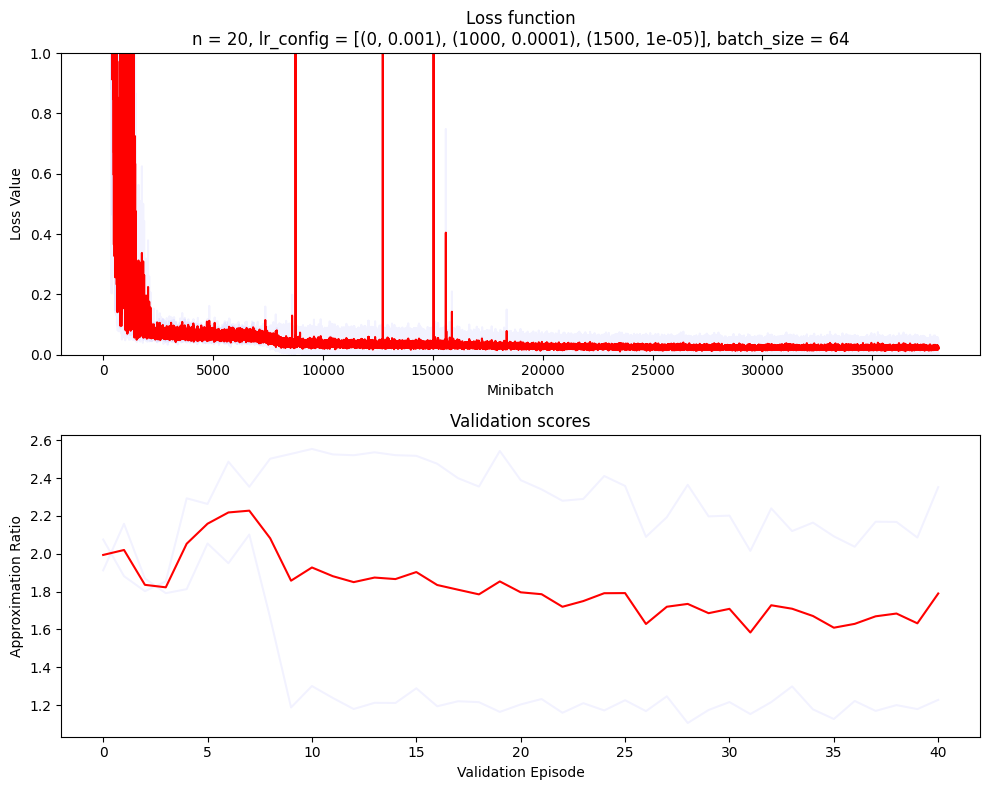

In [118]:
%%time
params = {
    'n': 20,
    'pos_lim': 1e6,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.005,
    'eps_end_at_episode': 1.0,
    'validate_each': 50,
    'print_train_metrics_each': 10,
    'batch_size': 64
}
agents = run_train(7, 2, params)

In [ ]:
MCVE

In [77]:
agent = agents[0]
agent.qnetwork_local

MPNN(
  (batch_norm_layer): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embedding_layer): EmbeddingLayer(
    (theta1): Linear(in_features=4, out_features=64, bias=False)
    (theta2): Linear(in_features=64, out_features=64, bias=False)
    (theta3): Linear(in_features=64, out_features=64, bias=False)
    (theta4): Linear(in_features=1, out_features=64, bias=False)
  )
  (q_layer): QNetwork(
    (theta5): Linear(in_features=128, out_features=1, bias=False)
    (theta6): Linear(in_features=64, out_features=64, bias=False)
    (theta7): Linear(in_features=64, out_features=64, bias=False)
  )
)

In [41]:
agents

[<agent.Agent at 0x176b5cd60>, <agent.Agent at 0x16a99bd00>]

In [42]:
env = TSPEnv(n_min=8, n_max=8, pos_lim=1e0)
agent = agents[0]

In [45]:
env.reset()
run_episode(agent, env, train_mode=False, print_actions=True)

1
7
2
5
3
4
6


(-0.40078667790410605, 0)

In [46]:
get_solution(env)

2.533137898535876

In [ ]:
agents

In [76]:
params = {
    'n': 8,
    'pos_lim': 1e0,
    'lr_config': [[0, 1e-3], [0.25, 1e-4], [0.75, 1e-5]],
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.01,
    'eps_end_at_episode': 0.6,
    'validate_each': 50,
    'print_train_metrics_each': 10,
    'batch_size': 64
}
run_train(0, 2, params)

{'n': 8, 'pos_lim': 1.0, 'lr_config': [[0, 0.001], [0.25, 0.0001], [0.75, 1e-05]], 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.01, 'eps_end_at_episode': 0.6, 'validate_each': 50, 'print_train_metrics_each': 10, 'batch_size': 64}
Starting run #1/2...
> /Users/tiagomontalvao/dev/ufrj/msc/tese/tsp-rl/agent.py(218)learn()
    216         pdb.set_trace()
    217         # Run optimizer step
--> 218         self.optimizer.zero_grad()
    219         self.losses.append(loss.item())
    220         loss.backward()



ipdb>  loss


tensor(1.6947, grad_fn=<MseLossBackward0>)


ipdb>  loss.requires_grad


True


ipdb>  loss.item()


1.6947375535964966


ipdb>  loss.requires_grad


True


ipdb>  loss.detach().requires_grad


False


ipdb>  self.qnetwork_local.embedding_layer.theta1


Linear(in_features=4, out_features=64, bias=False)


ipdb>  self.qnetwork_local.embedding_layer.theta1.parameters()


<generator object Module.parameters at 0x2865cc270>
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
> /Users/tiagomontalvao/dev/ufrj/msc/tese/tsp-rl/agent.py(218)learn()
    216         pdb.set_trace()
    217         # Run optimizer step
--> 218         self.optimizer.zero_grad()
    219         self.losses.append(loss.item())
    220         loss.backward()

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
> /Users/tiagomontalvao/dev/ufrj/msc/tese/tsp-rl/agent.py(218)learn()
    216         pdb.set_trace()
    217         # Run optimizer step
--> 218         self.optimizer.zero_grad()
    219         self.losses.append(loss.item())
    220         loss.backward()

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
> /Users/tiagomontalvao/dev/ufrj/msc/tese/tsp-rl/agent.py(218)learn()
    216         pdb.set_trace()
    217         # Run optimizer step
--> 218         self.optimizer.zero_grad()
    219         self.losses.append(loss.item())
    22

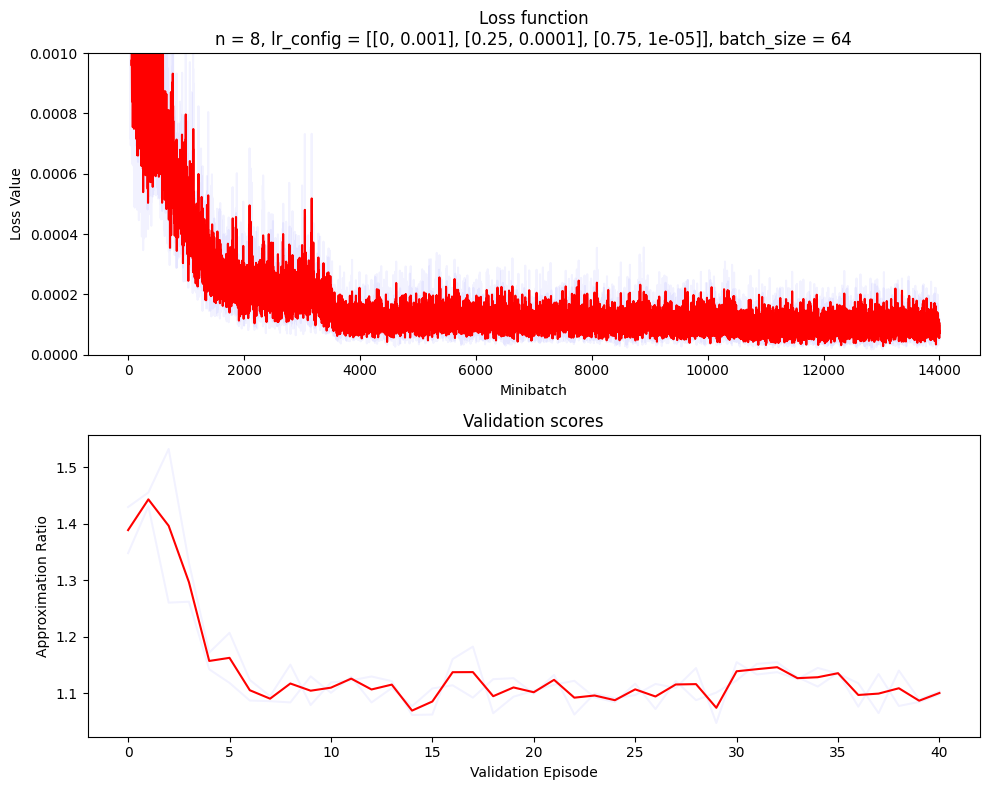

In [83]:
replay_graphs('outputs/run_0', max_loss=1e-3, filename=None)

{'n': 8, 'pos_lim': 1.0, 'lr_config': [[0, 0.001], [0.25, 0.0001], [0.75, 1e-05]], 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.01, 'eps_end_at_episode': 0.6, 'validate_each': 50, 'print_train_metrics_each': 10, 'batch_size': 64}
Starting run #1/2...
Starting run #2/2...


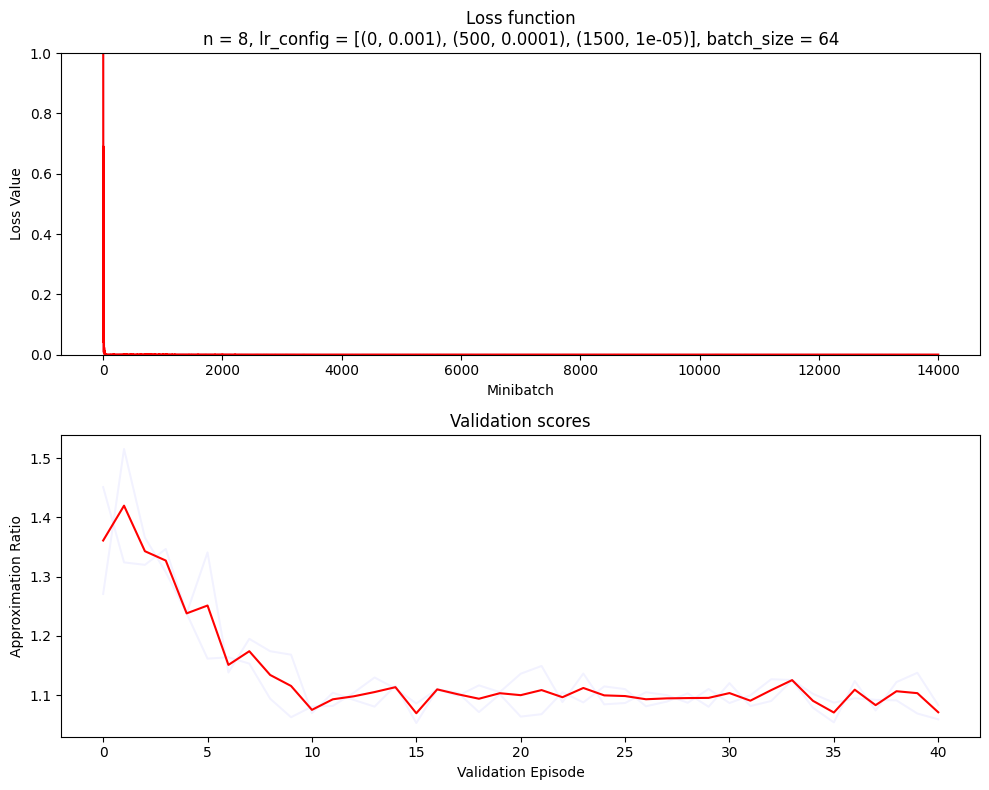

In [84]:
# normalizing rewards
params = {
    'n': 8,
    'pos_lim': 1e0,
    'lr_config': [[0, 1e-3], [0.25, 1e-4], [0.75, 1e-5]],
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.01,
    'eps_end_at_episode': 0.6,
    'validate_each': 50,
    'print_train_metrics_each': 10,
    'batch_size': 64
}
run_train(1, 2, params)

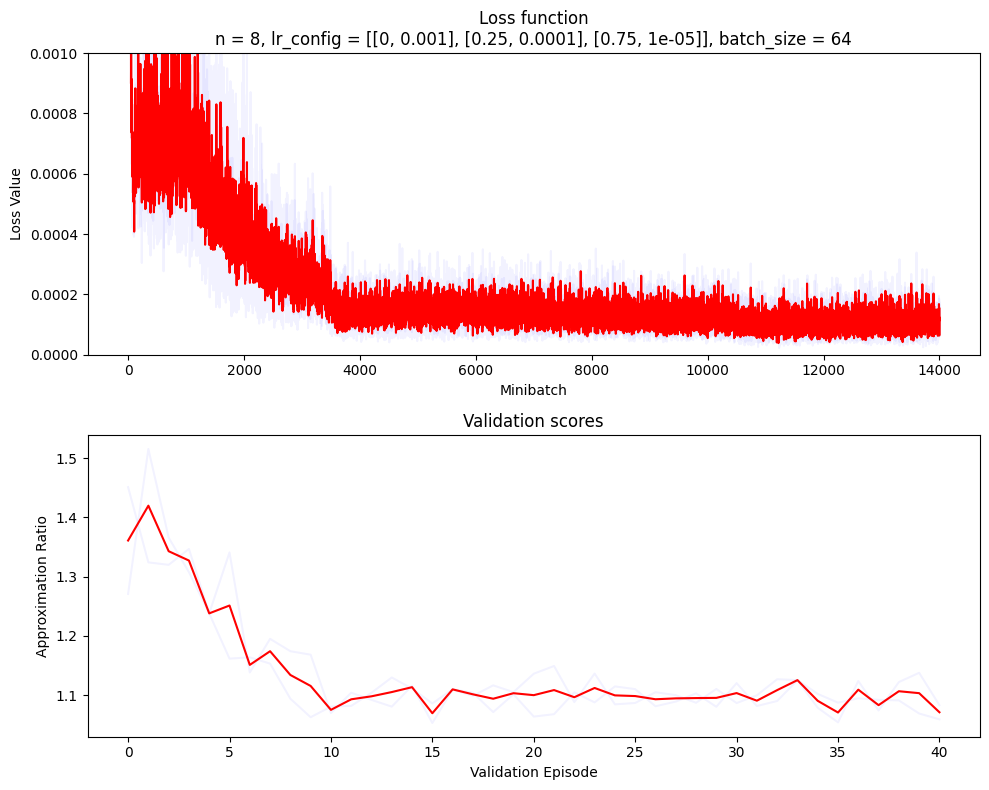

In [85]:
replay_graphs('outputs/run_1', max_loss=1e-3, filename=None)

{'n': 8, 'pos_lim': 1.0, 'lr_config': [[0, 0.001], [0.6, 0.0001], [0.9, 1e-05]], 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.01, 'eps_end_at_episode': 0.6, 'validate_each': 50, 'print_train_metrics_each': 10, 'batch_size': 64}
Starting run #1/2...
Starting run #2/2...


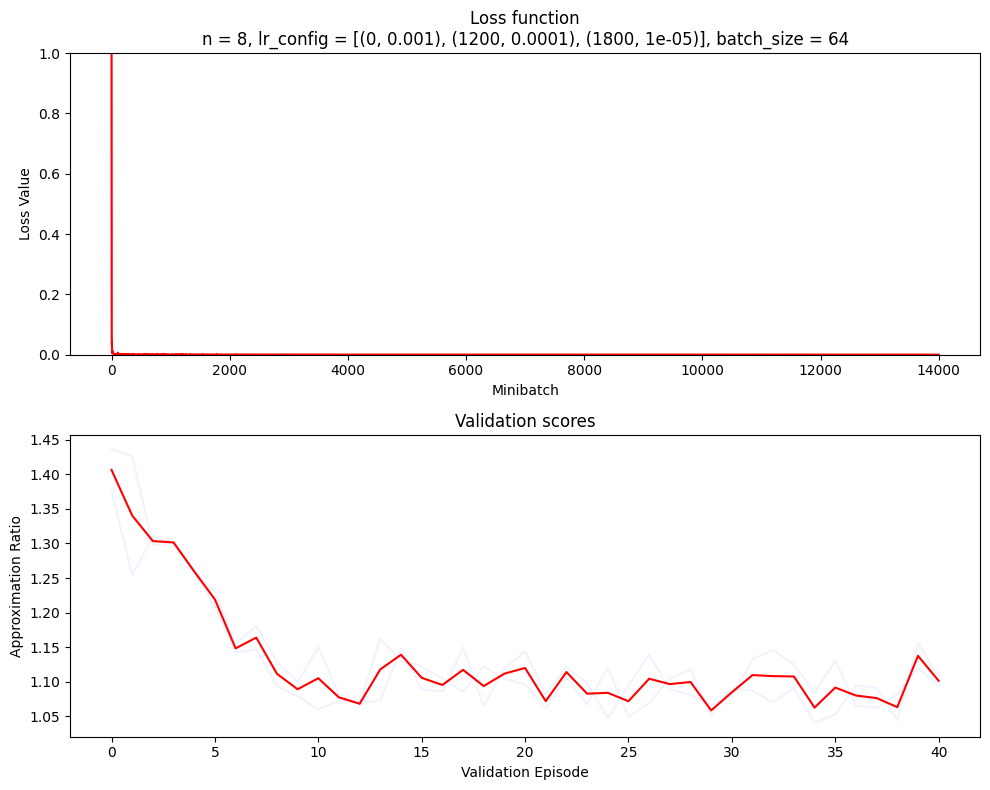

In [86]:
# normalizing rewards
params = {
    'n': 8,
    'pos_lim': 1e0,
    'lr_config': [[0, 1e-3], [0.6, 1e-4], [0.9, 1e-5]],
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.01,
    'eps_end_at_episode': 0.6,
    'validate_each': 50,
    'print_train_metrics_each': 10,
    'batch_size': 64
}
run_train(2, 2, params)

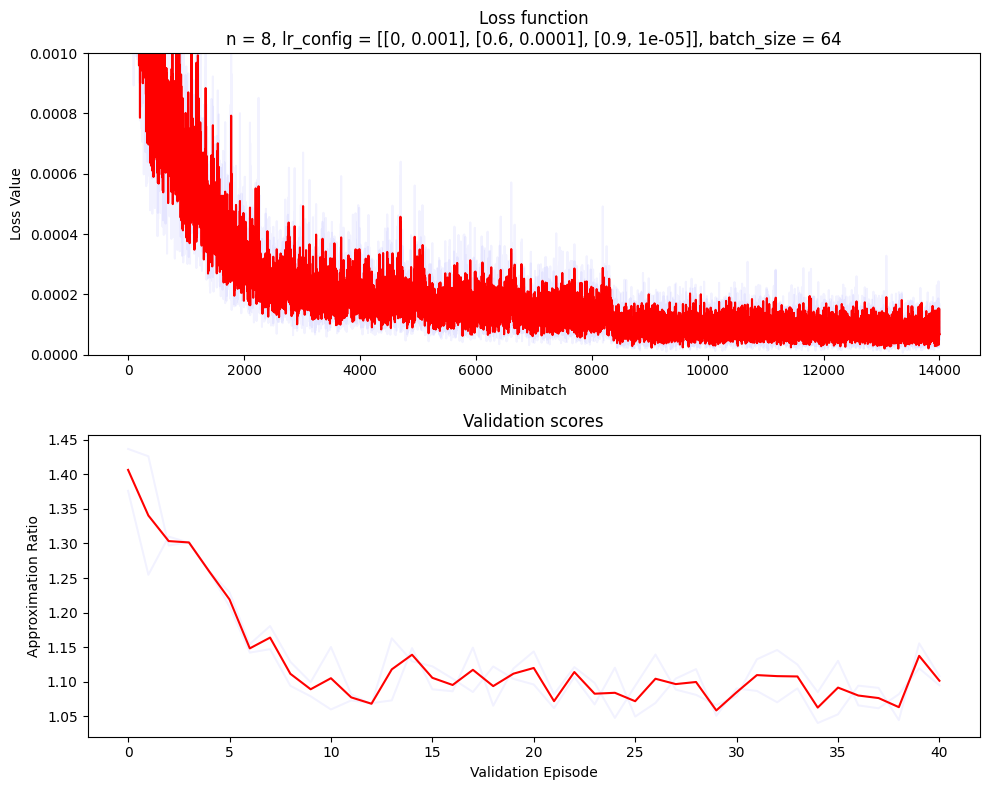

In [87]:
replay_graphs('outputs/run_2', max_loss=1e-3, filename=None)

1

{'batch_size': 64, 'eps_end': 0.01, 'eps_end_at_episode': 0.6, 'eps_start': 1.0, 'lr_config': [[0, 0.0005]], 'n': 8, 'n_episodes': 2000, 'print_train_metrics_each': 10, 'validate_each': 50}
Starting run #1/3...
Starting run #2/3...
Starting run #3/3...
{'batch_size': 64, 'eps_end': 0.01, 'eps_end_at_episode': 0.6, 'eps_start': 1.0, 'lr_config': [[0, 0.0005]], 'n': 12, 'n_episodes': 2000, 'print_train_metrics_each': 10, 'validate_each': 50}
Starting run #1/3...
Starting run #2/3...
Starting run #3/3...
{'batch_size': 64, 'eps_end': 0.01, 'eps_end_at_episode': 0.6, 'eps_start': 1.0, 'lr_config': [[0, 0.0005]], 'n': 15, 'n_episodes': 2000, 'print_train_metrics_each': 10, 'validate_each': 50}
Starting run #1/3...
Starting run #2/3...
Starting run #3/3...
{'batch_size': 64, 'eps_end': 0.01, 'eps_end_at_episode': 0.6, 'eps_start': 1.0, 'lr_config': [[0, 0.001], [0.3, 0.0001]], 'n': 8, 'n_episodes': 2000, 'print_train_metrics_each': 10, 'validate_each': 50}
Starting run #1/3...
Starting run #

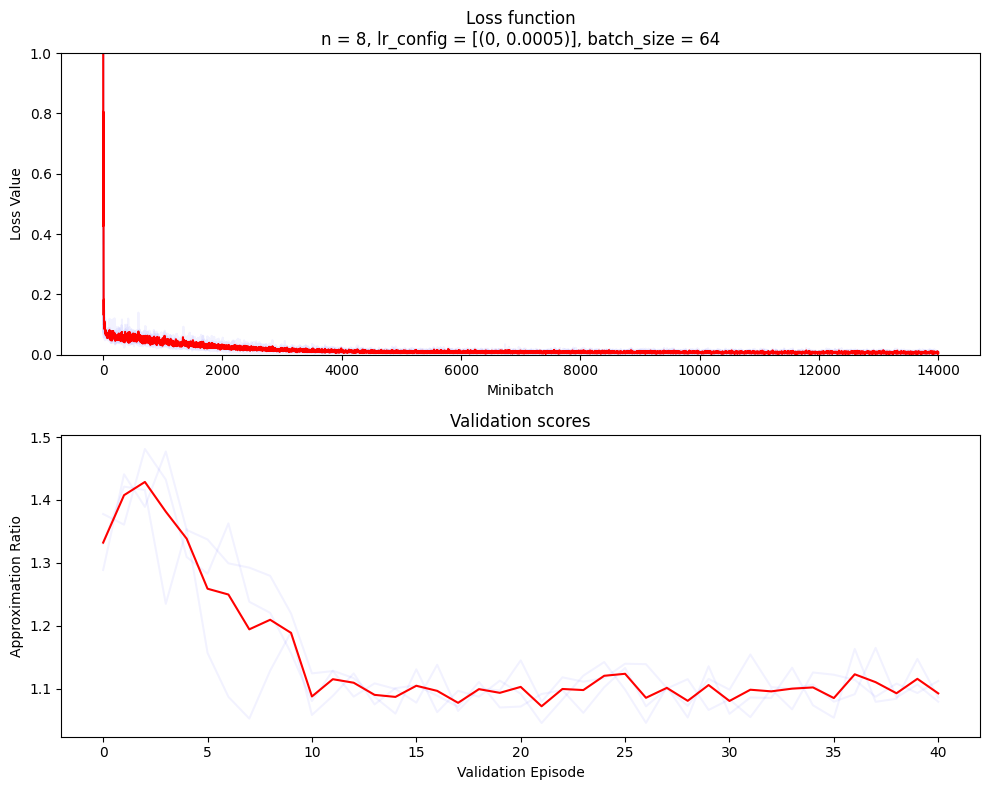

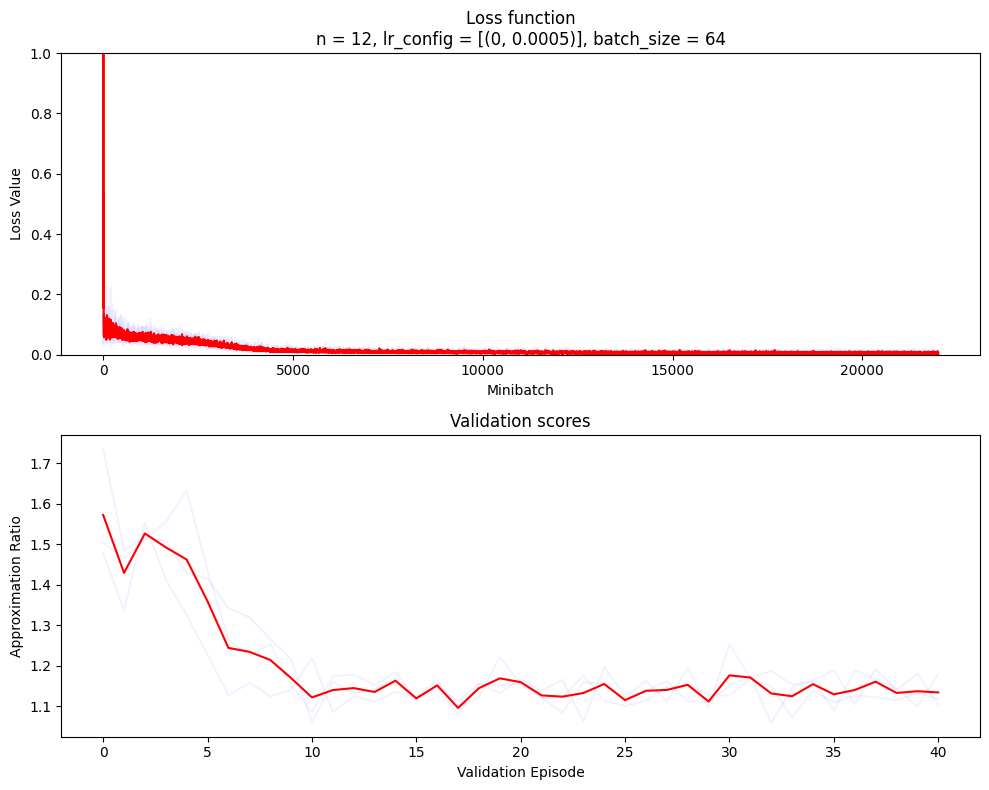

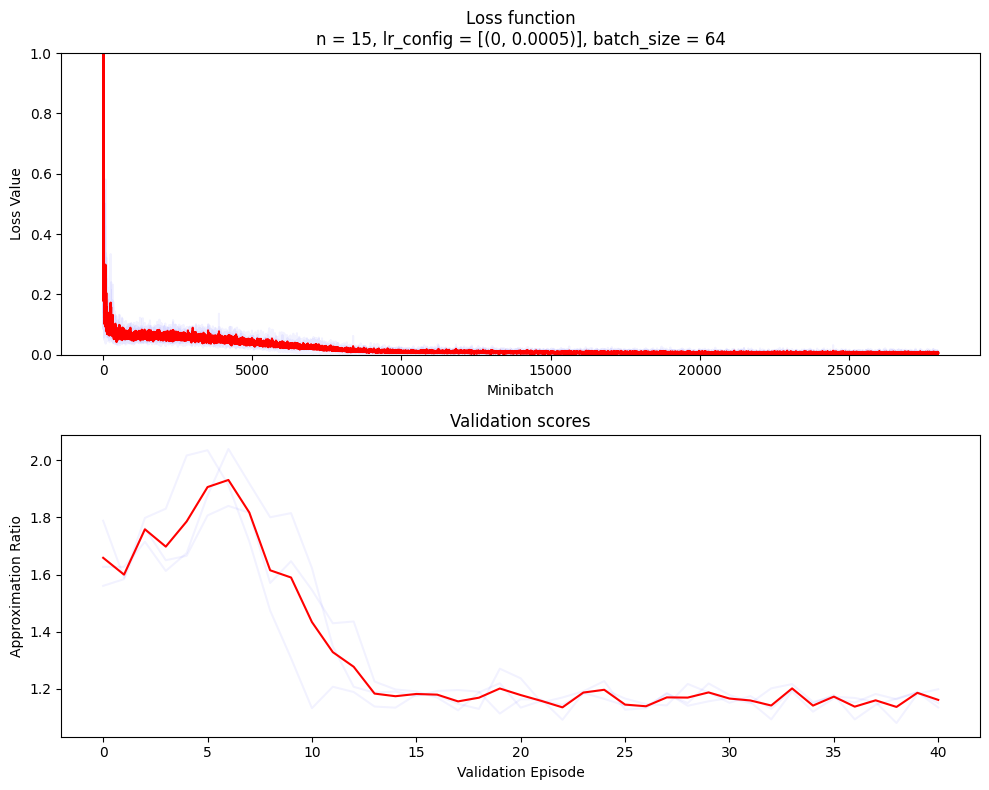

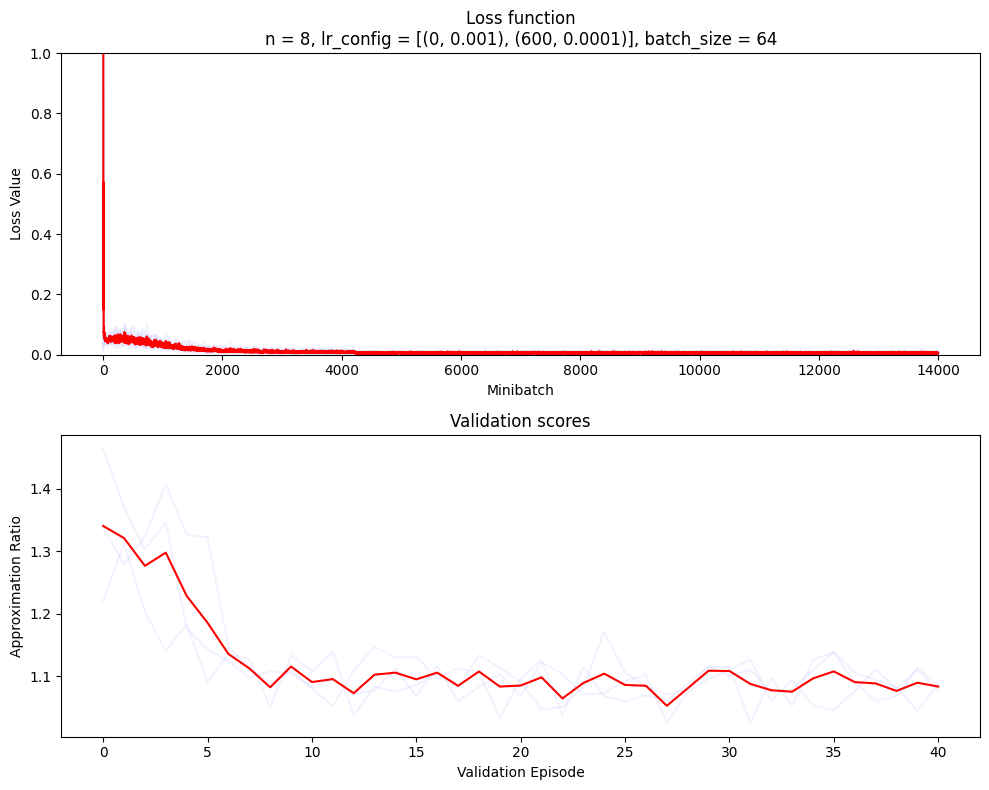

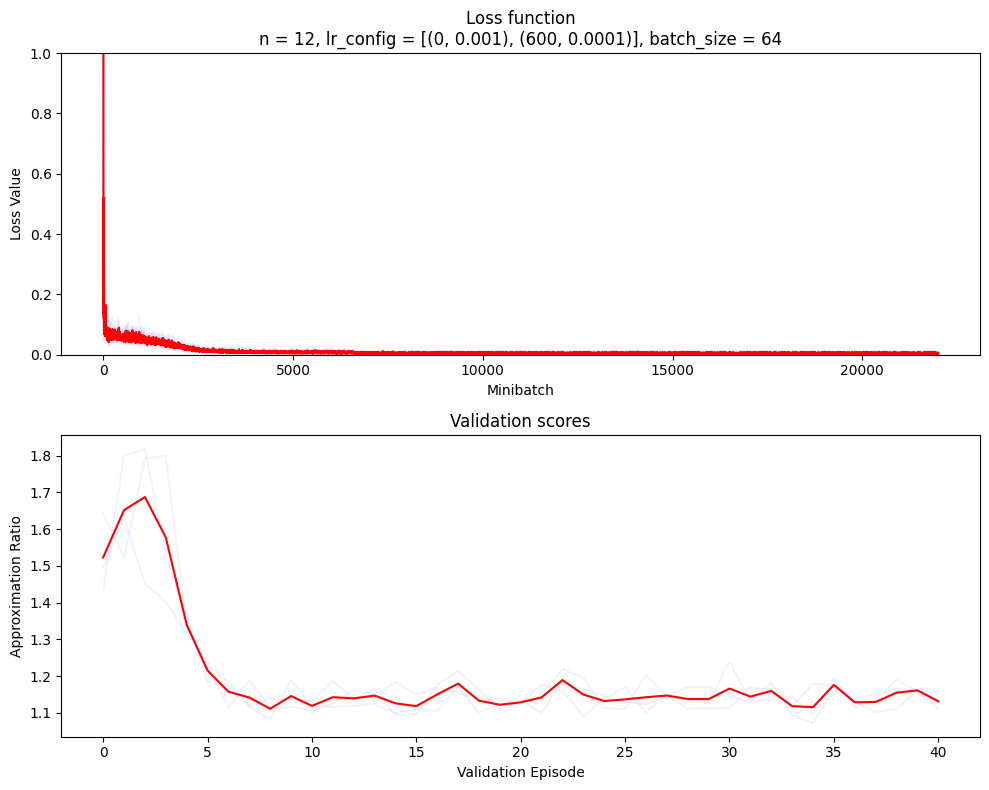

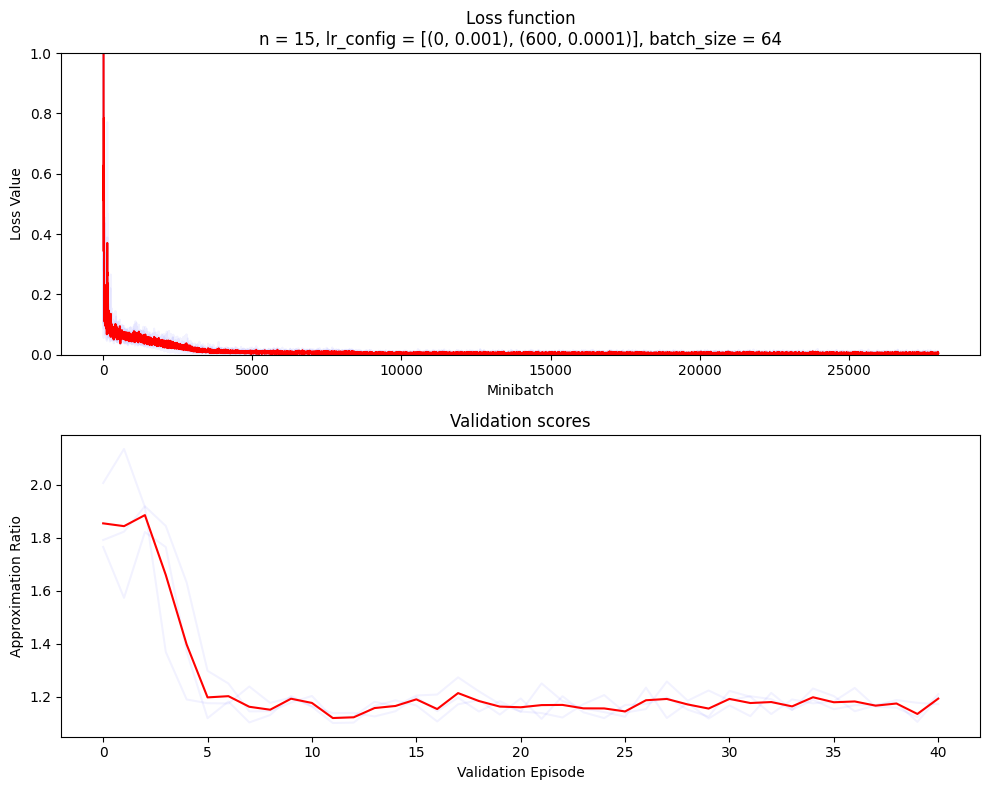

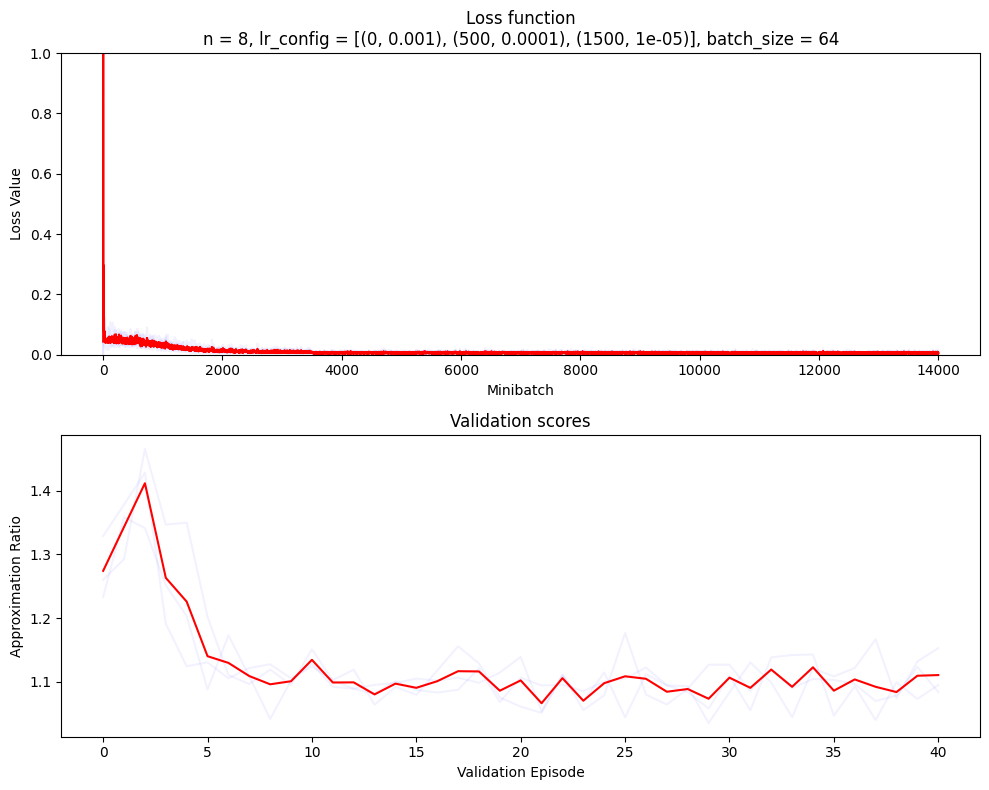

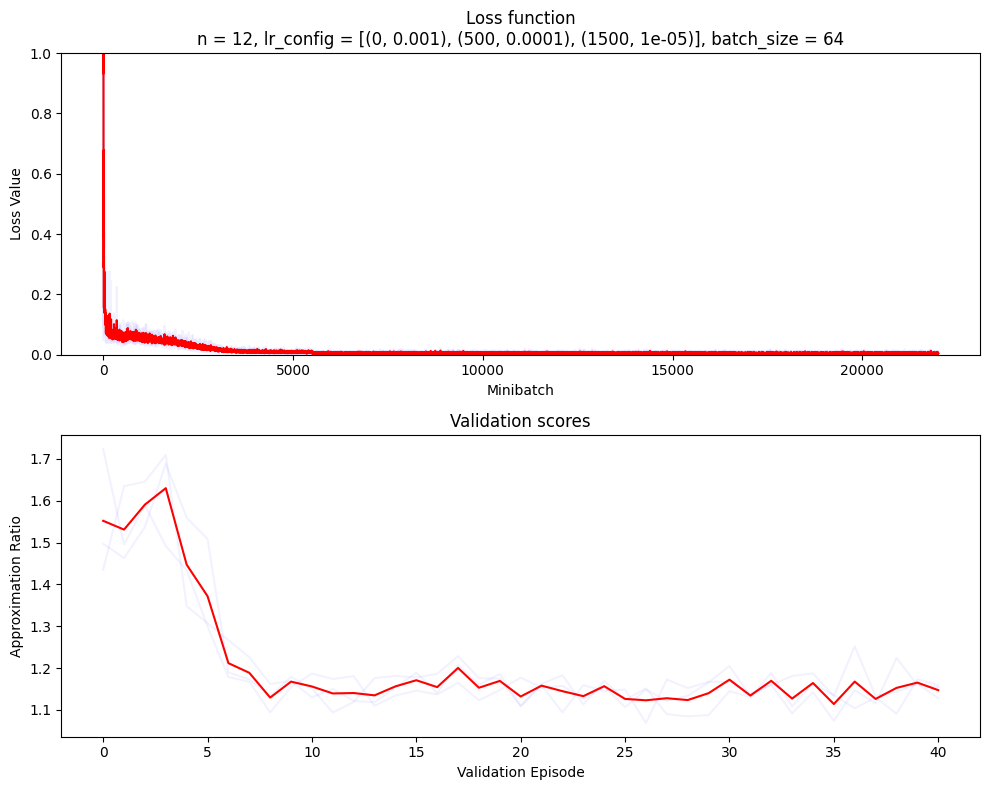

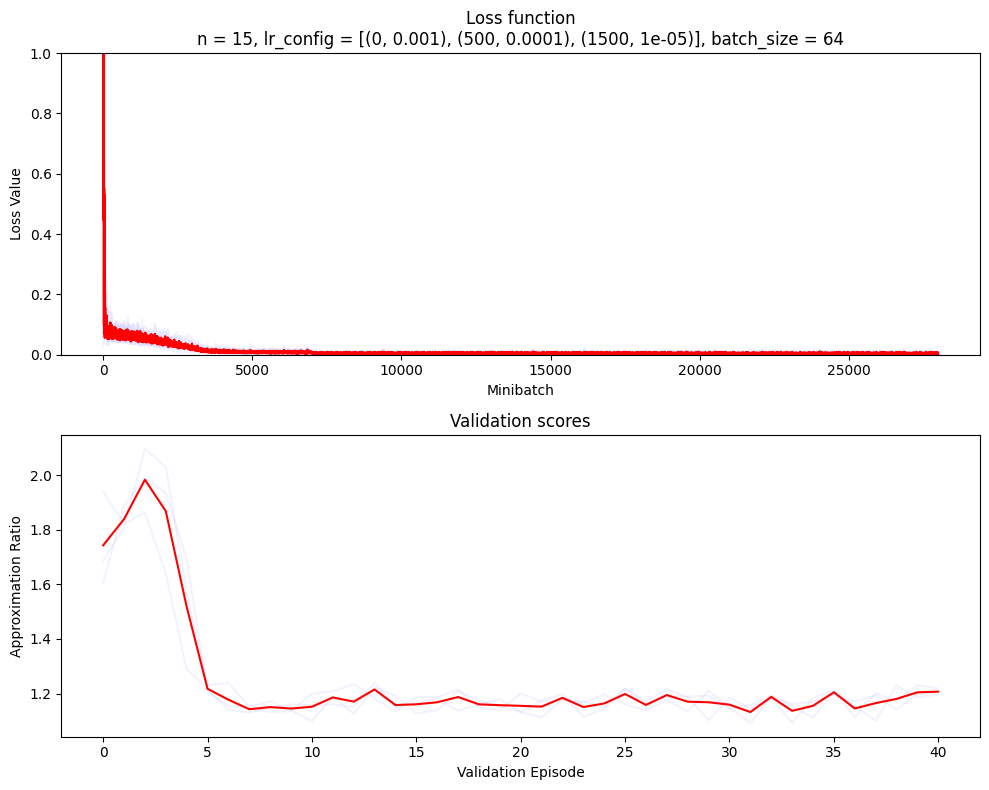

In [56]:
run_train_from_params(params, n_runs, parallel=0, start_idx=0)

In [67]:
exec(lines)

In [8]:
ast.literal_eval(lines)

[[0.17722700536251068,
  0.5140548944473267,
  0.3693510591983795,
  0.09318552166223526,
  0.15508045256137848,
  0.36859118938446045,
  0.2367052137851715,
  0.1434948742389679,
  0.1702072024345398,
  0.23614926636219025,
  0.2224905639886856,
  0.1543552428483963,
  0.11074090003967285,
  0.12452833354473114,
  0.11369676887989044,
  0.09856342524290085,
  0.09586073458194733,
  0.09860733896493912,
  0.10187072306871414,
  0.10348603874444962,
  0.09756558388471603,
  0.09652519226074219,
  0.0826682522892952,
  0.07926277816295624,
  0.07358863204717636,
  0.06849756091833115,
  0.0664854571223259,
  0.06776269525289536,
  0.07316254824399948,
  0.07068370282649994,
  0.06432967633008957,
  0.06940445303916931,
  0.07014140486717224,
  0.06934487819671631,
  0.07997564226388931,
  0.07641318440437317,
  0.07279185205698013,
  0.07154817134141922,
  0.06854140758514404,
  0.06644563376903534,
  0.06610167026519775,
  0.06429494172334671,
  0.06739068776369095,
  0.0678725987672805

In [7]:
with open('outputs/run_0_loss.log') as f:
    lines = f.read()

In [81]:
losses = eval(lines)
losses

[[0.00016121030785143375,
  0.9173876643180847,
  0.4200781285762787,
  0.16899579763412476,
  0.22922496497631073,
  0.10289895534515381,
  0.21099485456943512,
  0.19400861859321594,
  0.11744639277458191,
  0.06397674977779388,
  0.09404552727937698,
  0.08934885263442993,
  0.05744210258126259,
  0.060535185039043427,
  0.07302572578191757,
  0.060610223561525345,
  0.051848772913217545,
  0.06349854171276093,
  0.052422475069761276,
  0.040117546916007996,
  0.1273403912782669,
  0.06492599099874496,
  0.1243266686797142,
  0.12981726229190826,
  0.1073923259973526,
  0.036960408091545105,
  0.03558356687426567,
  0.05119963362812996,
  0.10145746916532516,
  0.10329771041870117,
  0.08356240391731262,
  0.10046561062335968,
  0.07341746985912323,
  0.09213042259216309,
  0.18561813235282898,
  0.10664581507444382,
  0.06712082028388977,
  0.1437549740076065,
  0.1716732382774353,
  0.10944312810897827,
  0.08634033054113388,
  0.08237214386463165,
  0.04223481938242912,
  0.12981

In [ ]:
plot_graphs(all_agent_losses, [], 8, lr_config, max_loss=1, filename=filename_plot)

## Ad hoc

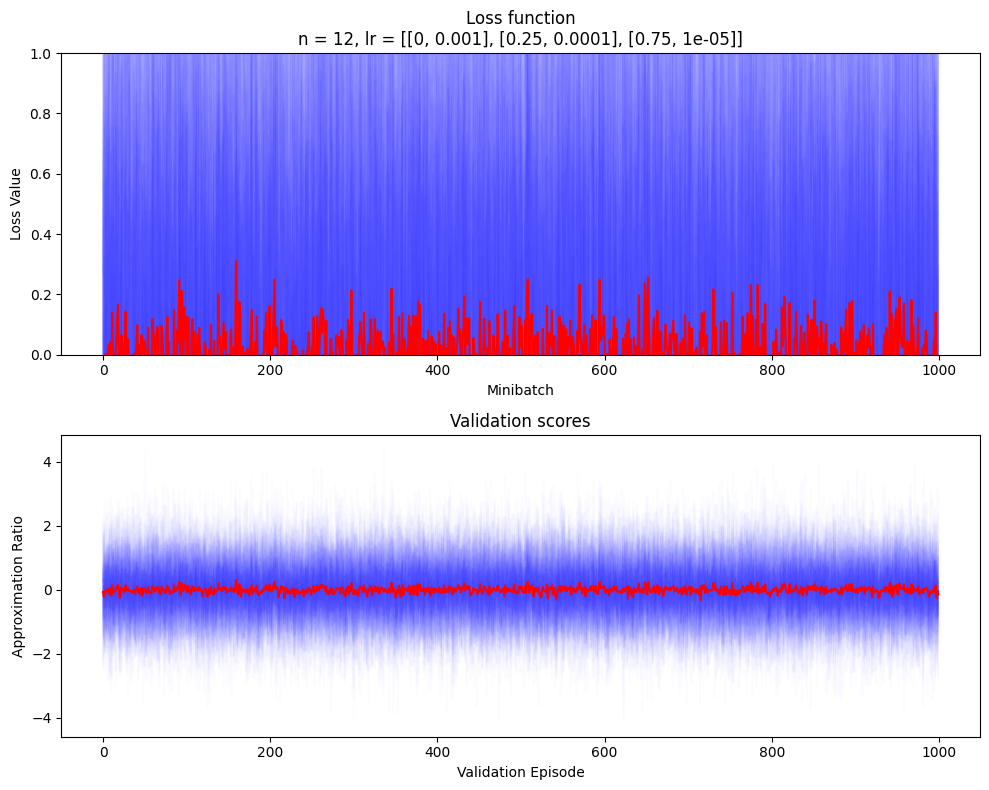

In [90]:
plot_graphs(val_scores, val_scores, 12, [[0, 1e-3], [0.25, 1e-4], [0.75, 1e-5]])

In [66]:
val_scores

array([[7.12105270e-01, 1.21824541e+00, 1.41877654e+00, ...,
        5.04552391e+02, 5.05287404e+02, 5.05894467e+02],
       [3.68693388e-01, 1.29393087e+00, 2.03704893e+00, ...,
        4.92329405e+02, 4.93101621e+02, 4.93549286e+02],
       [3.59529783e-01, 9.74650535e-01, 1.51889727e+00, ...,
        4.98274203e+02, 4.99033398e+02, 4.99296405e+02],
       ...,
       [6.78932081e-01, 1.19289108e+00, 1.34299626e+00, ...,
        4.96337584e+02, 4.96814465e+02, 4.97309958e+02],
       [1.59687469e-01, 5.73360104e-01, 9.91728014e-01, ...,
        5.01480114e+02, 5.01765746e+02, 5.02751517e+02],
       [1.86262553e-01, 7.19272093e-01, 7.68727325e-01, ...,
        4.88681500e+02, 4.88900478e+02, 4.89320184e+02]])

In [71]:
val_scores = np.random.randn(100, 1000)
val_scores

array([[-2.42386186,  0.74976138, -1.76439347, ...,  2.08580175,
        -0.28106727,  0.98491216],
       [-0.91003602,  0.55229264,  0.61816895, ...,  0.38922188,
         0.65689806,  0.73197172],
       [-1.16195723, -1.24923684,  0.96445519, ...,  0.2588779 ,
        -1.03373772, -0.39126439],
       ...,
       [ 0.28770022, -1.79838283, -0.46599777, ...,  0.04920869,
        -0.87257615,  0.09540195],
       [-0.02768871,  0.76783102,  0.69426978, ..., -0.98912241,
         2.27648186, -0.11971266],
       [ 1.97307178,  1.16808203,  0.1591288 , ...,  1.12297181,
         2.02148336,  0.43066722]])

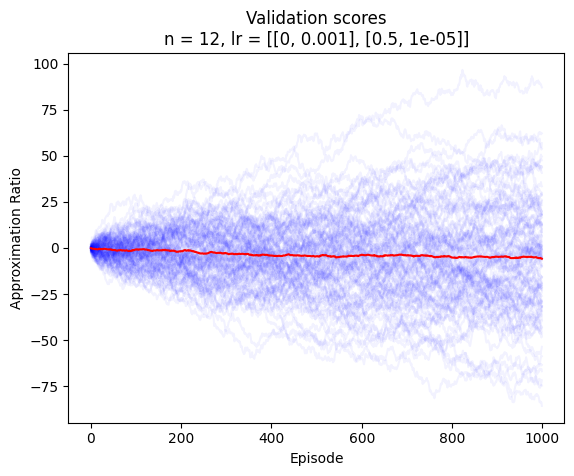

In [74]:
df = pd.DataFrame(np.cumsum(val_scores, axis=1)).T
df.plot(color='b', alpha=0.05, legend=False, xlabel='Episode', ylabel='Approximation Ratio');
df.mean(axis=1).plot(color='r', title=f'Validation scores\nn = {n}, lr = {lr}');

In [49]:
n = 12
lr = [[0, 1e-3], [0.5, 1e-5]]

In [52]:
', '.join([f'{p} = {v[0]}' for (p, v) in params.items()])

'n = 8, lr_config = [[0, 0.0005]], n_episodes = 100, eps_start = 1.0, eps_end = 0.01, eps_end_at_episode = 0.6, validate_each = 50, print_train_metrics_each = 10'

In [34]:
# Single step
env = TSPEnv(n_min=10, n_max=10)
agent = Agent(nstep=1)

In [3]:
state = env.reset()
agent.reset_episode(env.G)
score = 0
i = 0

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
state.shape

(10, 24)

In [6]:
state = env.reset()
agent.reset_episode(env.G)
print(env.start_vertex)
while True:
    action = agent.act(state, eps=0.1)
    print(action)
    next_state, reward, done = env.step(action)
    score += reward
    # print('reward', reward)
    agent.step(state, action, reward, next_state, done)
    i += 1
    state = next_state
    if done:
        break

0
8
2
9
4
7
3
6
1
5


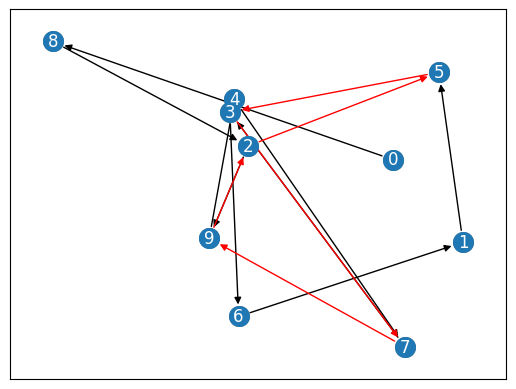

In [9]:
plot_network(env.G, env.tour, [2,5,3,7,9,2], draw_all_edges=False);

In [10]:
torch.__version__

'1.13.1'

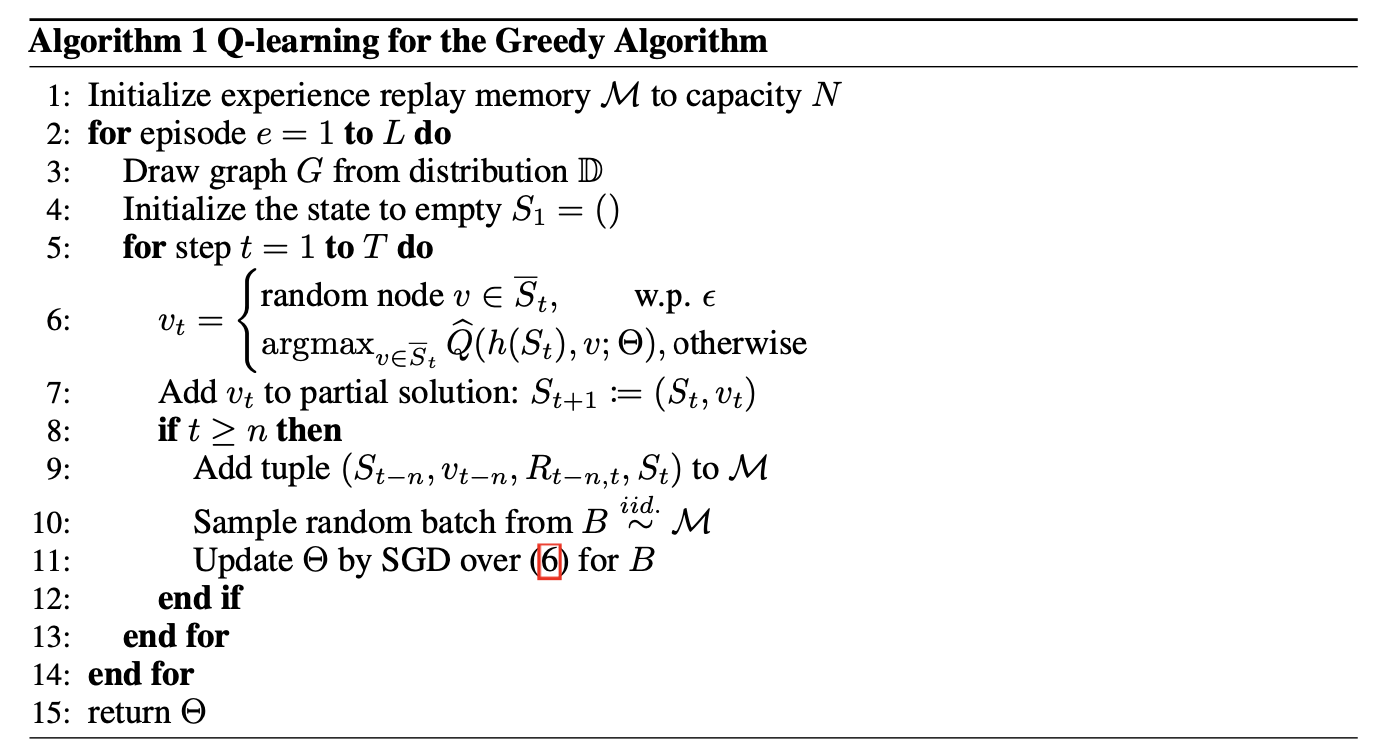

In [11]:
eps_start = 0.999
eps_decay = 0.99995 # 0.995
eps_end=0.01
n_batches = 200000

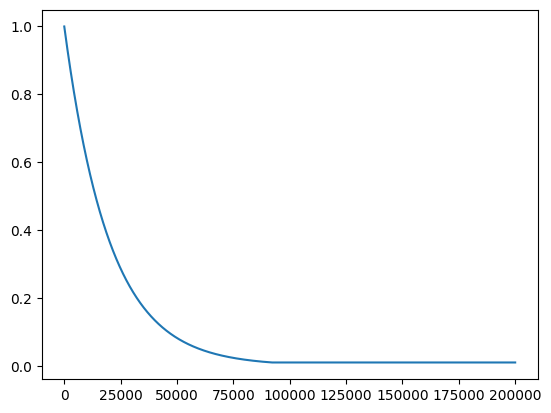

In [12]:
plt.plot([max(eps_start * eps_decay**i, eps_end) for i in range(n_batches)])

In [11]:
dist_matrix = np.array([[env.G[u].get(v, {}).get('weight', float('inf')) for v in range(env.n)] for u in range(env.n)])
solve_tsp_dynamic_programming(dist_matrix)

([0, 7, 6, 3, 2, 1, 4, 5, 8, 9], 2.2670917470301357)

In [18]:
eps_analysis(0.9999, 0.999985, 0.01, 15)

20467

In [19]:
max(0.01, 0.9999 * (0.999985 ** (15*10000)))

0.1053869062027777

In [22]:
nstep = 1
normalize=True
lr=1e-4
eps_start = 0.9999
eps_decay = 0.999985
eps_end=0.01

agent = Agent(nstep=nstep, normalize=normalize, lr=lr)
env = TSPEnv(n_min=12, n_max=12)
scheduler = None
scheduler = ReduceLROnPlateau(agent.optimizer, 'min', patience=4)

_ = train(agent, env, eps_start, eps_decay, eps_end, scheduler=scheduler,
          n_episodes=20000, validate_each=1000, print_train_metrics_each=50)

[Validation] Mean: 1.5337033183750683, Std dev: 0.11584419012804405, Optimal: 0.00%
[50/20000] loss: 7.366e-02, q_target: -1.434e+00, q_expected: -1.133e+00, eps: 0.9917, time: 4.29s
    θ1: -1.786e-01, θ2: -1.161e-01, θ3: -1.571e-02, θ4: -1.680e-02, θ5: 5.459e-02, θ6: -6.162e-02, θ7: -4.747e-02
[100/20000] loss: 6.342e-02, q_target: -1.314e+00, q_expected: -1.027e+00, eps: 0.9835, time: 7.94s
    θ1: -1.842e-01, θ2: -1.157e-01, θ3: -1.389e-02, θ4: -1.722e-02, θ5: 5.379e-02, θ6: -6.143e-02, θ7: -4.779e-02
[150/20000] loss: 4.922e-02, q_target: -1.105e+00, q_expected: -9.302e-01, eps: 0.9755, time: 11.58s
    θ1: -1.865e-01, θ2: -1.141e-01, θ3: -1.233e-02, θ4: -1.745e-02, θ5: 5.292e-02, θ6: -6.121e-02, θ7: -4.835e-02
[200/20000] loss: 9.865e-02, q_target: -1.315e+00, q_expected: -8.359e-01, eps: 0.9674, time: 15.05s
    θ1: -1.886e-01, θ2: -1.144e-01, θ3: -1.314e-02, θ4: -1.770e-02, θ5: 5.212e-02, θ6: -6.110e-02, θ7: -4.872e-02
[250/20000] loss: 4.572e-02, q_target: -1.080e+00, q_expect

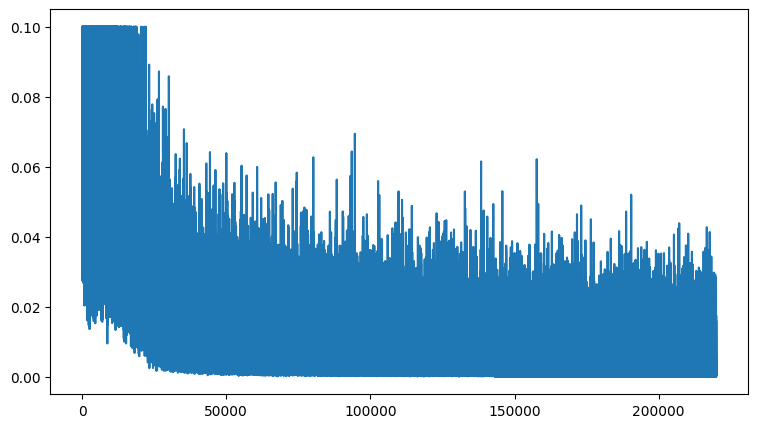

In [24]:
agent_losses = agent.losses
fig, ax = plt.subplots(figsize=(9,5))
ax.plot([min(loss, 1e-1) for loss in agent_losses]);

<AxesSubplot: >

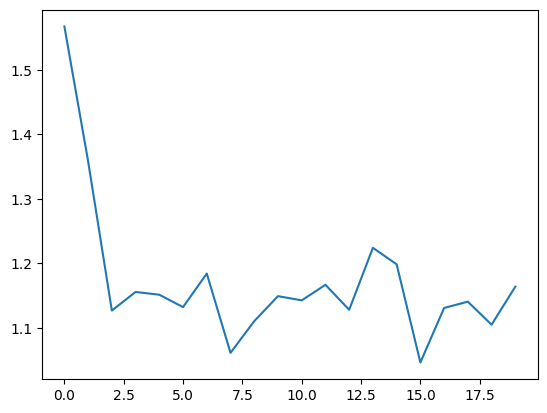

In [25]:
pd.Series(np.array(_[1])).plot()

In [72]:
nstep = 1
normalize=True
lr=1
eps_start = 0.9999
eps_decay = 0.99925
eps_end=0.01

agent = Agent(nstep=nstep, normalize=normalize, lr=lr)
env = TSPEnv(n_min=15, n_max=15)
# scheduler = None
# scheduler = ReduceLROnPlateau(agent.optimizer, 'min', patience=10, factor=0.1)
scheduler = LambdaLR(agent.optimizer, lr_lambda=lr_lambda([[0, 1e-2]]), verbose=False)

scores, val_scores = train(
    agent, env, eps_start, eps_decay, eps_end, scheduler=scheduler,
    n_episodes=1000, validate_each=100, print_train_metrics_each=10,
    print_thetas=False, validate_at_start=False
)

[10/1000] loss: 1.076e-01, q_target: -7.364e-01, q_expected: -2.256e-01, eps: 0.9002, time: 1.37s
[20/1000] loss: 9.515e-02, q_target: -9.260e-01, q_expected: -3.072e-01, eps: 0.8104, time: 2.50s
[30/1000] loss: 8.195e-02, q_target: -9.730e-01, q_expected: -9.475e-01, eps: 0.7296, time: 3.72s
[40/1000] loss: 1.546e-01, q_target: -1.460e+00, q_expected: -6.089e-01, eps: 0.6569, time: 4.86s
[50/1000] loss: 6.232e-02, q_target: -8.894e-01, q_expected: -6.984e-01, eps: 0.5914, time: 5.97s
[60/1000] loss: 5.957e-02, q_target: -9.420e-01, q_expected: -6.423e-01, eps: 0.5324, time: 7.10s
[70/1000] loss: 4.055e-02, q_target: -1.058e+00, q_expected: -1.003e+00, eps: 0.4793, time: 8.26s
[80/1000] loss: 1.208e-01, q_target: -1.372e+00, q_expected: -7.188e-01, eps: 0.4315, time: 9.38s
[90/1000] loss: 3.022e-02, q_target: -1.299e+00, q_expected: -1.078e+00, eps: 0.3885, time: 10.54s
[100/1000] loss: 7.059e-02, q_target: -1.941e+00, q_expected: -1.359e+00, eps: 0.3498, time: 11.91s
[Validation] Mean

SystemExit: 0

/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3450: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [73]:
nstep = 1
normalize=True
lr=1
eps_start = 0.9999
eps_decay = 0.99925
eps_end=0.01

agent = Agent(nstep=nstep, normalize=normalize, lr=lr)
env = TSPEnv(n_min=15, n_max=15)
# scheduler = None
# scheduler = ReduceLROnPlateau(agent.optimizer, 'min', patience=10, factor=0.1)
scheduler = LambdaLR(agent.optimizer, lr_lambda=lr_lambda([[0, 1e-2]]), verbose=False)

scores, val_scores = train(
    agent, env, eps_start, eps_decay, eps_end, scheduler=scheduler,
    n_episodes=1000, validate_each=100, print_train_metrics_each=10,
    print_thetas=False, validate_at_start=False
)

[10/1000] loss: 1.039e-01, q_target: -1.838e+00, q_expected: -9.402e-01, eps: 0.9002, time: 3.58s
[20/1000] loss: 8.936e-02, q_target: -2.127e+00, q_expected: -8.079e-01, eps: 0.8104, time: 8.44s
[30/1000] loss: 4.287e-02, q_target: -1.120e+00, q_expected: -6.747e-01, eps: 0.7296, time: 12.96s
[40/1000] loss: 7.523e-02, q_target: -1.546e+00, q_expected: -1.084e+00, eps: 0.6569, time: 17.64s
[50/1000] loss: 7.629e-02, q_target: -1.553e+00, q_expected: -8.634e-01, eps: 0.5914, time: 22.38s
[60/1000] loss: 8.527e-02, q_target: -1.910e+00, q_expected: -9.483e-01, eps: 0.5324, time: 27.06s
[70/1000] loss: 8.187e-02, q_target: -2.078e+00, q_expected: -1.013e+00, eps: 0.4793, time: 32.15s
[80/1000] loss: 5.517e-02, q_target: -1.553e+00, q_expected: -1.428e+00, eps: 0.4315, time: 37.17s
[90/1000] loss: 3.348e-02, q_target: -1.565e+00, q_expected: -1.223e+00, eps: 0.3885, time: 41.92s
[100/1000] loss: 8.323e-02, q_target: -1.837e+00, q_expected: -1.430e+00, eps: 0.3498, time: 46.42s
[Validation

In [77]:
nstep = 1
normalize=True
lr=1
eps_start = 0.9999
eps_decay = 0.99925
eps_end=0.01

agent = Agent(nstep=nstep, normalize=normalize, lr=lr)
env = TSPEnv(n_min=15, n_max=15)
# scheduler = None
# scheduler = ReduceLROnPlateau(agent.optimizer, 'min', patience=10, factor=0.1)
scheduler = LambdaLR(agent.optimizer, lr_lambda=lr_lambda([[0, 1e-4]]), verbose=False)

scores, val_scores = train(
    agent, env, eps_start, eps_decay, eps_end, scheduler=scheduler,
    n_episodes=1000, validate_each=100, print_train_metrics_each=10,
    print_thetas=False, validate_at_start=False
)

[10/1000] loss: 9.186e-02, q_target: -2.202e+00, q_expected: -1.789e+00, eps: 0.9002, time: 3.88s
[20/1000] loss: 1.625e-01, q_target: -1.787e+00, q_expected: -1.267e+00, eps: 0.8104, time: 8.76s
[30/1000] loss: 5.945e-02, q_target: -1.676e+00, q_expected: -1.319e+00, eps: 0.7296, time: 13.38s
[40/1000] loss: 8.281e-02, q_target: -1.570e+00, q_expected: -1.242e+00, eps: 0.6569, time: 17.98s
[50/1000] loss: 7.141e-02, q_target: -1.803e+00, q_expected: -1.414e+00, eps: 0.5914, time: 22.96s
[60/1000] loss: 1.115e-01, q_target: -2.202e+00, q_expected: -1.006e+00, eps: 0.5324, time: 27.90s
[70/1000] loss: 6.935e-02, q_target: -1.686e+00, q_expected: -1.021e+00, eps: 0.4793, time: 32.88s
[80/1000] loss: 5.604e-02, q_target: -1.328e+00, q_expected: -1.033e+00, eps: 0.4315, time: 37.47s
[90/1000] loss: 7.249e-02, q_target: -1.579e+00, q_expected: -1.271e+00, eps: 0.3885, time: 42.23s
[100/1000] loss: 4.215e-02, q_target: -1.209e+00, q_expected: -9.687e-01, eps: 0.3498, time: 47.10s
[Validation

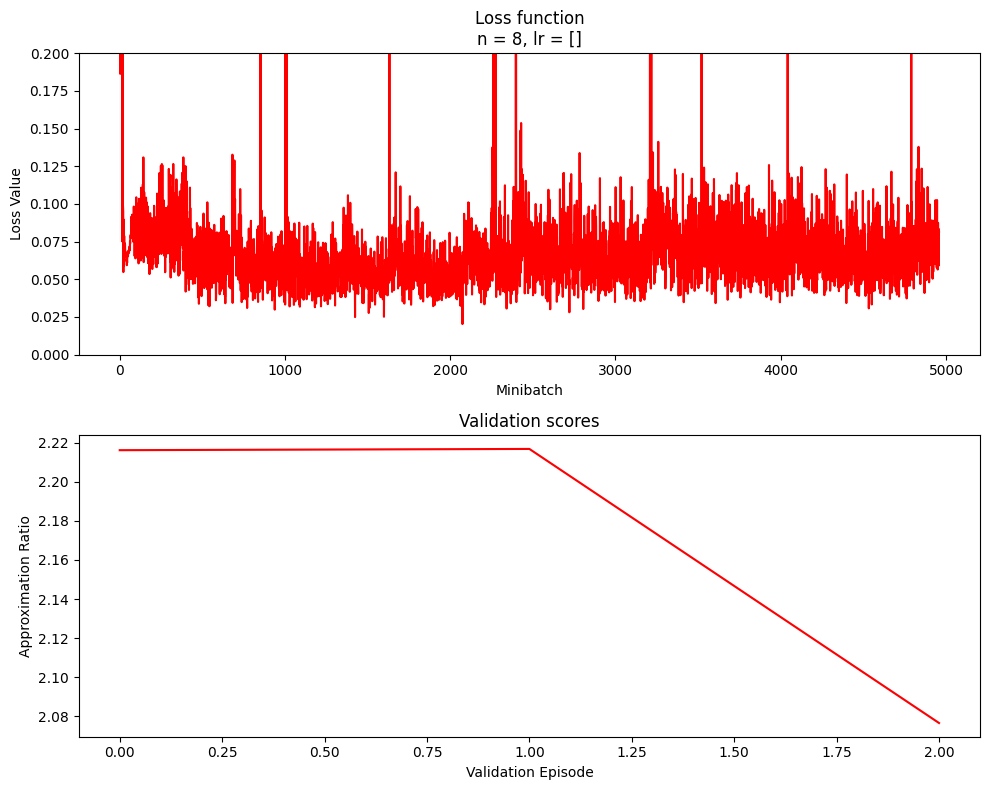

In [76]:
plot_graphs(agent.losses, val_scores, 8, [], max_loss=0.2, filename=None)

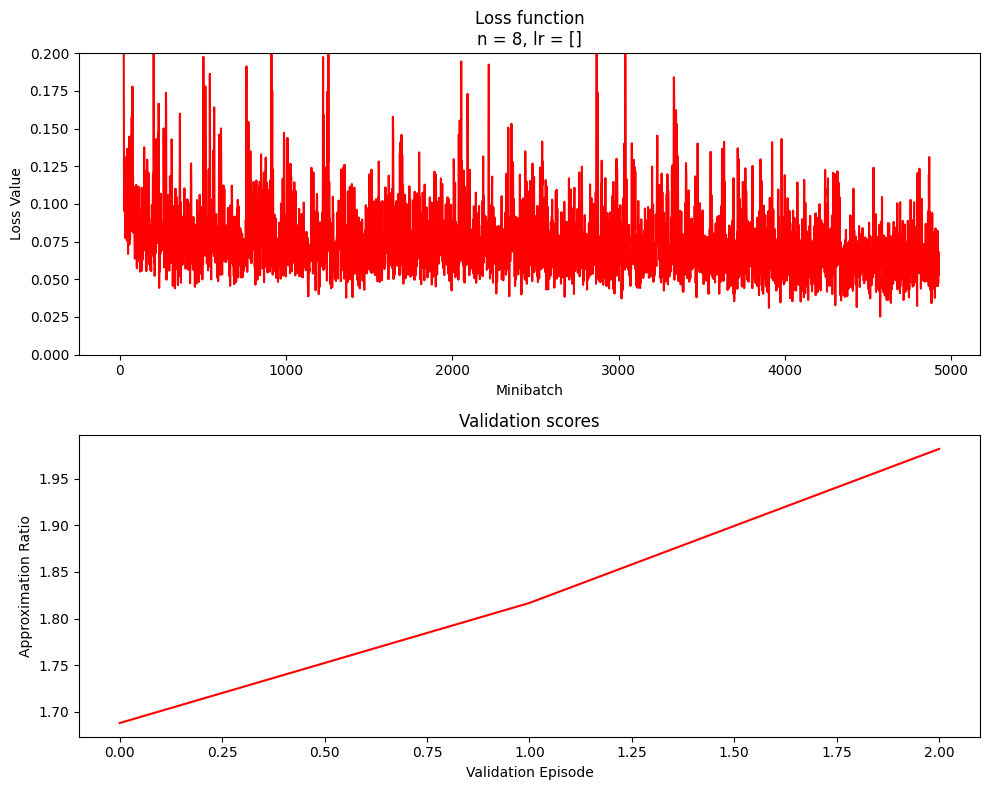

In [80]:
plot_graphs(agent.losses, val_scores, 8, [], max_loss=0.2, filename=None)

- Picos na loss function com LR = $10^{-2}$
- {8,12} vértices
- 20000 episódios
- $\{10^{-3}, 10^{-4}, 10^{-5}\}$ / {fixo, variando} LR
- múltiplas (2-3) instâncias para cada configuração

In [13]:
def eps_analysis(eps_start, eps_decay, eps_end, n, check_episodes=35000):
    return np.argmin([eps_start * (eps_decay ** (n*i)) > eps_end for i in range(check_episodes)])

In [14]:
eps_analysis(0.9999, 0.999985000128196, 0.01, 15)

20467

In [15]:
es, ed, ee, n = 0.9999, 0.999985, 0.01, 15
epi = 20467

In [16]:
np.log(0.01/0.9999)/np.log(0.999985)/15

20466.82507946209

In [17]:
ed = (ee/es)**(1/(n*epi))
ed

0.999985000128196

In [ ]:
nstep = 1
normalize=True
lr=1
eps_start = 0.9999
eps_decay = 0.99925
eps_end=0.01

agent = Agent(nstep=nstep, normalize=normalize, lr=lr, target_update="hard")
env = TSPEnv(n_min=10, n_max=10)
# scheduler = None
# scheduler = ReduceLROnPlateau(agent.optimizer, 'min', patience=10, factor=0.1)
scheduler = LambdaLR(agent.optimizer, lr_lambda=lr_lambda(0, 1e-4, 1e-4), verbose=False)

_ = train(agent, env, eps_start, eps_decay, eps_end, scheduler=scheduler,
          n_episodes=10000, validate_each=50, print_train_metrics_each=10, print_thetas=False)

Exception in thread IPythonHistorySavingThread:
Traceback (most recent call last):
  File "/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/IPython/core/history.py", line 831, in writeout_cache
    self._writeout_input_cache(conn)
  File "/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/IPython/core/history.py", line 814, in _writeout_input_cache
    conn.execute("INSERT INTO history VALUES (?, ?, ?, ?)",
sqlite3.IntegrityError: UNIQUE constraint failed: history.session, history.line

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/IPython/core/history.py", line 886, in run
    self.history_manager.writeout_cache(self.db)
  File "/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/decorator.py", line 232, in fun
    return caller(func, *(extras + args), **kw)
  File "/Users/tiagomontalvao/.virtualenvs/msc/l

In [ ]:
def plot_graphs(agent, val_scores, max_loss=1e0, scores=None):
    agent_losses = agent.losses
    fig, ax = plt.subplots(2, 1, figsize=(10,8))
    ax[0].plot([min(loss, max_loss) for loss in agent_losses])
    plt.title('Loss function')
    pd.Series(np.array(_[1])).plot(ax=ax[1])
    plt.title('Validation scores')
    plt.show()

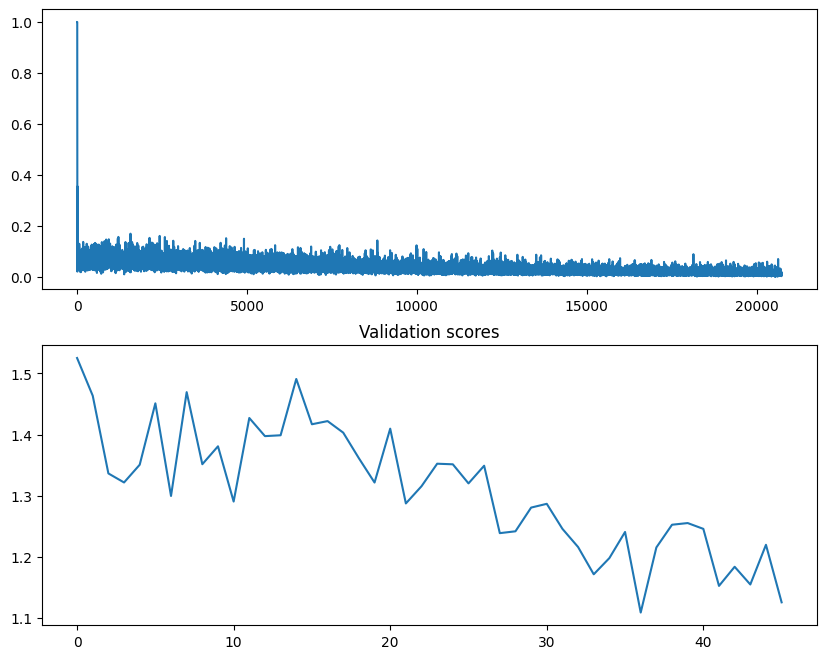

In [122]:
plot_graphs(agent, _[1], max_loss=1)

In [47]:
nstep = 1
normalize=True
lr=1e-2
eps_start = 0.9999
eps_decay = 0.999985
eps_end=0.01

agent = Agent(nstep=nstep, normalize=normalize, lr=lr, gamma=0.1)
env = TSPEnv(n_min=12, n_max=12, negate_reward=False)
scheduler = None
# scheduler = ReduceLROnPlateau(agent.optimizer, 'min', patience=5, factor=0.1, verbose=True)

_ = train(agent, env, eps_start, eps_decay, eps_end, scheduler=scheduler,
          n_episodes=40000, validate_each=50, print_train_metrics_each=50)

[Validation] Mean: 1.5256264679303075, Std dev: 0.23976849220655297, Optimal: 0.00%
loss=tensor(2.0495e+16, grad_fn=<MseLossBackward0>)
target_preds=tensor([[-0.9976, -0.9741, -0.9814, -0.9609, -0.9783, -0.9484, -0.9594, -0.9645,
         -0.9907, -0.9623, -0.9712, -0.9568],
        [-0.6438, -0.6349, -0.6149, -0.6266, -0.6208, -0.6059, -0.6246, -0.6031,
         -0.6617, -0.6505, -0.6097, -0.6115]], grad_fn=<SqueezeBackward1>)
invalid_actions_mask=tensor([[ True, False,  True, False, False, False, False, False, False,  True,
         False, False],
        [ True, False, False, False, False, False, False, False, False,  True,
         False, False]])
dones=tensor([[0.],
        [0.]])
1 - dones=tensor([[1.],
        [1.]])
states=tensor([[[1.0000, 0.0000, 0.7235, 0.9082, 0.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          0.0000, 0.6344, 0.4476, 0.7822, 0.2204, 0.6859, 0.7779, 0.6990,
          0.8067, 0.6002, 0.4032, 0.5

SystemExit: 0

/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3450: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


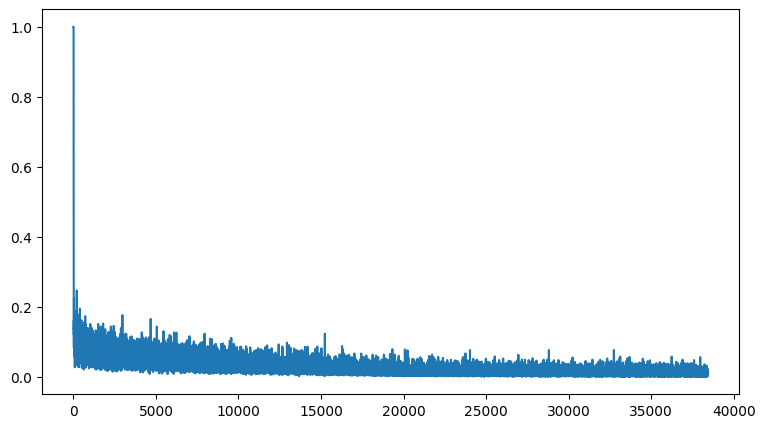

In [166]:
agent_losses = agent.losses
fig, ax = plt.subplots(figsize=(9,5))
ax.plot([min(loss, 1e0) for loss in agent_losses]);

1000 episodios

<AxesSubplot: >

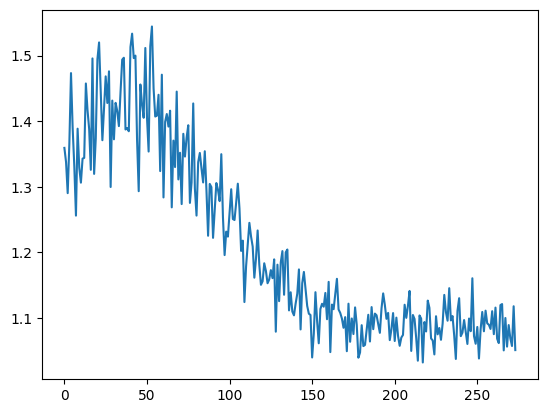

In [167]:
pd.Series(np.array(_[1])).plot()

In [148]:
agent.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 1e-05
    maximize: False
    weight_decay: 0
)

In [43]:
agent = Agent(nstep=1, normalize=True)
env = TSPEnv(n_min=15, n_max=15)
eps_start = 0.9999
eps_decay = 0.99997
eps_end=0.01
# scheduler = ReduceLROnPlateau(agent.optimizer, 'min', patience=4)
scheduler = None

_ = train(agent, env, eps_start, eps_decay, eps_end, scheduler=scheduler,
          n_episodes=20000, validate_each=1000, print_train_metrics_each=50)

[50/20000] loss: 1.088e-01, q_target: -3.521e+00, q_expected: -3.383e+00, eps: 0.9777, time: 7.29s
    θ1: -2.203e-01, θ2: -1.138e-01, θ3: 3.296e-02, θ4: 4.621e-02, θ5: 6.268e-02, θ6: -7.568e-02, θ7: -1.043e-01
[100/20000] loss: 7.203e-02, q_target: -4.543e+00, q_expected: -4.144e+00, eps: 0.9559, time: 14.60s
    θ1: -2.215e-01, θ2: -1.132e-01, θ3: 3.345e-02, θ4: 4.613e-02, θ5: 6.277e-02, θ6: -7.487e-02, θ7: -1.035e-01
[150/20000] loss: 1.150e-01, q_target: -4.389e+00, q_expected: -4.525e+00, eps: 0.9346, time: 21.90s
    θ1: -2.224e-01, θ2: -1.144e-01, θ3: 3.391e-02, θ4: 4.612e-02, θ5: 6.275e-02, θ6: -7.442e-02, θ7: -1.031e-01
[200/20000] loss: 6.122e-02, q_target: -4.510e+00, q_expected: -4.331e+00, eps: 0.9138, time: 29.30s
    θ1: -2.212e-01, θ2: -1.156e-01, θ3: 3.393e-02, θ4: 4.701e-02, θ5: 6.239e-02, θ6: -7.270e-02, θ7: -1.015e-01
[250/20000] loss: 7.204e-02, q_target: -4.464e+00, q_expected: -4.909e+00, eps: 0.8935, time: 39.04s
    θ1: -2.224e-01, θ2: -1.145e-01, θ3: 3.333e-02

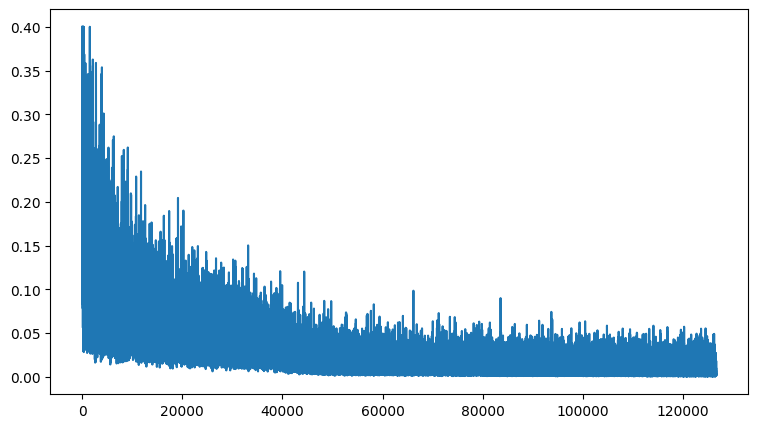

In [46]:
agent_losses = agent.losses
fig, ax = plt.subplots(figsize=(9,5))
ax.plot([min(loss, 4e-1) for loss in agent_losses]);
# ax.plot(agent_losses);

In [50]:
run_episode?

Signature:
run_episode(
    agent,
    env,
    eps_start=0,
    eps_decay=0,
    eps_end=0,
    train_mode=True,
)
Docstring: <no docstring>
File:      /var/folders/y9/ss9wtkk10p1f9dvjc286650h0000gn/T/ipykernel_95463/1376195579.py
Type:      function

In [65]:
env = TSPEnv(n_min=3, n_max=3)

In [66]:
env.G[0]

AtlasView({1: {'weight': 0.5416754057136722, 'closest': 1}, 2: {'weight': 0.7352033098659809, 'closest': 2}})

In [67]:
solution_score

1.328338713966976

0 2
2 1
1 0


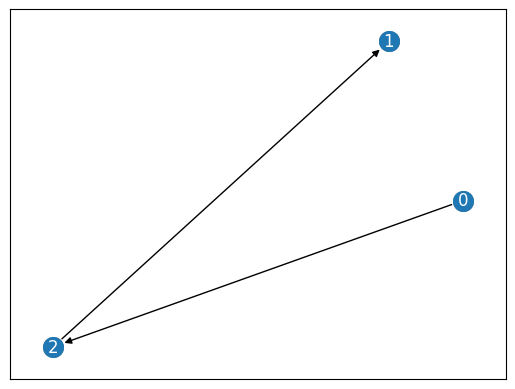

In [87]:
score, _ = run_episode(agent, env, train_mode=False)
solution_path, solution_score = get_solution(env, return_path=True)
plot_network(env.G, env.tour, [], draw_all_edges=False);

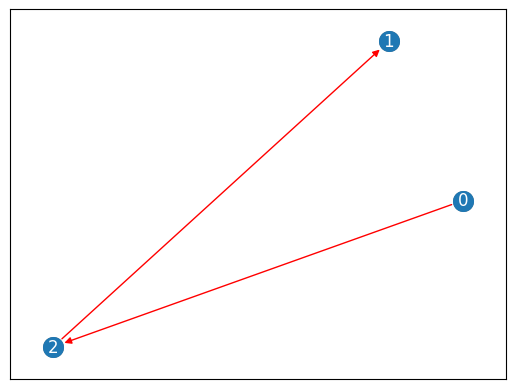

In [88]:
plot_network(env.G, [], solution_path, draw_all_edges=False);

In [89]:
env.tour

[0, 2, 1]

In [92]:
env.G[0][1]['weight'] + env.G[1][2]['weight'] + env.G[2][0]['weight']

0.9368325374132518

In [91]:
score, solution_score

(-0.9368325374132518, 0.9368325374132518)

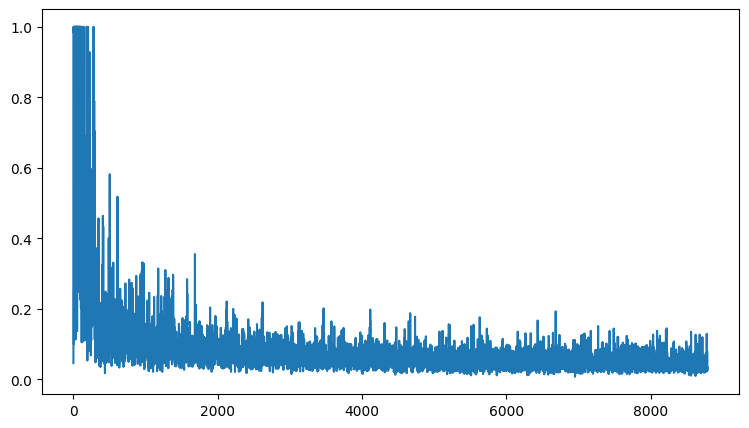

In [41]:
agent_losses = agent.losses
fig, ax = plt.subplots(figsize=(9,5))
ax.plot([min(loss, 1e-0) for loss in agent.losses]);

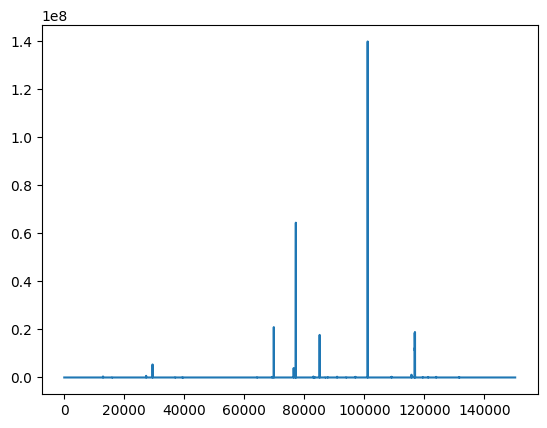

In [33]:
pd.Series(agent.losses).rolling(10).mean().plot();

In [ ]:
agent = Agent(nstep=1, normalize=True)
env = TSPEnv(n_min=15, n_max=15)
eps_start = 0.9999
eps_decay = 0.99997
eps_end=0.01
scheduler = ReduceLROnPlateau(agent.optimizer, 'min', patience=4)

_ = train(agent, env, eps_start, eps_decay, eps_end, scheduler=scheduler,
          n_episodes=20000, validate_each=100, print_train_metrics_each=1)

In [279]:
eps_start = 0.01
eps_decay = 0.01
eps_end=0.01

_ = train(agent, env, eps_start, eps_decay, eps_end, n_episodes=50000, start_episode=20001, validate_each=100, print_train_metrics_each=10)

/Users/tiagomontalvao/dev/ufrj/msc/tese/tsp-rl/agent.py:197: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:485.)
  if self.clip_grad_norm_value is not None:


[10/20000] loss: 3.312e-01, q_target: -9.826e-01, q_expected: -1.558e+00, eps: 0.9954, time: 0.48s
    θ1: -4.824e-02, θ2: 1.909e-02, θ3: 7.755e-02, θ4: -5.488e-02, θ5: 2.062e-02, θ6: 7.905e-02, θ7: 1.195e-02
[20/20000] loss: 1.167e+00, q_target: -4.123e-01, q_expected: -1.492e+00, eps: 0.9909, time: 0.87s
    θ1: -3.162e-02, θ2: 2.132e-02, θ3: 7.678e-02, θ4: -3.637e-02, θ5: 4.912e-02, θ6: 8.098e-02, θ7: 1.284e-02
[30/20000] loss: 4.139e-01, q_target: -1.739e+00, q_expected: -2.382e+00, eps: 0.9865, time: 1.25s
    θ1: 1.436e-02, θ2: 2.347e-02, θ3: 7.719e-02, θ4: -6.323e-02, θ5: 6.899e-02, θ6: 8.351e-02, θ7: 1.319e-02
[40/20000] loss: 2.111e-01, q_target: -1.994e+00, q_expected: -1.535e+00, eps: 0.9821, time: 1.65s
    θ1: 1.568e-02, θ2: 2.312e-02, θ3: 7.343e-02, θ4: -3.970e-02, θ5: 7.459e-02, θ6: 8.379e-02, θ7: 1.333e-02
[50/20000] loss: 5.069e-02, q_target: -2.401e+00, q_expected: -2.626e+00, eps: 0.9777, time: 2.06s
    θ1: 8.909e-02, θ2: 2.542e-02, θ3: 6.948e-02, θ4: -3.465e-02, θ5

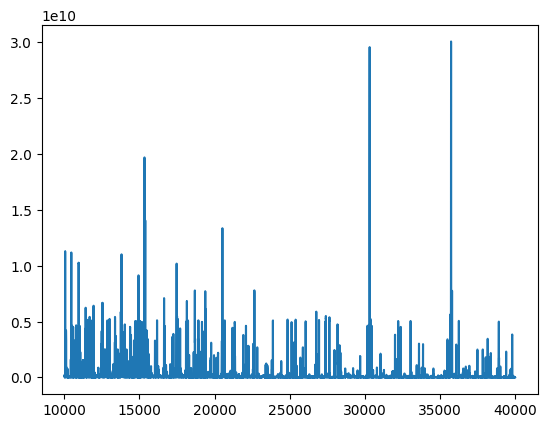

In [148]:
pd.Series(agent.losses).rolling(10).mean().iloc[10000:40000].plot();

In [81]:
agent = Agent(nstep=1)
env = TSPEnv(n_min=10, n_max=10)
eps_start = 0.9999
eps_decay = 0.999975
eps_end=0.01

train(agent, env, eps_start, eps_decay, eps_end, n_episodes=10000, validate_each=1000, print_train_metrics_each=100)

[100/10000] last loss: 1.251896e+05, eps: 0.9752120762781787, time: 4.91s
[200/10000] last loss: 1.876327e+05, eps: 0.9511337070895033, time: 9.88s
[300/10000] last loss: 1.877577e+05, eps: 0.9276498422931427, time: 14.75s
[400/10000] last loss: 6.256943e+04, eps: 0.904745803342154, time: 19.62s
[500/10000] last loss: 1.876346e+05, eps: 0.8824072741086795, time: 24.47s
[600/10000] last loss: 1.251067e+05, eps: 0.8606202919356861, time: 29.34s
[700/10000] last loss: 4.024520e-01, eps: 0.8393712389096226, time: 34.27s
[800/10000] last loss: 1.250741e+05, eps: 0.8186468333485748, time: 39.19s
[900/10000] last loss: 6.261039e+04, eps: 0.7984341215005684, time: 44.06s
[1000/10000] last loss: 6.262113e+04, eps: 0.7787204694468575, time: 48.95s
Validation score: 1.9008830725285044
[1100/10000] last loss: 1.877956e+05, eps: 0.7594935552051088, time: 54.16s
[1200/10000] last loss: 1.251666e+05, eps: 0.74074136102757, time: 59.12s
[1300/10000] last loss: 1.599262e-01, eps: 0.7224521658894084, ti

([-4.856717230218909,
  -3.9434659950709845,
  -5.406408677742485,
  -5.212160792766479,
  -6.17922373834866,
  -5.474619030841255,
  -5.10162548624097,
  -4.2952515473114845,
  -4.999302461872724,
  -4.437349922887374,
  -4.835148165032203,
  -3.8238806353895227,
  -5.624365409278787,
  -4.221190815443114,
  -5.933570772906371,
  -4.887661305684702,
  -6.530959094230221,
  -5.927058456432277,
  -5.959000348513109,
  -4.5741874816107035,
  -7.040044687338758,
  -4.55375087472426,
  -4.464715433526784,
  -5.9536460286763395,
  -5.116073038781616,
  -4.936944475799084,
  -5.59730826573967,
  -5.959033563312646,
  -6.223423911570786,
  -4.508882459343346,
  -6.4738198914111615,
  -5.216305614876741,
  -6.091345804039758,
  -5.398302030077374,
  -4.915469719441292,
  -5.658537723200518,
  -5.698093605628429,
  -4.314452833342501,
  -4.617927302062074,
  -4.705907344488062,
  -6.380487552551247,
  -4.725815530569934,
  -3.89489304072028,
  -4.646500721501766,
  -6.127902349330436,
  -5.4805

In [90]:
eps_start = 0.08207422522123975
eps_decay = 0.999975
eps_end=0.01

_ = train(agent, env, eps_start, eps_decay, eps_end, n_episodes=12000, start_episode=10001, validate_each=1000, print_train_metrics_each=100)

[10100/12000] last loss: 6.253707e+04, eps: 0.08004778036496472, time: 5.08s
[10200/12000] last loss: 6.254933e+04, eps: 0.07807136922809936, time: 9.93s
[10300/12000] last loss: 6.259468e+04, eps: 0.07614375645846076, time: 14.93s
[10400/12000] last loss: 1.876479e+05, eps: 0.0742637372051959, time: 19.77s
[10500/12000] last loss: 6.256938e+04, eps: 0.07243013636569232, time: 24.60s
[10600/12000] last loss: 6.254848e+04, eps: 0.07064180785108373, time: 29.46s
[10700/12000] last loss: 6.257757e+04, eps: 0.0688976338698862, time: 34.29s
[10800/12000] last loss: 6.260153e+04, eps: 0.06719652422932841, time: 39.11s
[10900/12000] last loss: 1.877743e+05, eps: 0.06553741565392568, time: 43.93s
[11000/12000] last loss: 1.251580e+05, eps: 0.06391927112088273, time: 48.76s
Validation score: 1.7638182380145042
[11100/12000] last loss: 3.712318e-01, eps: 0.06234107921190491, time: 53.79s
[11200/12000] last loss: 1.877332e+05, eps: 0.06080185348101211, time: 58.68s
[11300/12000] last loss: 6.2539

In [92]:
eps_start = 0.04978022283623802
eps_decay = 0.999975
eps_end=0.01

_ = train(agent, env, eps_start, eps_decay, eps_end, n_episodes=20000, start_episode=12001, validate_each=1000, print_train_metrics_each=100)

[12100/20000] last loss: 3.922556e-01, eps: 0.04855112958267623, time: 4.89s
[12200/20000] last loss: 1.876774e+05, eps: 0.04735238312428498, time: 9.70s
[12300/20000] last loss: 3.128713e+05, eps: 0.04618323418677233, time: 14.54s
[12400/20000] last loss: 3.127978e+05, eps: 0.045042951995723175, time: 19.40s
[12500/20000] last loss: 3.401004e-01, eps: 0.043930823819829504, time: 24.21s
[12600/20000] last loss: 2.931921e-01, eps: 0.04284615452539931, time: 29.78s
[12700/20000] last loss: 6.261700e+04, eps: 0.04178826614186448, time: 34.80s
[12800/20000] last loss: 1.876393e+05, eps: 0.04075649743801663, time: 39.65s
[12900/20000] last loss: 2.502718e+05, eps: 0.03975020350870535, time: 44.68s
[13000/20000] last loss: 3.129676e-01, eps: 0.038768755371741806, time: 49.57s
Validation score: 1.845805027549731
[13100/20000] last loss: 1.251271e+05, eps: 0.03781153957475449, time: 54.62s
[13200/20000] last loss: 1.251659e+05, eps: 0.03687795781175198, time: 59.53s
[13300/20000] last loss: 6.

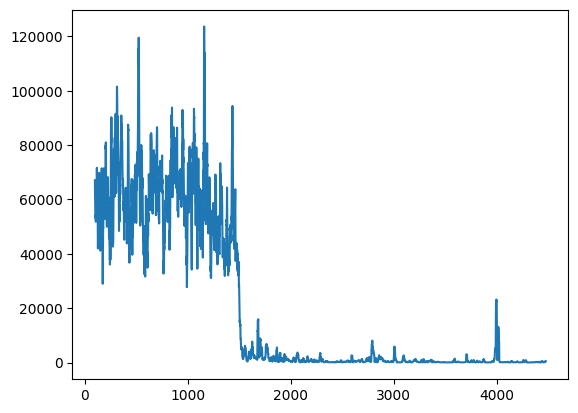

In [128]:
pd.Series(agent.losses).rolling(10).mean().iloc[100:].plot();

In [ ]:
L = 100000
validate_each = 50

agent = Agent(nstep=3)
env = TSPEnv(n_min=10, n_max=10)
scores = []
val_scores = []
eps = eps_start
t1 = time.time()
for episode in range(1, L+1):
    try:
        state = env.reset()
        validation = episode % validate_each == 0
        agent.reset_episode(env.G)
        score = 0
        while True:
            action = agent.act(state, eps=0 if validation else eps)
            next_state, reward, done = env.step(action)
            score += reward
            # print('reward', reward)
            if not validation:
                eps = max(eps*eps_decay, eps_end)
                agent.step(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
        scores.append(score)
        if validation:
            dist_matrix = np.array([[env.G[u].get(v, {}).get("weight", float('inf')) for v in range(env.n)] for u in range(env.n)])
            solution_score = solve_tsp_dynamic_programming(dist_matrix)[1]
            val_scores.append(-score/solution_score)
            print(f"[{episode}/{L}] Final score: {-score/solution_score}, eps: {eps}, last loss: {agent.losses[-1]}")
    except KeyboardInterrupt:
        break
t2= time.time()
print("Total time:", t2 - t1)

[50/100000] Final score: 1.4989330444629003, eps: 0.9756995115134622, last loss: 250366.75


In [13]:
with open("losses.txt", "w") as f:
    for loss in agent.losses:
        f.write(f"{loss}\n")

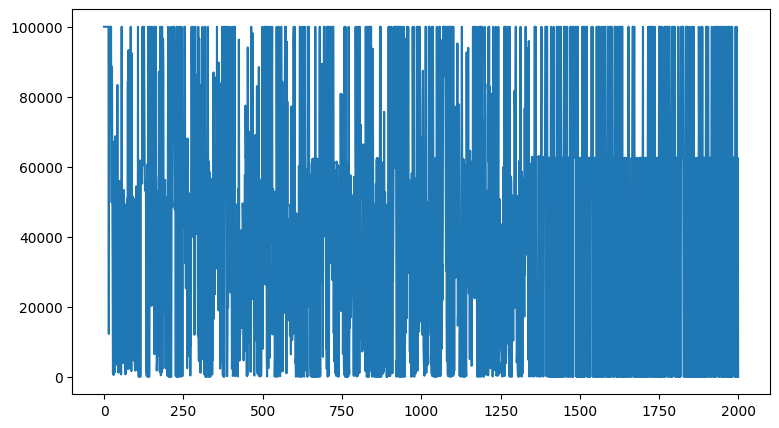

In [33]:
agent_losses = agent.losses
fig, ax = plt.subplots(figsize=(9,5))
ax.plot([min(loss, 1e5) for loss in agent.losses]);

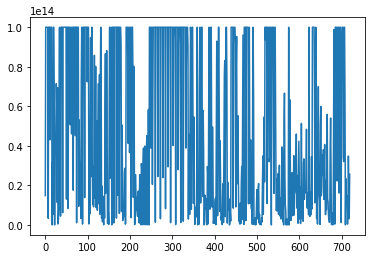

In [15]:
losses = [14828352569344.0, 2.2553684161121485e+17, 7.925906019241165e+16, 2026945927708672.0, 6147520908492800.0, 4790590952701952.0, 1045775748431872.0, 3328537526272.0, 2803780420632576.0, 3537677320192000.0, 1557000001421312.0, 43036276948992.0, 864137957605376.0, 1404930912944128.0, 1360519474708480.0, 489528561238016.0, 681001216.0, 31526202900480.0, 5276355788800.0, 143169933017088.0, 165171842514944.0, 72860429189120.0, 694849600.0, 35021872168960.0, 39365485002752.0, 47134816600064.0, 71460110467072.0, 61636253581312.0, 11415640342528.0, 69399029481472.0, 454729039872.0, 3017474834432.0, 8701980704768.0, 99380006748160.0, 207631503327232.0, 90076956590080.0, 4453146558464.0, 170504262516736.0, 807685041684480.0, 575021965639680.0, 263440425811968.0, 6169421152256.0, 282648844959744.0, 607427292561408.0, 563614733828096.0, 418518625419264.0, 348090221461504.0, 6017536944504832.0, 152786012471296.0, 154805351743488.0, 13053942824960.0, 146290964955136.0, 187953791893504.0, 250663871184896.0, 8314503036928.0, 149493852930048.0, 320251082309632.0, 240539509194752.0, 61384842805248.0, 50681981435904.0, 211961451118592.0, 234588681011200.0, 46062064631808.0, 85829108105216.0, 303882727063552.0, 234763935809536.0, 17563407876096.0, 121385749839872.0, 310846513217536.0, 221727351111680.0, 119424157745152.0, 45150445240320.0, 193869085933568.0, 141083266777088.0, 1098069245952.0, 377531114979328.0, 477581237288960.0, 501866458775552.0, 136008964243456.0, 9404967550976.0, 53086496227328.0, 21245462577152.0, 23358894768128.0, 31832615682048.0, 3330800091136.0, 73868387549184.0, 163046756450304.0, 75514567983104.0, 430829469696.0, 202684422422528.0, 401607996997632.0, 453803157487616.0, 245215805833216.0, 13781082046464.0, 237984926400512.0, 682463391121408.0, 1058522607386624.0, 653469811736576.0, 124538096451584.0, 72426360668160.0, 266900441399296.0, 353681295802368.0, 129265437769728.0, 469389410304.0, 38282926751744.0, 5527200858112.0, 55567603204096.0, 94778326777856.0, 24435226574848.0, 64822725050368.0, 133458315706368.0, 30125080969216.0, 10458600833024.0, 29468221505536.0, 9172272807936.0, 32599898587136.0, 85803170529280.0, 13424602906624.0, 33166542766080.0, 80179850379264.0, 8815578710016.0, 27713991606272.0, 52565051965440.0, 7435525292032.0, 36632803672064.0, 71374244675584.0, 42262897623040.0, 10653069737984.0, 75962100219904.0, 5426216173568.0, 71117779763200.0, 154482222563328.0, 75523334078464.0, 3550239784960.0, 19663052341248.0, 1612757729280.0, 6595897982976.0, 3445062631424.0, 57680666624.0, 14515368361984.0, 3500790775808.0, 56803836559360.0, 86652861022208.0, 16049253646336.0, 41142066348032.0, 88220482142208.0, 51359239897088.0, 759993401344.0, 2491876900864.0, 6405232263168.0, 279807131648.0, 58593634156544.0, 138298727071744.0, 23630408843264.0, 55376099672064.0, 151924955414528.0, 79462959939584.0, 38256230400.0, 329284874928128.0, 662981352357888.0, 556392612102144.0, 230335992299520.0, 981605351424.0, 283705507577856.0, 603376735748096.0, 684310428385280.0, 512603642134528.0, 240681964535808.0, 3448300371968.0, 119007327813632.0, 126278615171072.0, 14946636136448.0, 102475939971072.0, 222263014064128.0, 135153275895808.0, 5785487147008.0, 126166090383360.0, 307936236666880.0, 279239614005248.0, 90844380004352.0, 6784274661376.0, 50555854520320.0, 33780832141312.0, 2210407645184.0, 5527163633664.0, 9799954595840.0, 4173718355968.0, 26588378824704.0, 28653152894976.0, 376996003840.0, 865108361216.0, 1.2557672624685056e+16, 291575028514816.0, 428489995976704.0, 321140442529792.0, 80180563410944.0, 41173678817280.0, 213975807557632.0, 201846585032704.0, 36639485198336.0, 45212499968000.0, 119064764612608.0, 83770090717184.0, 3642112606208.0, 123495568637952.0, 297394172329984.0, 262892247056384.0, 77719454875648.0, 13904844423168.0, 80240600678400.0, 54777169838080.0, 104556519424.0, 933449695232.0, 25439435227136.0, 15373049004032.0, 13419386241024.0, 7615568936960.0, 6697495560192.0, 4401704468480.0, 16645812649984.0, 17135625568256.0, 1537877737472.0, 1034142547968.0, 25407889866752.0, 23579026522112.0, 691997704192.0, 54099038208.0, 30975992004608.0, 27800648024064.0, 371358597120.0, 83956219904.0, 31078752452608.0, 38895978807296.0, 446501945344.0, 178097504256.0, 39874375712768.0, 33642319446016.0, 1161290711040.0, 72386830336.0, 38946687942656.0, 45133458309120.0, 657785880576.0, 107091255296.0, 57982498897920.0, 58405544787968.0, 19784110080.0, 176492503891968.0, 322536306900992.0, 184450071658496.0, 42755174694912.0, 38800541614080.0, 147772997107712.0, 125541986336768.0, 20506912751616.0, 56162913353728.0, 1.1271006723244032e+16, 296224028622848.0, 378718673436672.0, 304072678703104.0, 132485992153088.0, 1345637056512.0, 205713162895360.0, 584198163267584.0, 758156821004288.0, 747838698946560.0, 337967050653696.0, 24463785590784.0, 123569723932672.0, 371609831473152.0, 482904144609280.0, 378363197784064.0, 164246159622144.0, 3133608034304.0, 351131830059008.0, 998430579097600.0, 1296638278631424.0, 1012354594635776.0, 438594174976000.0, 23937926823936.0, 208607182323712.0, 477663412092928.0, 606055788707840.0, 494671683911680.0, 230162633326592.0, 8223588352000.0, 237230236893184.0, 716986338246656.0, 930271461376000.0, 1017535466045440.0, 451983869739008.0, 29382817087488.0, 182114817409024.0, 536950838657024.0, 670094086635520.0, 544919177396224.0, 229963387109376.0, 1137123655680.0, 279581147791360.0, 776130588049408.0, 1008108214157312.0, 822095059615744.0, 382567937212416.0, 40150067314688.0, 94077894787072.0, 369446241697792.0, 490738735382528.0, 398234602176512.0, 159860830240768.0, 187253522432.0, 317241115541504.0, 847794533302272.0, 1090771637764096.0, 701286152404992.0, 323262861017088.0, 27930633699328.0, 91753713500160.0, 311417173442560.0, 398589071196160.0, 322710756392960.0, 140418704474112.0, 1207431725056.0, 159753221177344.0, 444392716369920.0, 556670811897856.0, 419385168625664.0, 159941545426944.0, 1891703193600.0, 146037947760640.0, 428524456378368.0, 540478818746368.0, 462342190006272.0, 256676036870144.0, 38883307814912.0, 79597227999232.0, 327616649232384.0, 438809325993984.0, 294828399132672.0, 90237841702912.0, 2968811732992.0, 43791041953792.0, 45741305233408.0, 5321363292160.0, 48651405623296.0, 1.2851663136096256e+16, 95138802040832.0, 7899247542272.0, 61036342280192.0, 156068458004480.0, 137462869393408.0, 44690401394688.0, 10887729512448.0, 54626762096640.0, 25949244489728.0, 216671633408.0, 995301523456.0, 8760984076288.0, 3986795003904.0, 9251038691328.0, 10438017286144.0, 1.005583914237952e+16, 9851753472.0, 25060435820544.0, 25921213956096.0, 331481153536.0, 70453863383040.0, 134803428999168.0, 97492712554496.0, 11096573345792.0, 48755025903616.0, 129660675424256.0, 117950891687936.0, 33977148637184.0, 14376836792320.0, 57908205191168.0, 37006293860352.0, 1333710336.0, 528180084736.0, 15015129120768.0, 7930036355072.0, 11019744182272.0, 13212643753984.0, 1330589990912.0, 121170821120.0, 29524181909504.0, 24922380304384.0, 628303527936.0, 60462444052480.0, 123402413146112.0, 84270932557824.0, 7970458435584.0, 48092892102656.0, 120744054882304.0, 133222562267136.0, 43176463171584.0, 9041375920128.0, 49507886694400.0, 29565579689984.0, 795521318912.0, 2546450038784.0, 7124970110976.0, 867491053568.0, 11513914982400.0, 13447769096192.0, 70687924224.0, 43104790904832.0, 92951808049152.0, 63546406731776.0, 4679745929216.0, 56621409501184.0, 146755005972480.0, 138461726113792.0, 47217347919872.0, 6867586121728.0, 42533249875968.0, 23782162956288.0, 2456792858624.0, 4033991933952.0, 1645760610304.0, 144698081280.0, 17081226493952.0, 20899159867392.0, 1228532875264.0, 36957157588992.0, 76059466792960.0, 83183886401536.0, 4175189245952.0, 75962100219904.0, 172231812448256.0, 171391240372224.0, 72334211809280.0, 911811084288.0, 21593195544576.0, 8949622374400.0, 7586895626240.0, 13197177257984.0, 2346433536.0, 834168029184.0, 6156750684160.0, 1951497191424.0, 1.0459564994461696e+16, 156290202468352.0, 255537367220224.0, 240139406147584.0, 123630734278656.0, 8479511150592.0, 91325701554176.0, 275459354918912.0, 351018214752256.0, 354583373152256.0, 93215319392256.0, 9064435154944.0, 79010335817728.0, 95299141894144.0, 25960900460544.0, 20883146014720.0, 55264711540736.0, 29103348514816.0, 1979829059584.0, 6597911248896.0, 628607942656.0, 441065996288.0, 11165702815744.0, 709705138176.0, 21315507453952.0, 29534963367936.0, 2721866317824.0, 46863554183168.0, 96026048331776.0, 53190649184256.0, 238925447168.0, 118988998705152.0, 237255369162752.0, 250210903130112.0, 119277852033024.0, 2178835808256.0, 182703882240000.0, 461571880910848.0, 566935884398592.0, 352381363552256.0, 1.860117049901056e+16, 10697033383936.0, 88047894921216.0, 107176496463872.0, 36526452899840.0, 10888943763456.0, 43061103034368.0, 15776338673664.0, 8156918841344.0, 17380627447808.0, 301330726912.0, 72159997198336.0, 127365124456448.0, 65969611341824.0, 283509391360.0, 1498234748928.0, 3668879867904.0, 8575500800.0, 2391649812480.0, 174476623872.0, 10607059271680.0, 17837445873664.0, 3107054944256.0, 8755870171136.0, 18767471968256.0, 20907793842176.0, 947460833280.0, 5384887074816.0, 220088582144.0, 759644749824.0, 955076182016.0, 30471192576.0, 3659293523968.0, 1514711154688.0, 20932015947776.0, 34919306756096.0, 5403839561728.0, 25203774062592.0, 54674904317952.0, 21797619630080.0, 1.0808694296018944e+16, 93661517840384.0, 185218602369024.0, 177194227728384.0, 111084178505728.0, 10825205022720.0, 49244127887360.0, 157440666501120.0, 195812340531200.0, 182369042563072.0, 31961565364224.0, 34191806824448.0, 114332205580288.0, 131979655774208.0, 76589383548928.0, 8644536320.0, 119521566261248.0, 358081456242688.0, 386619399995392.0, 232748706955264.0, 51534482112512.0, 15951141535744.0, 99886435401728.0, 109195307253760.0, 1.0626070139109376e+16, 63426697101312.0, 21398839885824.0, 7223924752384.0, 23299929145344.0, 7090588876800.0, 18231670603776.0, 25952585252864.0, 5395771293696.0, 16742695829504.0, 30206368677888.0, 11146142679040.0, 4418336980992.0, 13747187875840.0, 2989468680192.0, 9278554374144.0, 39456186826752.0, 38045801775104.0, 1639506116608.0, 14783840518144.0, 7545354240.0, 51792318562304.0, 66641098440704.0, 25282956230656.0, 10185136406528.0, 6874296483840.0, 239878144.0, 3131201028096.0, 159494799360.0, 2175860998144.0, 52554645504.0, 853258665984.0, 1.14994528124928e+16, 292546816.0, 39910450921472.0, 63276553601024.0, 26577488314368.0, 2219980881920.0, 14440182317056.0, 4432439803904.0, 26422890463232.0, 25798922731520.0, 4814689271808.0, 15132659810304.0, 35034845151232.0, 4995797221376.0, 15415737581568.0, 16277609381888.0, 18579340656640.0, 29702674710528.0, 45959828471808.0, 16824500486144.0, 8395621924864.0, 24968490385408.0, 843385077760.0, 22100228177920.0, 42303473319936.0, 23831267770368.0, 3080839495680.0, 19263742017536.0, 683995168768.0, 15094717087744.0, 51340663324672.0, 15138262351872.0, 3083929387008.0, 11366930841600.0, 1856133791744.0, 31431541653504.0, 33422642774016.0, 12924312616960.0, 19073274478592.0, 20030064427008.0, 16274962776064.0, 27966497095680.0, 48388162715648.0, 11013796659200.0, 8476389539840.0, 16194121760768.0, 12262715686912.0, 5095132495872.0, 1.1333231135686656e+16, 15872510918656.0, 4345257000960.0, 16793013846016.0, 5006245232640.0, 14345913237504.0, 34498144108544.0, 8108506611712.0, 8964729544376320.0, 146833523343360.0, 274066443337728.0, 296764020097024.0, 200287260246016.0, 62390028730368.0, 11171370369024.0, 72246601187328.0, 139508414676992.0, 72187042070528.0, 3216771383296.0, 23597909278720.0, 443747827712.0, 39200523026432.0, 69960642592768.0, 31612102246400.0, 15118161149952.0, 12037790892032.0, 255404900352.0, 50625614184448.0, 59936335724544.0, 14702868430848.0, 17699321151488.0, 35466980098048.0, 28987197751296.0, 25036333252608.0, 38074528563200.0, 12970427940864.0, 31718161514496.0, 40697356877824.0, 18210225127424.0, 5201756946432.0, 22495063179264.0, 7675160559616.0, 19584448987136.0, 55936995557376.0, 13115870674944.0, 11715011936256.0, 4956856778752.0, 1926033309696.0, 1302154838016.0, 1456791093248.0, 38692978688000.0, 54070609969152.0, 27574092693504.0, 177382490112.0, 1037725270016.0, 6111021236224.0, 3185473536.0, 333492387840.0, 47265624358912.0, 98793743712256.0, 57466586923008.0, 417398685696.0, 188654173552640.0, 352063066210304.0, 2.14797220052992e+16, 205631474630656.0, 22222626357248.0, 43603623673856.0, 155789134135296.0, 200811565023232.0, 183432785166336.0, 16121830834176.0, 64157537796096.0, 174099586351104.0, 170710538387456.0, 80811034411008.0, 1224953167872.0, 91265462960128.0, 234818109440000.0, 298771783090176.0, 221648263315456.0, 34335287672832.0, 31996489236480.0, 132828020867072.0, 136373071773696.0, 62460191047680.0, 40597413888.0, 23427381460992.0, 14706918031360.0, 9535842418688.0, 14566496927744.0, 416458539008.0, 9546246389760.0, 34846730616832.0, 20790206529536.0, 3145770467328.0, 25592024006656.0]
plt.plot([min(loss, 1e14) for loss in losses])

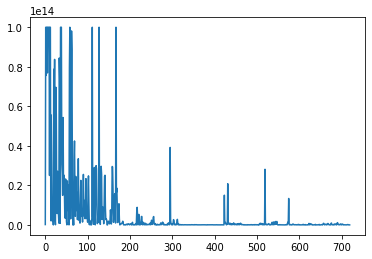

In [16]:
losses = [182428073984.0, 2698872354766848.0, 75625490546688.0, 5598057689251840.0, 3617783828971520.0, 76897060913152.0, 3303972580360192.0, 4639586881896448.0, 3386409377333248.0, 624711314702336.0, 25029249073152.0, 179943627554816.0, 108462495236096.0, 2122309959680.0, 55579426947072.0, 31442430066688.0, 4223090819072.0, 1790832803840.0, 12799042387968.0, 625700224.0, 78758769852416.0, 53508128636928.0, 83739229028352.0, 2818527199232.0, 98207023104.0, 69603761848320.0, 55693205831680.0, 6111061082112.0, 5770574299136.0, 27156230963200.0, 16952052416512.0, 6035934806016.0, 924455337984.0, 84426918723584.0, 74027334893568.0, 788700266496.0, 224136290893824.0, 422471035518976.0, 278952186740736.0, 30733030653952.0, 25758955208704.0, 14947015720960.0, 54343906623488.0, 20210671157248.0, 25182139842560.0, 18549938585600.0, 5834553163776.0, 3408439541760.0, 23233191477248.0, 20541054386176.0, 1676553617408.0, 43664281600.0, 22254826029056.0, 7319784521728.0, 15440341368832.0, 20282160971776.0, 15056271360.0, 79429271289856.0, 137693749051392.0, 77514504404992.0, 3047803584512.0, 48095362547712.0, 98119308017664.0, 88778358128640.0, 24389739347968.0, 862009600.0, 4448927088640.0, 159668496.0, 32502450225152.0, 42462634573824.0, 17752840470528.0, 4341763932160.0, 24517550276608.0, 7266345418752.0, 8781443366912.0, 16382062231552.0, 2672812883968.0, 13855413501952.0, 33479901315072.0, 11767465902080.0, 2225532829696.0, 6684810412032.0, 922667843584.0, 13763877011456.0, 22520054939648.0, 8548992417792.0, 4303865511936.0, 7647724568576.0, 1448946696192.0, 13912929992704.0, 25547688116224.0, 8234810736640.0, 4432363782144.0, 12410091995136.0, 3138360967168.0, 9248009355264.0, 23400361754624.0, 8845580566528.0, 3225752436736.0, 5510164643840.0, 1397384019968.0, 17606398443520.0, 24795022360576.0, 10323240157184.0, 168886484992.0, 2296812929024.0, 44039540736.0, 388463001600.0, 741186666496.0, 250398976.0, 3467528110080.0, 568281014468608.0, 4102334185472.0, 5966851473408.0, 318554144768.0, 16341418377216.0, 29049470582784.0, 18405524504576.0, 35280109568.0, 23015603568640.0, 29970227265536.0, 28335360966656.0, 10229315010560.0, 641626603520.0, 4217166102528.0, 2681399672832.0, 1327311355904.0, 349550946549760.0, 7584031440896.0, 6729624453120.0, 267088445440.0, 15317689434112.0, 29659047657472.0, 25635204366336.0, 2763161600000.0, 3695983198208.0, 9011931906048.0, 6148718592000.0, 592798351360.0, 9565250781184.0, 24567506534400.0, 25123633496064.0, 8479662669824.0, 2697556656128.0, 3007009259520.0, 2502654427136.0, 13470619648.0, 9593027584.0, 1546180362240.0, 1919241682944.0, 1562890076160.0, 897436024832.0, 554176020480.0, 2648753045504.0, 7601120608256.0, 3514871316480.0, 466838749184.0, 6084900159488.0, 29556194934784.0, 29283703586816.0, 18029024903168.0, 1299515703296.0, 4936652816384.0, 13095272448000.0, 15742722375680.0, 9267122798592.0, 965825069056.0, 210800434216960.0, 16473020956672.0, 18605479559168.0, 10633409986560.0, 1203648200704.0, 1758118150144.0, 6158968946688.0, 10703458009088.0, 3095094362112.0, 25407084544.0, 387049455616.0, 227942268928.0, 573103472640.0, 768421396480.0, 736665141248.0, 1102797209600.0, 1871675785216.0, 989127704576.0, 22855241728.0, 102995099648.0, 29508540416.0, 1684568832.0, 48831053824.0, 10300930048.0, 325160534016.0, 385011548160.0, 163878830080.0, 58673434624.0, 454876725248.0, 580900028416.0, 290719399936.0, 328551923712.0, 37441474560.0, 293883805696.0, 401476845568.0, 631850139648.0, 89895329792.0, 16621527040.0, 868746067968.0, 1304811536384.0, 89746677760.0, 33610072064.0, 25001459712.0, 4151160576.0, 67605458944.0, 67183603712.0, 542976671744.0, 653484687360.0, 9888612352.0, 6483755925504.0, 8886876635136.0, 4157578149888.0, 31851362304.0, 3803986001920.0, 5313273004032.0, 3297688944640.0, 6912259584.0, 41953689600.0, 1169058299904.0, 241480351744.0, 4235739529216.0, 4260867866624.0, 210824691712.0, 68786339840.0, 1354962305024.0, 178581454848.0, 808964456448.0, 941753761792.0, 29650946048.0, 43978702848.0, 802200551424.0, 464655581184.0, 110375444480.0, 38584156160.0, 269326221312.0, 227062251520.0, 182701113344.0, 312140660736.0, 170184720384.0, 144349085696.0, 444042969088.0, 1007184838656.0, 49848598528.0, 1328560472064.0, 2369013415936.0, 1878216802304.0, 248055300096.0, 1112185372672.0, 3752794259456.0, 4229449383936.0, 1171549716480.0, 147720699904.0, 581655986176.0, 685194870784.0, 3242220544.0, 5504081920.0, 180688322560.0, 26398775296.0, 321622540288.0, 201718202368.0, 44177735680.0, 37479796736.0, 202361880576.0, 155562409984.0, 617149824.0, 453603917824.0, 1042326159360.0, 599171596288.0, 133870190592.0, 513529905152.0, 1399312089088.0, 1217830846464.0, 545621180416.0, 11478926336.0, 212148912128.0, 248886738944.0, 19993888768.0, 71949746176.0, 21973764096.0, 4543198208.0, 162434990080.0, 396951027712.0, 2010939520.0, 806329909248.0, 970906730496.0, 1094177718272.0, 61427392512.0, 1244724068352.0, 39199063408640.0, 2344716599296.0, 644807786496.0, 89823084544.0, 535207837696.0, 242477449216.0, 983355520.0, 991342821376.0, 2677986557952.0, 1808344547328.0, 574920327168.0, 27885744128.0, 240362225664.0, 265107849216.0, 2896942336.0, 517800787968.0, 1397892448256.0, 2812702883840.0, 790210740224.0, 38706823168.0, 490219831296.0, 280274960384.0, 998401984.0, 3063401216.0, 167346847744.0, 112882221056.0, 31810148352.0, 14060505088.0, 119755448320.0, 109101064192.0, 44495683584.0, 30411347968.0, 53643657216.0, 40151343104.0, 89308635136.0, 76037513216.0, 72648843264.0, 56988672000.0, 69373239296.0, 57188896768.0, 57722466304.0, 34639724544.0, 78890762240.0, 61851938816.0, 56018370560.0, 30688557056.0, 85413273600.0, 61863628800.0, 45786157056.0, 30546651136.0, 111777554432.0, 94071635968.0, 43364524032.0, 45487505408.0, 83752361984.0, 68054982656.0, 38874628096.0, 33147299840.0, 138869506048.0, 102463692800.0, 46022692864.0, 54764425216.0, 110027546624.0, 82683568128.0, 79165980672.0, 28555085824.0, 61345755136.0, 40316424192.0, 37532475392.0, 39485267968.0, 47167803392.0, 24723316736.0, 39875497984.0, 39455666176.0, 78512603136.0, 62174674944.0, 67933732864.0, 63967514624.0, 50542235648.0, 32216479744.0, 100922490880.0, 42747215872.0, 60454760448.0, 41412861952.0, 62630567936.0, 52256587776.0, 36415897600.0, 13091593216.0, 107252645888.0, 50661683200.0, 52980531200.0, 47337791488.0, 97725014016.0, 95356207104.0, 54518747136.0, 42360639488.0, 69494710272.0, 52477644800.0, 41992617984.0, 22485751808.0, 88537489408.0, 74728972288.0, 21665484800.0, 15630625792.0, 59184672768.0, 46965608448.0, 39144624128.0, 30578993152.0, 81978859520.0, 79195242496.0, 28396126208.0, 13283023872.0, 52859297792.0, 35004166144.0, 23985723392.0, 18771740672.0, 40375377920.0, 33231923200.0, 8882685952.0, 8382180864.0, 80024485888.0, 34501484544.0, 30822629376.0, 19203307520.0, 47023165440.0, 54236819456.0, 33605214208.0, 12377340928.0, 15035048919040.0, 793457852416.0, 1318669778944.0, 1083019034624.0, 361863610368.0, 41003212800.0, 293487640576.0, 338141085696.0, 20844935905280.0, 506941145088.0, 1048102961152.0, 936236220416.0, 242878447616.0, 260123967488.0, 820661125120.0, 532790509568.0, 24185847808.0, 264580612096.0, 630267707392.0, 531278430208.0, 102188105728.0, 271845441536.0, 1030911229952.0, 450661154816.0, 127481487360.0, 155979579392.0, 483797106688.0, 441523372032.0, 81223860224.0, 133103845376.0, 433815879680.0, 612828708864.0, 26709364736.0, 191642566656.0, 661626093568.0, 597682814976.0, 66203803648.0, 316786606080.0, 860885221376.0, 738534817792.0, 187468218368.0, 90434625536.0, 232275558400.0, 194292072448.0, 113383555072.0, 34586980352.0, 160857948160.0, 35756728320.0, 6150400.0, 98252152832.0, 23903942656.0, 36071124992.0, 68826996736.0, 6145070592.0, 142684487680.0, 42490195968.0, 19887628288.0, 95179341824.0, 21718505472.0, 5324110336.0, 74733617152.0, 63616188416.0, 39000326144.0, 149289893888.0, 77121732608.0, 126867038208.0, 7216927232.0, 12903938048.0, 113055653888.0, 69475205120.0, 27877644288.0, 753392704.0, 179960070144.0, 110566227968.0, 10204939264.0, 24745019392.0, 70857646080.0, 139655430144.0, 37023531008.0, 64281518080.0, 20511539200.0, 212789854208.0, 3706678784.0, 365475856384.0, 697192415232.0, 860489056256.0, 203729010688.0, 202141515776.0, 697427951616.0, 674318516224.0, 111772540928.0, 97934884864.0, 511225004032.0, 227858726912.0, 4591417344.0, 416581189632.0, 28142095826944.0, 600338268160.0, 161038680064.0, 88312389632.0, 321448181760.0, 247510237184.0, 69746040832.0, 218295222272.0, 431919398912.0, 667203928064.0, 221868081152.0, 6554440704.0, 188337127424.0, 173126942720.0, 16232841.0, 404609859584.0, 655715729408.0, 1347859513344.0, 544394969088.0, 3857248512.0, 624850698240.0, 1560781783040.0, 1079059218432.0, 174110081024.0, 770654404608.0, 1725001236480.0, 357544787968.0, 1194431479808.0, 1741887897600.0, 265397288960.0, 41372168192.0, 105118932992.0, 24371111936.0, 6883274240.0, 95616237568.0, 137153568768.0, 51705073664.0, 54888054784.0, 41149239296.0, 48741380096.0, 17210882048.0, 25606559744.0, 92755730432.0, 87017627648.0, 22538340352.0, 10250954752.0, 23657977856.0, 4736398848.0, 97355079680.0, 22360864768.0, 135524851712.0, 121718652928.0, 3323329.0, 596749320192.0, 1351920648192.0, 972923797504.0, 13374495653888.0, 137491709952.0, 18392377344.0, 128119431168.0, 134170746880.0, 218493845504.0, 8173606400.0, 11887595520.0, 853314.0625, 204690636800.0, 464943972352.0, 341400059904.0, 99356557312.0, 20101001216.0, 127306596352.0, 147738755072.0, 116724719616.0, 28107444224.0, 108164194304.0, 65302224896.0, 1116963200.0, 129409269760.0, 222258036736.0, 126973919232.0, 220842655744.0, 18879024.0, 68540547072.0, 74444120064.0, 6904155648.0, 10151267328.0, 59223601152.0, 56863531008.0, 37067128832.0, 62940901376.0, 282196017152.0, 181360787456.0, 2094206464.0, 14225988608.0, 66188881920.0, 169600450560.0, 2566106368.0, 26638237696.0, 24676638720.0, 719500160.0, 20642002944.0, 55051706368.0, 8877973504.0, 313863536640.0, 756658143232.0, 166070108160.0, 10972352512.0, 283854798848.0, 637660561408.0, 461068173312.0, 187398733824.0, 61180416000.0, 176447881216.0, 1094054912.0, 35916312576.0, 32497092608.0, 159542160.0, 44665544704.0, 128414900224.0, 272413016064.0, 76025320.0, 11683772416.0, 1174569984.0, 69143384.0, 90006601728.0, 45235441664.0, 27777388544.0, 82522759168.0, 255143936000.0, 33183084544.0, 17325404160.0, 30190192640.0, 963233280.0, 110422622208.0, 144942579712.0, 95032549376.0, 1963132416.0, 364371279872.0, 805053530112.0, 742864715776.0, 374221537280.0, 31785986048.0, 104089632768.0, 303745368064.0, 384084803584.0, 156199829504.0, 2780611072.0, 230606438400.0, 667420786688.0, 720783998976.0, 488731377664.0, 72891228160.0, 47106469888.0, 20657379328.0, 81246232576.0, 11042856960.0, 756484603904.0, 968843788288.0, 138849206272.0, 46796398592.0, 88253407232.0, 43626467328.0, 4078067712.0, 348406874112.0, 436183957504.0, 52449013760.0, 249136005120.0, 494232207360.0, 303154593792.0, 1846925824.0, 601166053376.0, 1146201702400.0, 845223952384.0, 177130192896.0, 90574741504.0, 202687348736.0, 185643253760.0, 10213982208.0, 265714483200.0, 536439422976.0, 316144189440.0, 14230701056.0, 172642222080.0, 429389250560.0, 301519044608.0, 42708664320.0, 19493185536.0, 72102993920.0, 51574808576.0, 5978942976.0, 34505662464.0, 56967782400.0, 65051521024.0, 11969727488.0, 51014545408.0, 166931087360.0, 177704615936.0, 66476437504.0, 2424429824.0, 8886927360.0, 22597718016.0]
plt.plot([min(loss, 1e14) for loss in losses])

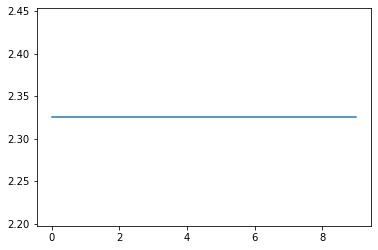

In [17]:
plt.plot(val_scores)

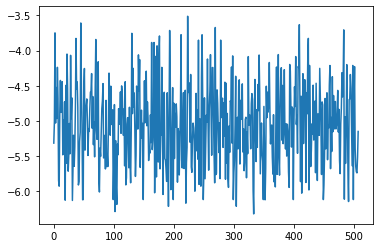

In [18]:
plt.plot(scores)

In [19]:
env.get_tour_cost()

4.59397553679417

In [20]:
score

-4.59397553679417

In [21]:
action = agent.act(state, eps=0)
action

5

In [22]:
next_state, reward, done = env.step(action)

In [23]:
next_state, reward, done

(array([[1.        , 0.        , 0.88425712, 0.45431075, 0.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 0.        ,
         0.90463867, 0.107927  , 0.6807273 , 0.45897507, 0.55331436,
         0.2399829 , 0.28335334, 0.3562668 , 0.31947314],
        [1.        , 0.        , 0.07203433, 0.85263883, 1.        ,
         0.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 0.90463867,
         0.        , 0.79671166, 0.25064306, 1.06330517, 0.39891378,
         0.66715825, 1.11789495, 0.59327729, 0.77475816],
        [1.        , 0.        , 0.78735968, 0.501841  , 1.        ,
         1.        , 0.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 0.107927  ,
         0.79671166, 0.        , 0.57412141, 0.48418438, 0.45014088,
         0.1335509 , 0.36581448, 0.26035822, 0.2748034 ]

In [24]:
agent.step(state, action, reward, next_state, done)

In [25]:
agent.t_step

9

In [26]:
state = next_state

In [27]:
action = agent.act(state, eps=0)
action

0

In [ ]:
env.G[0].get(0, float('inf'))

In [ ]:
env.reset()
print(env.n)

dist_matrix = np.array([[env.G[u].get(v, {}).get("weight", float('inf')) for v in range(env.n)] for u in range(env.n)])

start_time1 = time.time()
ans1 = solve(env.G)
end_time1 = time.time()
print(ans1, end_time1-start_time1)

start_time2 = time.time()
ans2 = solve2(env.G)
end_time2 = time.time()
print(ans2, end_time2-start_time2)

start_time3 = time.time()
ans3 = solve_tsp_dynamic_programming(dist_matrix)[1]
end_time3 = time.time()
print(ans3, end_time3-start_time3)

In [ ]:
fig, ax = plot_network(env.G)
fig.set_size_inches(6, 6)

In [ ]:
def run_episode(model, train_mode=True, eps=0.01, if_train_then_step=True):
    """Runs a single episode of the environment"""    
    env_info = env.reset()
    model.update_model_info(env_info.G)
    score = 0
    while True:
        action = agent.act(state, eps)
        env_info = env.step()
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        score += reward
        if train_mode and if_train_then_step:
            model.step(state, action, reward, next_state, done)
        state = next_state
        if done:
            break
    return score

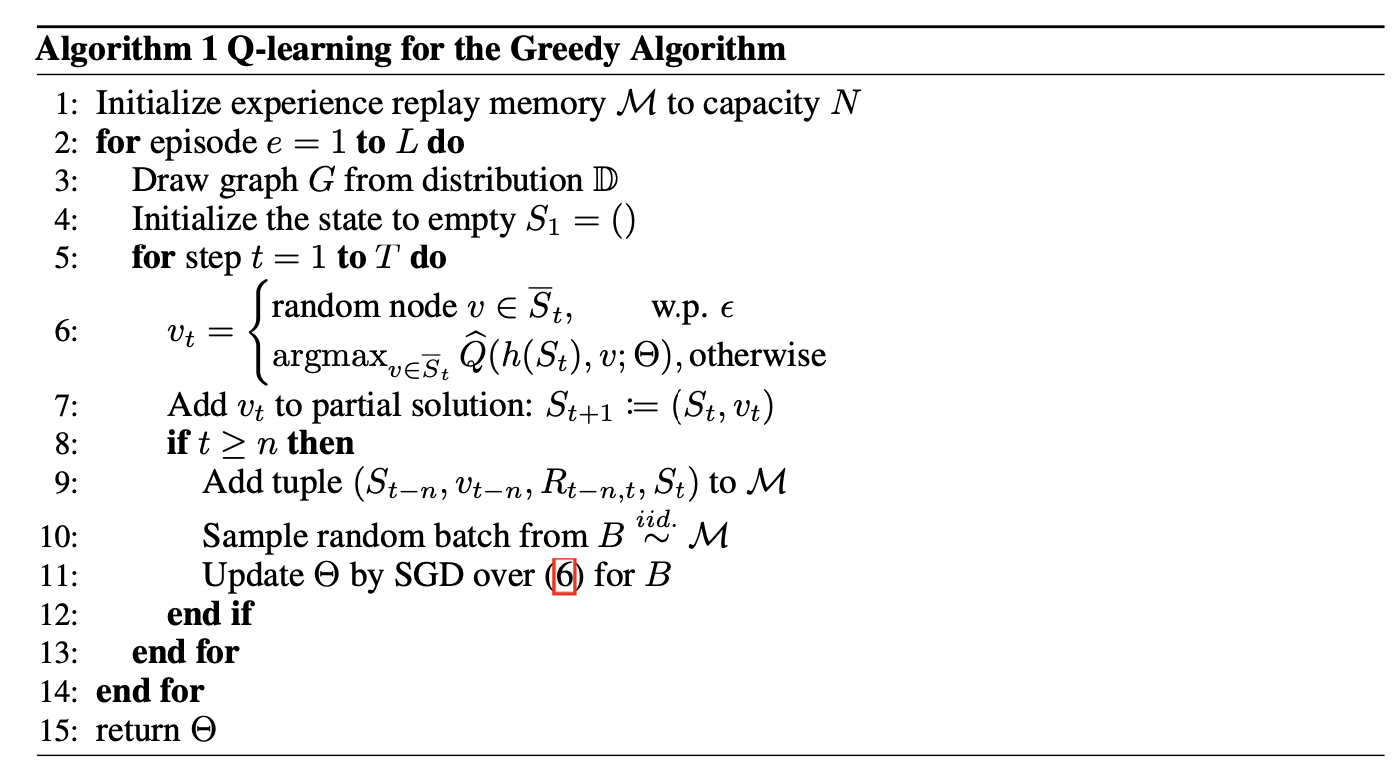

In [ ]:
def train(agent, env, buffer, graph_gen, nstep):
    G = graph_gen.sample()
    env_info = env.reset()
    agent.reset_episode()
    N = G.number_of_nodes()
    S = state = []
    for step in range(1, n+1):
        action = agent.act(state)
        env_info = env.step(action)
        # next_state, reward, done = env.step(action)
        agent.step(self, state, action, env_info.reward, env_info.next_state, env_info.done):
        S.append(v)
        state = next_state
        if done:
            break
        
#         if step >= nstep:
#             buffer.add((*S[step-nstep], R, state))
#             batch = buffer.sample()
#             model.learn(batch)
            
            
            
#         env_info = env.step(action)[brain_name]        # send the action to the environment
#         next_state = env_info.vector_observations[0]   # get the next state
#         reward = env_info.rewards[0]                   # get the reward
#         done = env_info.local_done[0]                  # see if episode has finished
#         score += reward                                # update the score
#         if train_mode and if_train_then_step:
#             agent.step(state, action, reward, next_state, done) # step in the agent model
#         state = next_state                             # roll over the state to next time step
#         if done:                                       # exit loop if episode finished
#             break
    return score